In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 20000
sizeBatch = 32
layerDense = [512, 128, 32, 8, 2]
layerDis = [512, 256]
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'
# nameOptim = Adam(0.0002, 0.5)

## Load the datasets

In [3]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
# xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
# xTest = (xTest.astype(np.float32) - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


In [4]:
inputsDis = Input(shape=(dimEncode,))
x = inputsDis
for numFilt in layerDis:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
validityDis = Dense(1, activation="sigmoid")(x)
discriminator = Model(inputsDis, validityDis, name='discriminator')
discriminator.compile(loss='binary_crossentropy',
                      optimizer=nameOptim,
                      metrics=['accuracy'])
discriminator.trainable = False

## Construct the encoder and decoder

In [5]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
encoder = Model(inputs, x, name='encoder')

inputLatent = Input(shape=(dimEncode,))
x = inputLatent
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Dense(dimInput, activation='tanh')(x)
decoder = Model(inputLatent, x, name='decoder')

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
__________

## Construct the autoencoder

In [6]:
autoencoder = Model(inputs, [decoder(encoder(inputs)), discriminator(encoder(inputs))])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            471994      input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          472776      encoder[1][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            133121      encoder[2][0]                    
Total para

## Compile and train

In [7]:
autoencoder.compile(optimizer=nameOptim, loss=['mse', 'binary_crossentropy'], loss_weights=[0.99, 0.01])

tic = time()
# Adversarial ground truths
valid = np.ones((sizeBatch, 1))
fake = np.zeros((sizeBatch, 1))
for epoch in range(numEpochs):
#     for iBatch in range(int(numTrain/sizeBatch)):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
    imgs = xTrain[idx]

    latent_fake = encoder.predict(imgs)
    latent_real = np.random.normal(size=(sizeBatch, dimEncode))

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = autoencoder.train_on_batch(imgs, [imgs, valid])
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # Plot the progress
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))


# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.711527, acc: 14.06%] [G loss: 0.123573, mse: 0.117801]
1 [D loss: 0.665953, acc: 50.00%] [G loss: 0.114393, mse: 0.108697]
2 [D loss: 0.636693, acc: 50.00%] [G loss: 0.119019, mse: 0.113553]
3 [D loss: 0.599681, acc: 50.00%] [G loss: 0.109382, mse: 0.104132]
4 [D loss: 0.651209, acc: 50.00%] [G loss: 0.100652, mse: 0.095815]
5 [D loss: 0.662708, acc: 50.00%] [G loss: 0.107255, mse: 0.103345]
6 [D loss: 0.712563, acc: 50.00%] [G loss: 0.103350, mse: 0.100308]
7 [D loss: 0.744731, acc: 50.00%] [G loss: 0.095026, mse: 0.092621]
8 [D loss: 0.713313, acc: 50.00%] [G loss: 0.086968, mse: 0.084455]
9 [D loss: 0.499037, acc: 95.31%] [G loss: 0.077353, mse: 0.072258]
10 [D loss: 0.277794, acc: 90.62%] [G loss: 0.091858, mse: 0.078195]
11 [D loss: 0.168661, acc: 95.31%] [G loss: 0.088375, mse: 0.065473]
12 [D loss: 0.266284, acc: 82.81%] [G loss: 0.101041, mse: 0.066986]
13 [D loss: 0.234690, acc: 84.38%] [G loss: 0.097280, mse: 0.063208]
14 [D loss: 0.283196, acc: 85.94%] [G loss: 

127 [D loss: 0.491585, acc: 79.69%] [G loss: 0.075582, mse: 0.065683]
128 [D loss: 0.546758, acc: 78.12%] [G loss: 0.066923, mse: 0.057464]
129 [D loss: 0.453782, acc: 84.38%] [G loss: 0.073762, mse: 0.064280]
130 [D loss: 0.375789, acc: 89.06%] [G loss: 0.073098, mse: 0.063434]
131 [D loss: 0.447050, acc: 90.62%] [G loss: 0.073753, mse: 0.063994]
132 [D loss: 0.496475, acc: 81.25%] [G loss: 0.072920, mse: 0.063350]
133 [D loss: 0.587507, acc: 73.44%] [G loss: 0.074635, mse: 0.065000]
134 [D loss: 0.389645, acc: 89.06%] [G loss: 0.075249, mse: 0.065505]
135 [D loss: 0.531202, acc: 81.25%] [G loss: 0.071166, mse: 0.062029]
136 [D loss: 0.481969, acc: 79.69%] [G loss: 0.068326, mse: 0.059327]
137 [D loss: 0.494070, acc: 79.69%] [G loss: 0.068099, mse: 0.058895]
138 [D loss: 0.469644, acc: 85.94%] [G loss: 0.068456, mse: 0.059516]
139 [D loss: 0.476100, acc: 85.94%] [G loss: 0.076903, mse: 0.068130]
140 [D loss: 0.534861, acc: 82.81%] [G loss: 0.069482, mse: 0.060884]
141 [D loss: 0.42819

255 [D loss: 0.679735, acc: 76.56%] [G loss: 0.069544, mse: 0.062644]
256 [D loss: 0.642072, acc: 76.56%] [G loss: 0.069648, mse: 0.062782]
257 [D loss: 0.699736, acc: 65.62%] [G loss: 0.063699, mse: 0.056927]
258 [D loss: 0.631677, acc: 75.00%] [G loss: 0.064017, mse: 0.057226]
259 [D loss: 0.632733, acc: 76.56%] [G loss: 0.068027, mse: 0.061198]
260 [D loss: 0.691067, acc: 64.06%] [G loss: 0.061565, mse: 0.054687]
261 [D loss: 0.720657, acc: 71.88%] [G loss: 0.073881, mse: 0.067028]
262 [D loss: 0.650206, acc: 70.31%] [G loss: 0.067133, mse: 0.060315]
263 [D loss: 0.697624, acc: 67.19%] [G loss: 0.067907, mse: 0.061041]
264 [D loss: 0.619051, acc: 76.56%] [G loss: 0.069413, mse: 0.062538]
265 [D loss: 0.670499, acc: 68.75%] [G loss: 0.061207, mse: 0.054254]
266 [D loss: 0.639095, acc: 75.00%] [G loss: 0.069794, mse: 0.062729]
267 [D loss: 0.646028, acc: 67.19%] [G loss: 0.062719, mse: 0.055777]
268 [D loss: 0.627252, acc: 71.88%] [G loss: 0.065621, mse: 0.058539]
269 [D loss: 0.69910

382 [D loss: 0.600011, acc: 56.25%] [G loss: 0.064503, mse: 0.058079]
383 [D loss: 0.578203, acc: 64.06%] [G loss: 0.060489, mse: 0.053746]
384 [D loss: 0.666137, acc: 46.88%] [G loss: 0.065460, mse: 0.059464]
385 [D loss: 0.655151, acc: 53.12%] [G loss: 0.063419, mse: 0.056837]
386 [D loss: 0.666407, acc: 45.31%] [G loss: 0.061963, mse: 0.055928]
387 [D loss: 0.637930, acc: 56.25%] [G loss: 0.062083, mse: 0.055618]
388 [D loss: 0.600161, acc: 54.69%] [G loss: 0.059347, mse: 0.053025]
389 [D loss: 0.606263, acc: 53.12%] [G loss: 0.061177, mse: 0.054621]
390 [D loss: 0.640658, acc: 56.25%] [G loss: 0.063595, mse: 0.056782]
391 [D loss: 0.640002, acc: 51.56%] [G loss: 0.059650, mse: 0.053449]
392 [D loss: 0.586035, acc: 67.19%] [G loss: 0.066669, mse: 0.060038]
393 [D loss: 0.647582, acc: 54.69%] [G loss: 0.065981, mse: 0.059459]
394 [D loss: 0.622407, acc: 62.50%] [G loss: 0.060916, mse: 0.054102]
395 [D loss: 0.656097, acc: 54.69%] [G loss: 0.061359, mse: 0.054814]
396 [D loss: 0.59782

510 [D loss: 0.488125, acc: 78.12%] [G loss: 0.070029, mse: 0.060315]
511 [D loss: 0.479148, acc: 82.81%] [G loss: 0.067329, mse: 0.058214]
512 [D loss: 0.465389, acc: 79.69%] [G loss: 0.066816, mse: 0.056513]
513 [D loss: 0.459676, acc: 87.50%] [G loss: 0.062224, mse: 0.051731]
514 [D loss: 0.469975, acc: 78.12%] [G loss: 0.064934, mse: 0.054942]
515 [D loss: 0.510504, acc: 81.25%] [G loss: 0.057998, mse: 0.047886]
516 [D loss: 0.557327, acc: 71.88%] [G loss: 0.068550, mse: 0.059266]
517 [D loss: 0.567224, acc: 70.31%] [G loss: 0.068206, mse: 0.058025]
518 [D loss: 0.476195, acc: 84.38%] [G loss: 0.069655, mse: 0.060142]
519 [D loss: 0.588311, acc: 71.88%] [G loss: 0.066683, mse: 0.056967]
520 [D loss: 0.556973, acc: 68.75%] [G loss: 0.067811, mse: 0.058321]
521 [D loss: 0.517365, acc: 78.12%] [G loss: 0.063290, mse: 0.053491]
522 [D loss: 0.521283, acc: 73.44%] [G loss: 0.060001, mse: 0.050188]
523 [D loss: 0.544412, acc: 70.31%] [G loss: 0.066435, mse: 0.058062]
524 [D loss: 0.57718

637 [D loss: 0.637963, acc: 60.94%] [G loss: 0.062415, mse: 0.055346]
638 [D loss: 0.630047, acc: 60.94%] [G loss: 0.056616, mse: 0.049448]
639 [D loss: 0.662485, acc: 56.25%] [G loss: 0.056371, mse: 0.049339]
640 [D loss: 0.647615, acc: 60.94%] [G loss: 0.060726, mse: 0.053832]
641 [D loss: 0.636641, acc: 57.81%] [G loss: 0.059821, mse: 0.053255]
642 [D loss: 0.598635, acc: 65.62%] [G loss: 0.056471, mse: 0.049501]
643 [D loss: 0.584031, acc: 71.88%] [G loss: 0.060535, mse: 0.053226]
644 [D loss: 0.602902, acc: 60.94%] [G loss: 0.061743, mse: 0.054655]
645 [D loss: 0.620370, acc: 56.25%] [G loss: 0.061757, mse: 0.054988]
646 [D loss: 0.719823, acc: 50.00%] [G loss: 0.059033, mse: 0.053440]
647 [D loss: 0.695451, acc: 53.12%] [G loss: 0.060121, mse: 0.053577]
648 [D loss: 0.610975, acc: 65.62%] [G loss: 0.064703, mse: 0.057543]
649 [D loss: 0.745912, acc: 37.50%] [G loss: 0.059938, mse: 0.053848]
650 [D loss: 0.653949, acc: 56.25%] [G loss: 0.061697, mse: 0.054688]
651 [D loss: 0.68119

765 [D loss: 0.751816, acc: 42.19%] [G loss: 0.054669, mse: 0.048929]
766 [D loss: 0.708380, acc: 59.38%] [G loss: 0.057537, mse: 0.051503]
767 [D loss: 0.691729, acc: 57.81%] [G loss: 0.066757, mse: 0.060381]
768 [D loss: 0.676482, acc: 64.06%] [G loss: 0.053993, mse: 0.047219]
769 [D loss: 0.714974, acc: 48.44%] [G loss: 0.062678, mse: 0.056621]
770 [D loss: 0.669171, acc: 59.38%] [G loss: 0.061541, mse: 0.054876]
771 [D loss: 0.657385, acc: 68.75%] [G loss: 0.060691, mse: 0.053617]
772 [D loss: 0.675907, acc: 56.25%] [G loss: 0.063636, mse: 0.056686]
773 [D loss: 0.698940, acc: 50.00%] [G loss: 0.053856, mse: 0.047404]
774 [D loss: 0.683807, acc: 60.94%] [G loss: 0.060730, mse: 0.054543]
775 [D loss: 0.679279, acc: 51.56%] [G loss: 0.057933, mse: 0.051166]
776 [D loss: 0.679862, acc: 56.25%] [G loss: 0.059108, mse: 0.052451]
777 [D loss: 0.647710, acc: 70.31%] [G loss: 0.056955, mse: 0.050071]
778 [D loss: 0.683647, acc: 56.25%] [G loss: 0.058792, mse: 0.052193]
779 [D loss: 0.69081

894 [D loss: 0.691643, acc: 54.69%] [G loss: 0.051372, mse: 0.044845]
895 [D loss: 0.696660, acc: 50.00%] [G loss: 0.054197, mse: 0.047454]
896 [D loss: 0.684851, acc: 50.00%] [G loss: 0.053531, mse: 0.046930]
897 [D loss: 0.672874, acc: 54.69%] [G loss: 0.053222, mse: 0.046318]
898 [D loss: 0.686040, acc: 56.25%] [G loss: 0.056296, mse: 0.049540]
899 [D loss: 0.699903, acc: 48.44%] [G loss: 0.057065, mse: 0.050253]
900 [D loss: 0.688589, acc: 46.88%] [G loss: 0.055061, mse: 0.048178]
901 [D loss: 0.693584, acc: 54.69%] [G loss: 0.060573, mse: 0.053995]
902 [D loss: 0.692070, acc: 50.00%] [G loss: 0.058361, mse: 0.051644]
903 [D loss: 0.681214, acc: 53.12%] [G loss: 0.052372, mse: 0.045352]
904 [D loss: 0.687109, acc: 51.56%] [G loss: 0.058988, mse: 0.051982]
905 [D loss: 0.708862, acc: 53.12%] [G loss: 0.053250, mse: 0.046568]
906 [D loss: 0.683150, acc: 56.25%] [G loss: 0.059950, mse: 0.053318]
907 [D loss: 0.694789, acc: 50.00%] [G loss: 0.063401, mse: 0.056589]
908 [D loss: 0.70351

1021 [D loss: 0.692176, acc: 54.69%] [G loss: 0.055160, mse: 0.048707]
1022 [D loss: 0.699619, acc: 40.62%] [G loss: 0.058694, mse: 0.052374]
1023 [D loss: 0.674525, acc: 51.56%] [G loss: 0.059746, mse: 0.053117]
1024 [D loss: 0.684667, acc: 56.25%] [G loss: 0.059813, mse: 0.053099]
1025 [D loss: 0.705675, acc: 40.62%] [G loss: 0.052071, mse: 0.045375]
1026 [D loss: 0.695729, acc: 46.88%] [G loss: 0.053860, mse: 0.047247]
1027 [D loss: 0.698337, acc: 48.44%] [G loss: 0.057234, mse: 0.050371]
1028 [D loss: 0.682176, acc: 57.81%] [G loss: 0.056696, mse: 0.049827]
1029 [D loss: 0.687591, acc: 62.50%] [G loss: 0.055840, mse: 0.048996]
1030 [D loss: 0.685014, acc: 57.81%] [G loss: 0.060828, mse: 0.053962]
1031 [D loss: 0.691573, acc: 50.00%] [G loss: 0.049767, mse: 0.043150]
1032 [D loss: 0.695899, acc: 51.56%] [G loss: 0.055248, mse: 0.048536]
1033 [D loss: 0.706547, acc: 42.19%] [G loss: 0.049537, mse: 0.042933]
1034 [D loss: 0.679334, acc: 53.12%] [G loss: 0.057839, mse: 0.051213]
1035 [

1149 [D loss: 0.721342, acc: 45.31%] [G loss: 0.053829, mse: 0.047431]
1150 [D loss: 0.687872, acc: 51.56%] [G loss: 0.052213, mse: 0.045540]
1151 [D loss: 0.708201, acc: 46.88%] [G loss: 0.055022, mse: 0.048746]
1152 [D loss: 0.696853, acc: 51.56%] [G loss: 0.049531, mse: 0.042955]
1153 [D loss: 0.698694, acc: 54.69%] [G loss: 0.051875, mse: 0.045391]
1154 [D loss: 0.683651, acc: 57.81%] [G loss: 0.052057, mse: 0.045410]
1155 [D loss: 0.700058, acc: 40.62%] [G loss: 0.053970, mse: 0.047751]
1156 [D loss: 0.698103, acc: 51.56%] [G loss: 0.056055, mse: 0.049793]
1157 [D loss: 0.676826, acc: 59.38%] [G loss: 0.057095, mse: 0.050555]
1158 [D loss: 0.673682, acc: 56.25%] [G loss: 0.054977, mse: 0.048345]
1159 [D loss: 0.718713, acc: 43.75%] [G loss: 0.053076, mse: 0.046922]
1160 [D loss: 0.700306, acc: 48.44%] [G loss: 0.049052, mse: 0.042650]
1161 [D loss: 0.701005, acc: 51.56%] [G loss: 0.054196, mse: 0.047968]
1162 [D loss: 0.696000, acc: 43.75%] [G loss: 0.057455, mse: 0.051345]
1163 [

1275 [D loss: 0.687724, acc: 56.25%] [G loss: 0.055995, mse: 0.049542]
1276 [D loss: 0.672976, acc: 62.50%] [G loss: 0.054952, mse: 0.048424]
1277 [D loss: 0.693706, acc: 54.69%] [G loss: 0.052383, mse: 0.045820]
1278 [D loss: 0.696398, acc: 54.69%] [G loss: 0.045503, mse: 0.039121]
1279 [D loss: 0.683396, acc: 51.56%] [G loss: 0.055065, mse: 0.048697]
1280 [D loss: 0.690906, acc: 56.25%] [G loss: 0.056487, mse: 0.050143]
1281 [D loss: 0.690956, acc: 51.56%] [G loss: 0.048853, mse: 0.042277]
1282 [D loss: 0.695988, acc: 50.00%] [G loss: 0.051828, mse: 0.045502]
1283 [D loss: 0.695716, acc: 48.44%] [G loss: 0.053619, mse: 0.047197]
1284 [D loss: 0.687336, acc: 59.38%] [G loss: 0.050182, mse: 0.043731]
1285 [D loss: 0.685553, acc: 51.56%] [G loss: 0.048459, mse: 0.041857]
1286 [D loss: 0.694449, acc: 42.19%] [G loss: 0.051471, mse: 0.045108]
1287 [D loss: 0.685759, acc: 59.38%] [G loss: 0.057689, mse: 0.051264]
1288 [D loss: 0.681474, acc: 60.94%] [G loss: 0.056471, mse: 0.049845]
1289 [

1405 [D loss: 0.695925, acc: 53.12%] [G loss: 0.052678, mse: 0.046150]
1406 [D loss: 0.699319, acc: 56.25%] [G loss: 0.052719, mse: 0.046190]
1407 [D loss: 0.694023, acc: 51.56%] [G loss: 0.048683, mse: 0.042153]
1408 [D loss: 0.693787, acc: 43.75%] [G loss: 0.056919, mse: 0.050382]
1409 [D loss: 0.689034, acc: 59.38%] [G loss: 0.054821, mse: 0.048151]
1410 [D loss: 0.691628, acc: 53.12%] [G loss: 0.056369, mse: 0.049720]
1411 [D loss: 0.687288, acc: 54.69%] [G loss: 0.052773, mse: 0.046161]
1412 [D loss: 0.701352, acc: 48.44%] [G loss: 0.055098, mse: 0.048790]
1413 [D loss: 0.673141, acc: 60.94%] [G loss: 0.060395, mse: 0.053689]
1414 [D loss: 0.686320, acc: 59.38%] [G loss: 0.048284, mse: 0.041602]
1415 [D loss: 0.690479, acc: 50.00%] [G loss: 0.052783, mse: 0.045908]
1416 [D loss: 0.690520, acc: 48.44%] [G loss: 0.052091, mse: 0.045455]
1417 [D loss: 0.698492, acc: 50.00%] [G loss: 0.049766, mse: 0.043296]
1418 [D loss: 0.694457, acc: 53.12%] [G loss: 0.054424, mse: 0.047704]
1419 [

1534 [D loss: 0.716539, acc: 42.19%] [G loss: 0.051483, mse: 0.044971]
1535 [D loss: 0.704338, acc: 53.12%] [G loss: 0.049620, mse: 0.043441]
1536 [D loss: 0.681832, acc: 64.06%] [G loss: 0.049586, mse: 0.042726]
1537 [D loss: 0.686504, acc: 50.00%] [G loss: 0.057972, mse: 0.051429]
1538 [D loss: 0.681372, acc: 56.25%] [G loss: 0.055682, mse: 0.049136]
1539 [D loss: 0.687148, acc: 54.69%] [G loss: 0.050228, mse: 0.043613]
1540 [D loss: 0.685551, acc: 48.44%] [G loss: 0.052490, mse: 0.045816]
1541 [D loss: 0.699260, acc: 46.88%] [G loss: 0.048689, mse: 0.042094]
1542 [D loss: 0.684394, acc: 56.25%] [G loss: 0.055603, mse: 0.048936]
1543 [D loss: 0.715797, acc: 46.88%] [G loss: 0.052148, mse: 0.045526]
1544 [D loss: 0.693438, acc: 53.12%] [G loss: 0.048731, mse: 0.042048]
1545 [D loss: 0.706816, acc: 40.62%] [G loss: 0.055211, mse: 0.048811]
1546 [D loss: 0.685721, acc: 59.38%] [G loss: 0.052471, mse: 0.045627]
1547 [D loss: 0.691287, acc: 48.44%] [G loss: 0.054898, mse: 0.048180]
1548 [

1662 [D loss: 0.700078, acc: 45.31%] [G loss: 0.052179, mse: 0.045893]
1663 [D loss: 0.686379, acc: 48.44%] [G loss: 0.050514, mse: 0.043889]
1664 [D loss: 0.695457, acc: 54.69%] [G loss: 0.054067, mse: 0.047690]
1665 [D loss: 0.679502, acc: 60.94%] [G loss: 0.050169, mse: 0.043516]
1666 [D loss: 0.699108, acc: 43.75%] [G loss: 0.054604, mse: 0.048138]
1667 [D loss: 0.694539, acc: 53.12%] [G loss: 0.051351, mse: 0.044658]
1668 [D loss: 0.708125, acc: 45.31%] [G loss: 0.054311, mse: 0.047863]
1669 [D loss: 0.680778, acc: 57.81%] [G loss: 0.050527, mse: 0.043852]
1670 [D loss: 0.689037, acc: 50.00%] [G loss: 0.052034, mse: 0.045621]
1671 [D loss: 0.703113, acc: 45.31%] [G loss: 0.057677, mse: 0.051128]
1672 [D loss: 0.696974, acc: 50.00%] [G loss: 0.054761, mse: 0.048200]
1673 [D loss: 0.700555, acc: 48.44%] [G loss: 0.052739, mse: 0.046241]
1674 [D loss: 0.692464, acc: 54.69%] [G loss: 0.057864, mse: 0.051305]
1675 [D loss: 0.678068, acc: 62.50%] [G loss: 0.052920, mse: 0.046276]
1676 [

1790 [D loss: 0.683702, acc: 57.81%] [G loss: 0.049436, mse: 0.042766]
1791 [D loss: 0.684675, acc: 51.56%] [G loss: 0.052255, mse: 0.045679]
1792 [D loss: 0.701217, acc: 46.88%] [G loss: 0.047270, mse: 0.040849]
1793 [D loss: 0.694585, acc: 45.31%] [G loss: 0.051775, mse: 0.045151]
1794 [D loss: 0.686550, acc: 53.12%] [G loss: 0.049328, mse: 0.042686]
1795 [D loss: 0.708291, acc: 40.62%] [G loss: 0.054084, mse: 0.047677]
1796 [D loss: 0.697726, acc: 50.00%] [G loss: 0.047504, mse: 0.041021]
1797 [D loss: 0.681355, acc: 62.50%] [G loss: 0.051045, mse: 0.044330]
1798 [D loss: 0.690338, acc: 56.25%] [G loss: 0.049728, mse: 0.043165]
1799 [D loss: 0.692261, acc: 54.69%] [G loss: 0.050800, mse: 0.044198]
1800 [D loss: 0.698395, acc: 56.25%] [G loss: 0.057790, mse: 0.051224]
1801 [D loss: 0.695364, acc: 48.44%] [G loss: 0.051231, mse: 0.044666]
1802 [D loss: 0.690098, acc: 59.38%] [G loss: 0.052853, mse: 0.046328]
1803 [D loss: 0.688891, acc: 54.69%] [G loss: 0.056382, mse: 0.049810]
1804 [

1918 [D loss: 0.698829, acc: 45.31%] [G loss: 0.053759, mse: 0.047167]
1919 [D loss: 0.698610, acc: 48.44%] [G loss: 0.052011, mse: 0.045341]
1920 [D loss: 0.691004, acc: 45.31%] [G loss: 0.051652, mse: 0.044892]
1921 [D loss: 0.693590, acc: 59.38%] [G loss: 0.050835, mse: 0.044300]
1922 [D loss: 0.693475, acc: 46.88%] [G loss: 0.050407, mse: 0.043844]
1923 [D loss: 0.688812, acc: 56.25%] [G loss: 0.050498, mse: 0.043961]
1924 [D loss: 0.690273, acc: 54.69%] [G loss: 0.051513, mse: 0.044935]
1925 [D loss: 0.696477, acc: 43.75%] [G loss: 0.053322, mse: 0.046923]
1926 [D loss: 0.690021, acc: 56.25%] [G loss: 0.049524, mse: 0.042934]
1927 [D loss: 0.692694, acc: 48.44%] [G loss: 0.048085, mse: 0.041653]
1928 [D loss: 0.695522, acc: 43.75%] [G loss: 0.050837, mse: 0.044432]
1929 [D loss: 0.689045, acc: 59.38%] [G loss: 0.048778, mse: 0.042311]
1930 [D loss: 0.683429, acc: 68.75%] [G loss: 0.052824, mse: 0.046337]
1931 [D loss: 0.683276, acc: 57.81%] [G loss: 0.049964, mse: 0.043304]
1932 [

2045 [D loss: 0.691514, acc: 51.56%] [G loss: 0.049972, mse: 0.043439]
2046 [D loss: 0.693322, acc: 46.88%] [G loss: 0.047957, mse: 0.041424]
2047 [D loss: 0.686185, acc: 56.25%] [G loss: 0.049789, mse: 0.043185]
2048 [D loss: 0.695963, acc: 48.44%] [G loss: 0.055487, mse: 0.049040]
2049 [D loss: 0.699111, acc: 51.56%] [G loss: 0.055199, mse: 0.048914]
2050 [D loss: 0.702075, acc: 48.44%] [G loss: 0.055499, mse: 0.049157]
2051 [D loss: 0.682293, acc: 65.62%] [G loss: 0.056096, mse: 0.049520]
2052 [D loss: 0.694939, acc: 42.19%] [G loss: 0.057169, mse: 0.050815]
2053 [D loss: 0.691987, acc: 59.38%] [G loss: 0.050242, mse: 0.043836]
2054 [D loss: 0.689807, acc: 62.50%] [G loss: 0.052953, mse: 0.046390]
2055 [D loss: 0.676808, acc: 60.94%] [G loss: 0.051544, mse: 0.045031]
2056 [D loss: 0.691807, acc: 43.75%] [G loss: 0.048765, mse: 0.042246]
2057 [D loss: 0.691371, acc: 50.00%] [G loss: 0.049912, mse: 0.043339]
2058 [D loss: 0.690742, acc: 62.50%] [G loss: 0.046142, mse: 0.039498]
2059 [

2172 [D loss: 0.688715, acc: 48.44%] [G loss: 0.052029, mse: 0.045438]
2173 [D loss: 0.706916, acc: 45.31%] [G loss: 0.054860, mse: 0.048676]
2174 [D loss: 0.720356, acc: 40.62%] [G loss: 0.049510, mse: 0.043357]
2175 [D loss: 0.709830, acc: 42.19%] [G loss: 0.052657, mse: 0.046324]
2176 [D loss: 0.680493, acc: 57.81%] [G loss: 0.054857, mse: 0.048276]
2177 [D loss: 0.697287, acc: 51.56%] [G loss: 0.053077, mse: 0.046607]
2178 [D loss: 0.709290, acc: 48.44%] [G loss: 0.049685, mse: 0.043409]
2179 [D loss: 0.699165, acc: 48.44%] [G loss: 0.053701, mse: 0.047370]
2180 [D loss: 0.693513, acc: 51.56%] [G loss: 0.051846, mse: 0.045497]
2181 [D loss: 0.683611, acc: 60.94%] [G loss: 0.047469, mse: 0.040779]
2182 [D loss: 0.685552, acc: 62.50%] [G loss: 0.053641, mse: 0.046965]
2183 [D loss: 0.687672, acc: 54.69%] [G loss: 0.047826, mse: 0.041083]
2184 [D loss: 0.690161, acc: 51.56%] [G loss: 0.047663, mse: 0.041002]
2185 [D loss: 0.672614, acc: 57.81%] [G loss: 0.057136, mse: 0.050529]
2186 [

2297 [D loss: 0.703564, acc: 51.56%] [G loss: 0.049460, mse: 0.043089]
2298 [D loss: 0.679000, acc: 57.81%] [G loss: 0.049168, mse: 0.042524]
2299 [D loss: 0.680559, acc: 57.81%] [G loss: 0.044373, mse: 0.037509]
2300 [D loss: 0.704522, acc: 50.00%] [G loss: 0.049436, mse: 0.043070]
2301 [D loss: 0.684145, acc: 59.38%] [G loss: 0.053525, mse: 0.047038]
2302 [D loss: 0.700616, acc: 51.56%] [G loss: 0.053384, mse: 0.046819]
2303 [D loss: 0.687638, acc: 51.56%] [G loss: 0.053119, mse: 0.046494]
2304 [D loss: 0.689975, acc: 57.81%] [G loss: 0.051827, mse: 0.045181]
2305 [D loss: 0.694827, acc: 51.56%] [G loss: 0.053689, mse: 0.047286]
2306 [D loss: 0.685580, acc: 60.94%] [G loss: 0.052088, mse: 0.045419]
2307 [D loss: 0.689137, acc: 46.88%] [G loss: 0.049764, mse: 0.043127]
2308 [D loss: 0.700820, acc: 39.06%] [G loss: 0.047927, mse: 0.041593]
2309 [D loss: 0.701416, acc: 45.31%] [G loss: 0.050950, mse: 0.044439]
2310 [D loss: 0.687264, acc: 53.12%] [G loss: 0.053220, mse: 0.046528]
2311 [

2422 [D loss: 0.682853, acc: 59.38%] [G loss: 0.052472, mse: 0.045972]
2423 [D loss: 0.678867, acc: 59.38%] [G loss: 0.045290, mse: 0.038631]
2424 [D loss: 0.686577, acc: 56.25%] [G loss: 0.055164, mse: 0.048560]
2425 [D loss: 0.703379, acc: 54.69%] [G loss: 0.051940, mse: 0.045522]
2426 [D loss: 0.683275, acc: 56.25%] [G loss: 0.046956, mse: 0.040081]
2427 [D loss: 0.714163, acc: 45.31%] [G loss: 0.047146, mse: 0.040582]
2428 [D loss: 0.714110, acc: 46.88%] [G loss: 0.046589, mse: 0.040259]
2429 [D loss: 0.690073, acc: 53.12%] [G loss: 0.051897, mse: 0.045181]
2430 [D loss: 0.675770, acc: 53.12%] [G loss: 0.048493, mse: 0.041526]
2431 [D loss: 0.698471, acc: 53.12%] [G loss: 0.050712, mse: 0.044086]
2432 [D loss: 0.687510, acc: 53.12%] [G loss: 0.047648, mse: 0.040714]
2433 [D loss: 0.673896, acc: 70.31%] [G loss: 0.049016, mse: 0.042114]
2434 [D loss: 0.694075, acc: 50.00%] [G loss: 0.048055, mse: 0.041167]
2435 [D loss: 0.678076, acc: 65.62%] [G loss: 0.050855, mse: 0.044019]
2436 [

2552 [D loss: 0.691352, acc: 56.25%] [G loss: 0.048504, mse: 0.042032]
2553 [D loss: 0.696377, acc: 53.12%] [G loss: 0.052600, mse: 0.046286]
2554 [D loss: 0.686313, acc: 50.00%] [G loss: 0.048756, mse: 0.042167]
2555 [D loss: 0.687077, acc: 51.56%] [G loss: 0.044147, mse: 0.037510]
2556 [D loss: 0.682636, acc: 62.50%] [G loss: 0.048883, mse: 0.042292]
2557 [D loss: 0.683334, acc: 60.94%] [G loss: 0.052265, mse: 0.045725]
2558 [D loss: 0.696252, acc: 51.56%] [G loss: 0.047829, mse: 0.041278]
2559 [D loss: 0.708186, acc: 48.44%] [G loss: 0.054340, mse: 0.047981]
2560 [D loss: 0.692303, acc: 60.94%] [G loss: 0.049264, mse: 0.042774]
2561 [D loss: 0.694737, acc: 50.00%] [G loss: 0.044249, mse: 0.037630]
2562 [D loss: 0.698142, acc: 50.00%] [G loss: 0.048064, mse: 0.041474]
2563 [D loss: 0.681947, acc: 54.69%] [G loss: 0.049501, mse: 0.042905]
2564 [D loss: 0.702078, acc: 46.88%] [G loss: 0.049472, mse: 0.043075]
2565 [D loss: 0.686304, acc: 54.69%] [G loss: 0.048126, mse: 0.041606]
2566 [

2680 [D loss: 0.684340, acc: 56.25%] [G loss: 0.049446, mse: 0.042913]
2681 [D loss: 0.679938, acc: 60.94%] [G loss: 0.051926, mse: 0.045062]
2682 [D loss: 0.676653, acc: 62.50%] [G loss: 0.049257, mse: 0.042488]
2683 [D loss: 0.712944, acc: 45.31%] [G loss: 0.052052, mse: 0.045656]
2684 [D loss: 0.698518, acc: 53.12%] [G loss: 0.054945, mse: 0.048522]
2685 [D loss: 0.688197, acc: 57.81%] [G loss: 0.047844, mse: 0.041164]
2686 [D loss: 0.699891, acc: 48.44%] [G loss: 0.044420, mse: 0.037732]
2687 [D loss: 0.681584, acc: 57.81%] [G loss: 0.056001, mse: 0.049501]
2688 [D loss: 0.695135, acc: 53.12%] [G loss: 0.049768, mse: 0.043088]
2689 [D loss: 0.682225, acc: 56.25%] [G loss: 0.051832, mse: 0.045001]
2690 [D loss: 0.700934, acc: 48.44%] [G loss: 0.050832, mse: 0.044236]
2691 [D loss: 0.697520, acc: 51.56%] [G loss: 0.047584, mse: 0.040675]
2692 [D loss: 0.693777, acc: 50.00%] [G loss: 0.053372, mse: 0.046680]
2693 [D loss: 0.691373, acc: 54.69%] [G loss: 0.045607, mse: 0.038830]
2694 [

2807 [D loss: 0.704637, acc: 45.31%] [G loss: 0.053514, mse: 0.047058]
2808 [D loss: 0.696071, acc: 51.56%] [G loss: 0.053719, mse: 0.047209]
2809 [D loss: 0.693898, acc: 50.00%] [G loss: 0.054639, mse: 0.048032]
2810 [D loss: 0.695864, acc: 53.12%] [G loss: 0.051713, mse: 0.045077]
2811 [D loss: 0.691150, acc: 46.88%] [G loss: 0.046848, mse: 0.040220]
2812 [D loss: 0.690763, acc: 60.94%] [G loss: 0.050688, mse: 0.044016]
2813 [D loss: 0.682904, acc: 60.94%] [G loss: 0.052307, mse: 0.045642]
2814 [D loss: 0.688046, acc: 48.44%] [G loss: 0.043510, mse: 0.036959]
2815 [D loss: 0.694601, acc: 51.56%] [G loss: 0.044245, mse: 0.037750]
2816 [D loss: 0.673831, acc: 60.94%] [G loss: 0.048093, mse: 0.041611]
2817 [D loss: 0.696983, acc: 51.56%] [G loss: 0.047459, mse: 0.041135]
2818 [D loss: 0.685412, acc: 53.12%] [G loss: 0.045682, mse: 0.038999]
2819 [D loss: 0.688450, acc: 57.81%] [G loss: 0.047711, mse: 0.041252]
2820 [D loss: 0.691046, acc: 46.88%] [G loss: 0.041341, mse: 0.034863]
2821 [

2933 [D loss: 0.700515, acc: 42.19%] [G loss: 0.049333, mse: 0.042799]
2934 [D loss: 0.682191, acc: 50.00%] [G loss: 0.046087, mse: 0.039631]
2935 [D loss: 0.692268, acc: 51.56%] [G loss: 0.046280, mse: 0.039800]
2936 [D loss: 0.683353, acc: 56.25%] [G loss: 0.052743, mse: 0.046187]
2937 [D loss: 0.688108, acc: 60.94%] [G loss: 0.052970, mse: 0.046566]
2938 [D loss: 0.697444, acc: 43.75%] [G loss: 0.048461, mse: 0.041977]
2939 [D loss: 0.680412, acc: 51.56%] [G loss: 0.051658, mse: 0.044967]
2940 [D loss: 0.682161, acc: 57.81%] [G loss: 0.046992, mse: 0.040284]
2941 [D loss: 0.688057, acc: 48.44%] [G loss: 0.049044, mse: 0.042468]
2942 [D loss: 0.709398, acc: 43.75%] [G loss: 0.051663, mse: 0.045222]
2943 [D loss: 0.695658, acc: 42.19%] [G loss: 0.049166, mse: 0.042440]
2944 [D loss: 0.702470, acc: 43.75%] [G loss: 0.053539, mse: 0.046942]
2945 [D loss: 0.684305, acc: 59.38%] [G loss: 0.048886, mse: 0.042080]
2946 [D loss: 0.675130, acc: 56.25%] [G loss: 0.049660, mse: 0.042656]
2947 [

3061 [D loss: 0.690648, acc: 62.50%] [G loss: 0.053817, mse: 0.047243]
3062 [D loss: 0.681753, acc: 59.38%] [G loss: 0.052372, mse: 0.045724]
3063 [D loss: 0.698619, acc: 51.56%] [G loss: 0.047072, mse: 0.040509]
3064 [D loss: 0.691205, acc: 56.25%] [G loss: 0.048727, mse: 0.042279]
3065 [D loss: 0.685135, acc: 50.00%] [G loss: 0.052668, mse: 0.045944]
3066 [D loss: 0.684152, acc: 62.50%] [G loss: 0.049248, mse: 0.042622]
3067 [D loss: 0.691197, acc: 51.56%] [G loss: 0.050262, mse: 0.043688]
3068 [D loss: 0.689721, acc: 53.12%] [G loss: 0.044289, mse: 0.037696]
3069 [D loss: 0.688508, acc: 57.81%] [G loss: 0.046591, mse: 0.039935]
3070 [D loss: 0.691220, acc: 53.12%] [G loss: 0.048785, mse: 0.042213]
3071 [D loss: 0.679198, acc: 62.50%] [G loss: 0.047365, mse: 0.040805]
3072 [D loss: 0.695225, acc: 40.62%] [G loss: 0.050451, mse: 0.044010]
3073 [D loss: 0.693833, acc: 53.12%] [G loss: 0.052497, mse: 0.046086]
3074 [D loss: 0.699350, acc: 45.31%] [G loss: 0.052335, mse: 0.046100]
3075 [

3189 [D loss: 0.670658, acc: 60.94%] [G loss: 0.053433, mse: 0.046472]
3190 [D loss: 0.688323, acc: 56.25%] [G loss: 0.052210, mse: 0.045237]
3191 [D loss: 0.713619, acc: 40.62%] [G loss: 0.048516, mse: 0.042049]
3192 [D loss: 0.707793, acc: 40.62%] [G loss: 0.051087, mse: 0.044561]
3193 [D loss: 0.705077, acc: 48.44%] [G loss: 0.055183, mse: 0.048682]
3194 [D loss: 0.700680, acc: 48.44%] [G loss: 0.051140, mse: 0.044632]
3195 [D loss: 0.706047, acc: 50.00%] [G loss: 0.041656, mse: 0.035435]
3196 [D loss: 0.689934, acc: 53.12%] [G loss: 0.052811, mse: 0.046262]
3197 [D loss: 0.689526, acc: 50.00%] [G loss: 0.051926, mse: 0.045458]
3198 [D loss: 0.692855, acc: 53.12%] [G loss: 0.049006, mse: 0.042521]
3199 [D loss: 0.688884, acc: 57.81%] [G loss: 0.048703, mse: 0.042269]
3200 [D loss: 0.693496, acc: 56.25%] [G loss: 0.055560, mse: 0.049201]
3201 [D loss: 0.692932, acc: 60.94%] [G loss: 0.049457, mse: 0.042998]
3202 [D loss: 0.705789, acc: 42.19%] [G loss: 0.048667, mse: 0.042290]
3203 [

3316 [D loss: 0.674178, acc: 62.50%] [G loss: 0.051278, mse: 0.044607]
3317 [D loss: 0.697625, acc: 42.19%] [G loss: 0.049199, mse: 0.042707]
3318 [D loss: 0.709749, acc: 46.88%] [G loss: 0.046057, mse: 0.039789]
3319 [D loss: 0.692882, acc: 51.56%] [G loss: 0.048710, mse: 0.042319]
3320 [D loss: 0.692396, acc: 50.00%] [G loss: 0.049809, mse: 0.043148]
3321 [D loss: 0.689956, acc: 51.56%] [G loss: 0.048379, mse: 0.041846]
3322 [D loss: 0.684233, acc: 64.06%] [G loss: 0.047863, mse: 0.041320]
3323 [D loss: 0.686881, acc: 60.94%] [G loss: 0.048342, mse: 0.041788]
3324 [D loss: 0.674189, acc: 59.38%] [G loss: 0.047654, mse: 0.040776]
3325 [D loss: 0.684734, acc: 48.44%] [G loss: 0.050773, mse: 0.044093]
3326 [D loss: 0.689530, acc: 46.88%] [G loss: 0.052062, mse: 0.045347]
3327 [D loss: 0.685883, acc: 65.62%] [G loss: 0.052813, mse: 0.045762]
3328 [D loss: 0.696432, acc: 43.75%] [G loss: 0.044624, mse: 0.037691]
3329 [D loss: 0.701963, acc: 45.31%] [G loss: 0.046085, mse: 0.039501]
3330 [

3445 [D loss: 0.678171, acc: 60.94%] [G loss: 0.049575, mse: 0.042750]
3446 [D loss: 0.679380, acc: 59.38%] [G loss: 0.046414, mse: 0.039582]
3447 [D loss: 0.673288, acc: 57.81%] [G loss: 0.058298, mse: 0.051382]
3448 [D loss: 0.696159, acc: 46.88%] [G loss: 0.056139, mse: 0.049479]
3449 [D loss: 0.671686, acc: 59.38%] [G loss: 0.053448, mse: 0.046324]
3450 [D loss: 0.714471, acc: 45.31%] [G loss: 0.048890, mse: 0.042484]
3451 [D loss: 0.699758, acc: 50.00%] [G loss: 0.050723, mse: 0.044200]
3452 [D loss: 0.666216, acc: 62.50%] [G loss: 0.049609, mse: 0.042646]
3453 [D loss: 0.693213, acc: 56.25%] [G loss: 0.049125, mse: 0.042474]
3454 [D loss: 0.675826, acc: 57.81%] [G loss: 0.047800, mse: 0.040831]
3455 [D loss: 0.693268, acc: 54.69%] [G loss: 0.045917, mse: 0.039629]
3456 [D loss: 0.694627, acc: 54.69%] [G loss: 0.045716, mse: 0.039327]
3457 [D loss: 0.664302, acc: 65.62%] [G loss: 0.054021, mse: 0.047099]
3458 [D loss: 0.669778, acc: 54.69%] [G loss: 0.052545, mse: 0.045798]
3459 [

3576 [D loss: 0.688115, acc: 56.25%] [G loss: 0.046454, mse: 0.039859]
3577 [D loss: 0.681289, acc: 57.81%] [G loss: 0.048218, mse: 0.041295]
3578 [D loss: 0.694358, acc: 48.44%] [G loss: 0.049962, mse: 0.043205]
3579 [D loss: 0.691384, acc: 54.69%] [G loss: 0.050780, mse: 0.044109]
3580 [D loss: 0.689542, acc: 51.56%] [G loss: 0.054134, mse: 0.047222]
3581 [D loss: 0.697257, acc: 46.88%] [G loss: 0.045433, mse: 0.038521]
3582 [D loss: 0.682044, acc: 54.69%] [G loss: 0.050772, mse: 0.043722]
3583 [D loss: 0.688805, acc: 50.00%] [G loss: 0.046635, mse: 0.039782]
3584 [D loss: 0.692644, acc: 59.38%] [G loss: 0.053984, mse: 0.047157]
3585 [D loss: 0.711994, acc: 39.06%] [G loss: 0.044986, mse: 0.038043]
3586 [D loss: 0.695531, acc: 54.69%] [G loss: 0.045567, mse: 0.038593]
3587 [D loss: 0.700596, acc: 48.44%] [G loss: 0.049388, mse: 0.042346]
3588 [D loss: 0.703468, acc: 45.31%] [G loss: 0.048208, mse: 0.041456]
3589 [D loss: 0.683999, acc: 54.69%] [G loss: 0.049129, mse: 0.042267]
3590 [

3704 [D loss: 0.697649, acc: 45.31%] [G loss: 0.048062, mse: 0.041333]
3705 [D loss: 0.686138, acc: 51.56%] [G loss: 0.047200, mse: 0.040185]
3706 [D loss: 0.681371, acc: 54.69%] [G loss: 0.049390, mse: 0.042476]
3707 [D loss: 0.683294, acc: 65.62%] [G loss: 0.044972, mse: 0.038150]
3708 [D loss: 0.692981, acc: 51.56%] [G loss: 0.049967, mse: 0.043273]
3709 [D loss: 0.689212, acc: 45.31%] [G loss: 0.046302, mse: 0.039734]
3710 [D loss: 0.687683, acc: 51.56%] [G loss: 0.057749, mse: 0.051226]
3711 [D loss: 0.699449, acc: 51.56%] [G loss: 0.050056, mse: 0.043425]
3712 [D loss: 0.677079, acc: 57.81%] [G loss: 0.048247, mse: 0.041385]
3713 [D loss: 0.697014, acc: 50.00%] [G loss: 0.050409, mse: 0.043850]
3714 [D loss: 0.701279, acc: 48.44%] [G loss: 0.050921, mse: 0.044542]
3715 [D loss: 0.689436, acc: 50.00%] [G loss: 0.050812, mse: 0.044265]
3716 [D loss: 0.690342, acc: 46.88%] [G loss: 0.048787, mse: 0.042096]
3717 [D loss: 0.700755, acc: 51.56%] [G loss: 0.049491, mse: 0.042840]
3718 [

3832 [D loss: 0.686338, acc: 57.81%] [G loss: 0.052228, mse: 0.045661]
3833 [D loss: 0.679961, acc: 56.25%] [G loss: 0.044084, mse: 0.037227]
3834 [D loss: 0.706451, acc: 42.19%] [G loss: 0.046719, mse: 0.040275]
3835 [D loss: 0.669690, acc: 71.88%] [G loss: 0.045493, mse: 0.038679]
3836 [D loss: 0.691214, acc: 59.38%] [G loss: 0.046434, mse: 0.039880]
3837 [D loss: 0.697389, acc: 46.88%] [G loss: 0.044038, mse: 0.037504]
3838 [D loss: 0.688351, acc: 50.00%] [G loss: 0.048176, mse: 0.041439]
3839 [D loss: 0.682701, acc: 62.50%] [G loss: 0.048805, mse: 0.041968]
3840 [D loss: 0.688429, acc: 48.44%] [G loss: 0.048364, mse: 0.041500]
3841 [D loss: 0.689489, acc: 53.12%] [G loss: 0.050770, mse: 0.044108]
3842 [D loss: 0.705129, acc: 46.88%] [G loss: 0.043898, mse: 0.037468]
3843 [D loss: 0.689622, acc: 53.12%] [G loss: 0.044852, mse: 0.038050]
3844 [D loss: 0.680428, acc: 59.38%] [G loss: 0.053443, mse: 0.046711]
3845 [D loss: 0.677872, acc: 56.25%] [G loss: 0.050185, mse: 0.043503]
3846 [

3961 [D loss: 0.678844, acc: 54.69%] [G loss: 0.046799, mse: 0.039918]
3962 [D loss: 0.694260, acc: 51.56%] [G loss: 0.047331, mse: 0.040680]
3963 [D loss: 0.678966, acc: 62.50%] [G loss: 0.053440, mse: 0.046770]
3964 [D loss: 0.688552, acc: 56.25%] [G loss: 0.044572, mse: 0.037806]
3965 [D loss: 0.688050, acc: 54.69%] [G loss: 0.045316, mse: 0.038512]
3966 [D loss: 0.682066, acc: 57.81%] [G loss: 0.046934, mse: 0.040109]
3967 [D loss: 0.692841, acc: 56.25%] [G loss: 0.050219, mse: 0.043475]
3968 [D loss: 0.692622, acc: 56.25%] [G loss: 0.058244, mse: 0.051629]
3969 [D loss: 0.687552, acc: 59.38%] [G loss: 0.050665, mse: 0.044006]
3970 [D loss: 0.697748, acc: 56.25%] [G loss: 0.048364, mse: 0.041577]
3971 [D loss: 0.700490, acc: 48.44%] [G loss: 0.048530, mse: 0.041808]
3972 [D loss: 0.699091, acc: 53.12%] [G loss: 0.047353, mse: 0.040720]
3973 [D loss: 0.683904, acc: 56.25%] [G loss: 0.050608, mse: 0.043749]
3974 [D loss: 0.672050, acc: 59.38%] [G loss: 0.054152, mse: 0.047389]
3975 [

4088 [D loss: 0.695348, acc: 48.44%] [G loss: 0.051954, mse: 0.045623]
4089 [D loss: 0.700976, acc: 53.12%] [G loss: 0.050196, mse: 0.043955]
4090 [D loss: 0.687793, acc: 56.25%] [G loss: 0.051541, mse: 0.044981]
4091 [D loss: 0.687726, acc: 50.00%] [G loss: 0.051927, mse: 0.045427]
4092 [D loss: 0.693225, acc: 56.25%] [G loss: 0.046666, mse: 0.040210]
4093 [D loss: 0.688362, acc: 59.38%] [G loss: 0.052668, mse: 0.046093]
4094 [D loss: 0.688480, acc: 53.12%] [G loss: 0.048010, mse: 0.041401]
4095 [D loss: 0.682552, acc: 57.81%] [G loss: 0.049154, mse: 0.042510]
4096 [D loss: 0.683986, acc: 53.12%] [G loss: 0.045820, mse: 0.039465]
4097 [D loss: 0.680882, acc: 51.56%] [G loss: 0.045524, mse: 0.038993]
4098 [D loss: 0.701488, acc: 45.31%] [G loss: 0.044871, mse: 0.038354]
4099 [D loss: 0.688424, acc: 56.25%] [G loss: 0.044748, mse: 0.038000]
4100 [D loss: 0.693026, acc: 53.12%] [G loss: 0.049072, mse: 0.042645]
4101 [D loss: 0.691014, acc: 50.00%] [G loss: 0.050244, mse: 0.043461]
4102 [

4218 [D loss: 0.675503, acc: 54.69%] [G loss: 0.050435, mse: 0.043854]
4219 [D loss: 0.664675, acc: 56.25%] [G loss: 0.046527, mse: 0.039821]
4220 [D loss: 0.684188, acc: 54.69%] [G loss: 0.043699, mse: 0.037070]
4221 [D loss: 0.679676, acc: 60.94%] [G loss: 0.047464, mse: 0.040896]
4222 [D loss: 0.673131, acc: 56.25%] [G loss: 0.049754, mse: 0.042950]
4223 [D loss: 0.667215, acc: 64.06%] [G loss: 0.044526, mse: 0.037758]
4224 [D loss: 0.683884, acc: 59.38%] [G loss: 0.042125, mse: 0.035357]
4225 [D loss: 0.706897, acc: 50.00%] [G loss: 0.047944, mse: 0.041464]
4226 [D loss: 0.681769, acc: 54.69%] [G loss: 0.048975, mse: 0.042197]
4227 [D loss: 0.657902, acc: 60.94%] [G loss: 0.043130, mse: 0.036016]
4228 [D loss: 0.706029, acc: 45.31%] [G loss: 0.049208, mse: 0.042781]
4229 [D loss: 0.711097, acc: 46.88%] [G loss: 0.048228, mse: 0.041884]
4230 [D loss: 0.711803, acc: 42.19%] [G loss: 0.049107, mse: 0.042746]
4231 [D loss: 0.689500, acc: 57.81%] [G loss: 0.044863, mse: 0.038369]
4232 [

4345 [D loss: 0.683208, acc: 59.38%] [G loss: 0.042985, mse: 0.036409]
4346 [D loss: 0.697267, acc: 53.12%] [G loss: 0.047159, mse: 0.040583]
4347 [D loss: 0.705520, acc: 53.12%] [G loss: 0.050822, mse: 0.044284]
4348 [D loss: 0.664267, acc: 59.38%] [G loss: 0.049002, mse: 0.042455]
4349 [D loss: 0.693061, acc: 46.88%] [G loss: 0.045473, mse: 0.038665]
4350 [D loss: 0.721976, acc: 40.62%] [G loss: 0.051493, mse: 0.045070]
4351 [D loss: 0.687140, acc: 54.69%] [G loss: 0.055454, mse: 0.048866]
4352 [D loss: 0.701268, acc: 56.25%] [G loss: 0.046724, mse: 0.040110]
4353 [D loss: 0.684080, acc: 59.38%] [G loss: 0.045046, mse: 0.038263]
4354 [D loss: 0.705118, acc: 54.69%] [G loss: 0.055134, mse: 0.048845]
4355 [D loss: 0.675649, acc: 57.81%] [G loss: 0.048748, mse: 0.041971]
4356 [D loss: 0.676777, acc: 59.38%] [G loss: 0.047899, mse: 0.041035]
4357 [D loss: 0.696319, acc: 51.56%] [G loss: 0.049119, mse: 0.042309]
4358 [D loss: 0.686640, acc: 59.38%] [G loss: 0.047188, mse: 0.040324]
4359 [

4475 [D loss: 0.687030, acc: 56.25%] [G loss: 0.047801, mse: 0.040943]
4476 [D loss: 0.680041, acc: 51.56%] [G loss: 0.048036, mse: 0.041362]
4477 [D loss: 0.709032, acc: 43.75%] [G loss: 0.049875, mse: 0.043440]
4478 [D loss: 0.678743, acc: 54.69%] [G loss: 0.052236, mse: 0.045695]
4479 [D loss: 0.715411, acc: 39.06%] [G loss: 0.049629, mse: 0.043520]
4480 [D loss: 0.697026, acc: 46.88%] [G loss: 0.052799, mse: 0.046430]
4481 [D loss: 0.696317, acc: 48.44%] [G loss: 0.048873, mse: 0.042183]
4482 [D loss: 0.691858, acc: 56.25%] [G loss: 0.049563, mse: 0.043154]
4483 [D loss: 0.691274, acc: 57.81%] [G loss: 0.048684, mse: 0.042115]
4484 [D loss: 0.670814, acc: 60.94%] [G loss: 0.049462, mse: 0.042863]
4485 [D loss: 0.686930, acc: 54.69%] [G loss: 0.046569, mse: 0.040361]
4486 [D loss: 0.686738, acc: 57.81%] [G loss: 0.044719, mse: 0.038191]
4487 [D loss: 0.661688, acc: 67.19%] [G loss: 0.049249, mse: 0.042246]
4488 [D loss: 0.668303, acc: 59.38%] [G loss: 0.049826, mse: 0.043117]
4489 [

4604 [D loss: 0.696473, acc: 50.00%] [G loss: 0.047954, mse: 0.041253]
4605 [D loss: 0.692887, acc: 57.81%] [G loss: 0.047608, mse: 0.040801]
4606 [D loss: 0.694636, acc: 53.12%] [G loss: 0.047529, mse: 0.040977]
4607 [D loss: 0.701292, acc: 50.00%] [G loss: 0.056045, mse: 0.049551]
4608 [D loss: 0.679042, acc: 59.38%] [G loss: 0.053856, mse: 0.047249]
4609 [D loss: 0.695945, acc: 42.19%] [G loss: 0.046699, mse: 0.040197]
4610 [D loss: 0.705463, acc: 46.88%] [G loss: 0.051894, mse: 0.045545]
4611 [D loss: 0.683653, acc: 43.75%] [G loss: 0.051285, mse: 0.044619]
4612 [D loss: 0.696127, acc: 51.56%] [G loss: 0.044734, mse: 0.038057]
4613 [D loss: 0.679522, acc: 56.25%] [G loss: 0.040083, mse: 0.033110]
4614 [D loss: 0.712970, acc: 32.81%] [G loss: 0.044921, mse: 0.038441]
4615 [D loss: 0.682155, acc: 53.12%] [G loss: 0.046431, mse: 0.039688]
4616 [D loss: 0.686314, acc: 54.69%] [G loss: 0.049415, mse: 0.042699]
4617 [D loss: 0.686754, acc: 56.25%] [G loss: 0.047255, mse: 0.040776]
4618 [

4734 [D loss: 0.671134, acc: 68.75%] [G loss: 0.047382, mse: 0.040444]
4735 [D loss: 0.684626, acc: 56.25%] [G loss: 0.045185, mse: 0.038688]
4736 [D loss: 0.684319, acc: 64.06%] [G loss: 0.053178, mse: 0.046386]
4737 [D loss: 0.690703, acc: 56.25%] [G loss: 0.053502, mse: 0.046572]
4738 [D loss: 0.666619, acc: 62.50%] [G loss: 0.044486, mse: 0.037429]
4739 [D loss: 0.662857, acc: 59.38%] [G loss: 0.049852, mse: 0.042817]
4740 [D loss: 0.689162, acc: 50.00%] [G loss: 0.054656, mse: 0.048088]
4741 [D loss: 0.704062, acc: 46.88%] [G loss: 0.048312, mse: 0.041680]
4742 [D loss: 0.679808, acc: 62.50%] [G loss: 0.049457, mse: 0.042550]
4743 [D loss: 0.679037, acc: 51.56%] [G loss: 0.043264, mse: 0.036446]
4744 [D loss: 0.696609, acc: 46.88%] [G loss: 0.046645, mse: 0.040108]
4745 [D loss: 0.698485, acc: 51.56%] [G loss: 0.047230, mse: 0.040533]
4746 [D loss: 0.718929, acc: 48.44%] [G loss: 0.049704, mse: 0.043068]
4747 [D loss: 0.703862, acc: 59.38%] [G loss: 0.053556, mse: 0.046787]
4748 [

4862 [D loss: 0.676202, acc: 67.19%] [G loss: 0.053987, mse: 0.047097]
4863 [D loss: 0.725241, acc: 46.88%] [G loss: 0.048066, mse: 0.041714]
4864 [D loss: 0.708247, acc: 46.88%] [G loss: 0.046348, mse: 0.039845]
4865 [D loss: 0.706270, acc: 46.88%] [G loss: 0.050557, mse: 0.043910]
4866 [D loss: 0.683592, acc: 57.81%] [G loss: 0.053636, mse: 0.046852]
4867 [D loss: 0.708139, acc: 42.19%] [G loss: 0.047221, mse: 0.040615]
4868 [D loss: 0.671370, acc: 62.50%] [G loss: 0.049930, mse: 0.043040]
4869 [D loss: 0.689932, acc: 53.12%] [G loss: 0.046278, mse: 0.039548]
4870 [D loss: 0.687251, acc: 53.12%] [G loss: 0.046342, mse: 0.039695]
4871 [D loss: 0.686025, acc: 51.56%] [G loss: 0.048716, mse: 0.042059]
4872 [D loss: 0.689626, acc: 51.56%] [G loss: 0.043213, mse: 0.036248]
4873 [D loss: 0.696516, acc: 45.31%] [G loss: 0.044304, mse: 0.037787]
4874 [D loss: 0.685933, acc: 57.81%] [G loss: 0.049460, mse: 0.042782]
4875 [D loss: 0.680051, acc: 62.50%] [G loss: 0.051992, mse: 0.045153]
4876 [

4989 [D loss: 0.685417, acc: 59.38%] [G loss: 0.052386, mse: 0.045697]
4990 [D loss: 0.700911, acc: 54.69%] [G loss: 0.044287, mse: 0.037476]
4991 [D loss: 0.685103, acc: 50.00%] [G loss: 0.047417, mse: 0.040829]
4992 [D loss: 0.689247, acc: 54.69%] [G loss: 0.051118, mse: 0.044462]
4993 [D loss: 0.691912, acc: 59.38%] [G loss: 0.046731, mse: 0.039812]
4994 [D loss: 0.683403, acc: 57.81%] [G loss: 0.044830, mse: 0.037772]
4995 [D loss: 0.689438, acc: 50.00%] [G loss: 0.049785, mse: 0.043208]
4996 [D loss: 0.683117, acc: 57.81%] [G loss: 0.053641, mse: 0.046928]
4997 [D loss: 0.699503, acc: 50.00%] [G loss: 0.046430, mse: 0.039757]
4998 [D loss: 0.669665, acc: 56.25%] [G loss: 0.047381, mse: 0.040730]
4999 [D loss: 0.671802, acc: 62.50%] [G loss: 0.053445, mse: 0.046635]
5000 [D loss: 0.688462, acc: 54.69%] [G loss: 0.049426, mse: 0.042722]
5001 [D loss: 0.697306, acc: 48.44%] [G loss: 0.047423, mse: 0.040806]
5002 [D loss: 0.676020, acc: 64.06%] [G loss: 0.050739, mse: 0.043987]
5003 [

5117 [D loss: 0.713644, acc: 45.31%] [G loss: 0.047287, mse: 0.040905]
5118 [D loss: 0.669244, acc: 50.00%] [G loss: 0.053029, mse: 0.045967]
5119 [D loss: 0.691381, acc: 50.00%] [G loss: 0.048054, mse: 0.041343]
5120 [D loss: 0.700404, acc: 46.88%] [G loss: 0.045486, mse: 0.038733]
5121 [D loss: 0.684578, acc: 57.81%] [G loss: 0.046707, mse: 0.039801]
5122 [D loss: 0.666590, acc: 65.62%] [G loss: 0.051513, mse: 0.044764]
5123 [D loss: 0.682055, acc: 48.44%] [G loss: 0.051213, mse: 0.044649]
5124 [D loss: 0.701475, acc: 54.69%] [G loss: 0.051501, mse: 0.044924]
5125 [D loss: 0.687029, acc: 51.56%] [G loss: 0.048270, mse: 0.041614]
5126 [D loss: 0.682065, acc: 56.25%] [G loss: 0.049467, mse: 0.042818]
5127 [D loss: 0.679082, acc: 56.25%] [G loss: 0.051539, mse: 0.044909]
5128 [D loss: 0.701200, acc: 56.25%] [G loss: 0.043753, mse: 0.037421]
5129 [D loss: 0.682398, acc: 50.00%] [G loss: 0.043354, mse: 0.036970]
5130 [D loss: 0.664247, acc: 67.19%] [G loss: 0.047902, mse: 0.041357]
5131 [

5240 [D loss: 0.682381, acc: 57.81%] [G loss: 0.052890, mse: 0.046042]
5241 [D loss: 0.686148, acc: 53.12%] [G loss: 0.049172, mse: 0.042128]
5242 [D loss: 0.704962, acc: 53.12%] [G loss: 0.049142, mse: 0.042568]
5243 [D loss: 0.684116, acc: 53.12%] [G loss: 0.047942, mse: 0.041024]
5244 [D loss: 0.670325, acc: 60.94%] [G loss: 0.047008, mse: 0.040072]
5245 [D loss: 0.697742, acc: 46.88%] [G loss: 0.048784, mse: 0.042187]
5246 [D loss: 0.679222, acc: 64.06%] [G loss: 0.045642, mse: 0.038498]
5247 [D loss: 0.690066, acc: 51.56%] [G loss: 0.046820, mse: 0.040081]
5248 [D loss: 0.689891, acc: 54.69%] [G loss: 0.047616, mse: 0.040703]
5249 [D loss: 0.691546, acc: 48.44%] [G loss: 0.043365, mse: 0.036590]
5250 [D loss: 0.690314, acc: 65.62%] [G loss: 0.047778, mse: 0.041206]
5251 [D loss: 0.698628, acc: 45.31%] [G loss: 0.045605, mse: 0.039048]
5252 [D loss: 0.681113, acc: 54.69%] [G loss: 0.052634, mse: 0.045984]
5253 [D loss: 0.687648, acc: 56.25%] [G loss: 0.053566, mse: 0.046741]
5254 [

5366 [D loss: 0.718597, acc: 43.75%] [G loss: 0.047044, mse: 0.040528]
5367 [D loss: 0.674666, acc: 60.94%] [G loss: 0.046016, mse: 0.039242]
5368 [D loss: 0.695524, acc: 56.25%] [G loss: 0.050639, mse: 0.044107]
5369 [D loss: 0.690433, acc: 43.75%] [G loss: 0.047853, mse: 0.041210]
5370 [D loss: 0.706305, acc: 40.62%] [G loss: 0.047613, mse: 0.041311]
5371 [D loss: 0.665440, acc: 57.81%] [G loss: 0.044899, mse: 0.038029]
5372 [D loss: 0.691122, acc: 59.38%] [G loss: 0.053530, mse: 0.046960]
5373 [D loss: 0.683235, acc: 65.62%] [G loss: 0.047578, mse: 0.040861]
5374 [D loss: 0.696716, acc: 46.88%] [G loss: 0.049941, mse: 0.043537]
5375 [D loss: 0.692104, acc: 48.44%] [G loss: 0.053643, mse: 0.047302]
5376 [D loss: 0.726534, acc: 43.75%] [G loss: 0.044478, mse: 0.038046]
5377 [D loss: 0.693558, acc: 51.56%] [G loss: 0.052652, mse: 0.046195]
5378 [D loss: 0.679548, acc: 64.06%] [G loss: 0.047864, mse: 0.041356]
5379 [D loss: 0.696840, acc: 46.88%] [G loss: 0.046218, mse: 0.039692]
5380 [

5494 [D loss: 0.707030, acc: 46.88%] [G loss: 0.043980, mse: 0.037434]
5495 [D loss: 0.693864, acc: 50.00%] [G loss: 0.045495, mse: 0.038583]
5496 [D loss: 0.676950, acc: 56.25%] [G loss: 0.045393, mse: 0.038442]
5497 [D loss: 0.716372, acc: 43.75%] [G loss: 0.048949, mse: 0.042265]
5498 [D loss: 0.669606, acc: 60.94%] [G loss: 0.052876, mse: 0.045941]
5499 [D loss: 0.691255, acc: 50.00%] [G loss: 0.050461, mse: 0.043448]
5500 [D loss: 0.675926, acc: 60.94%] [G loss: 0.046881, mse: 0.039892]
5501 [D loss: 0.690036, acc: 54.69%] [G loss: 0.049589, mse: 0.043064]
5502 [D loss: 0.689354, acc: 54.69%] [G loss: 0.047197, mse: 0.040487]
5503 [D loss: 0.691470, acc: 60.94%] [G loss: 0.056950, mse: 0.050422]
5504 [D loss: 0.705641, acc: 45.31%] [G loss: 0.046292, mse: 0.039791]
5505 [D loss: 0.719379, acc: 45.31%] [G loss: 0.047376, mse: 0.040864]
5506 [D loss: 0.697729, acc: 48.44%] [G loss: 0.049634, mse: 0.043139]
5507 [D loss: 0.680892, acc: 60.94%] [G loss: 0.047101, mse: 0.040383]
5508 [

5623 [D loss: 0.701775, acc: 46.88%] [G loss: 0.048045, mse: 0.041189]
5624 [D loss: 0.683712, acc: 59.38%] [G loss: 0.044995, mse: 0.038320]
5625 [D loss: 0.693361, acc: 53.12%] [G loss: 0.049892, mse: 0.043238]
5626 [D loss: 0.670348, acc: 64.06%] [G loss: 0.052564, mse: 0.045708]
5627 [D loss: 0.682913, acc: 53.12%] [G loss: 0.049268, mse: 0.042399]
5628 [D loss: 0.697564, acc: 48.44%] [G loss: 0.048723, mse: 0.042135]
5629 [D loss: 0.725739, acc: 43.75%] [G loss: 0.050820, mse: 0.044554]
5630 [D loss: 0.682326, acc: 56.25%] [G loss: 0.047735, mse: 0.040950]
5631 [D loss: 0.698387, acc: 50.00%] [G loss: 0.040981, mse: 0.034234]
5632 [D loss: 0.683872, acc: 62.50%] [G loss: 0.044262, mse: 0.037422]
5633 [D loss: 0.707096, acc: 46.88%] [G loss: 0.051198, mse: 0.044400]
5634 [D loss: 0.685751, acc: 50.00%] [G loss: 0.047204, mse: 0.040258]
5635 [D loss: 0.689807, acc: 50.00%] [G loss: 0.047962, mse: 0.041192]
5636 [D loss: 0.675784, acc: 64.06%] [G loss: 0.052507, mse: 0.045779]
5637 [

5748 [D loss: 0.704514, acc: 56.25%] [G loss: 0.043065, mse: 0.036765]
5749 [D loss: 0.719368, acc: 40.62%] [G loss: 0.056951, mse: 0.050920]
5750 [D loss: 0.692007, acc: 50.00%] [G loss: 0.047630, mse: 0.041012]
5751 [D loss: 0.694319, acc: 50.00%] [G loss: 0.048644, mse: 0.042124]
5752 [D loss: 0.707322, acc: 37.50%] [G loss: 0.058030, mse: 0.051844]
5753 [D loss: 0.702237, acc: 51.56%] [G loss: 0.050342, mse: 0.043915]
5754 [D loss: 0.695179, acc: 59.38%] [G loss: 0.050035, mse: 0.043348]
5755 [D loss: 0.669992, acc: 64.06%] [G loss: 0.052217, mse: 0.045310]
5756 [D loss: 0.687511, acc: 53.12%] [G loss: 0.055817, mse: 0.048935]
5757 [D loss: 0.692501, acc: 48.44%] [G loss: 0.043394, mse: 0.036489]
5758 [D loss: 0.701446, acc: 45.31%] [G loss: 0.048842, mse: 0.042340]
5759 [D loss: 0.695180, acc: 57.81%] [G loss: 0.050625, mse: 0.043757]
5760 [D loss: 0.687821, acc: 54.69%] [G loss: 0.043449, mse: 0.036837]
5761 [D loss: 0.689094, acc: 54.69%] [G loss: 0.050159, mse: 0.043466]
5762 [

5876 [D loss: 0.698613, acc: 43.75%] [G loss: 0.045202, mse: 0.038361]
5877 [D loss: 0.667706, acc: 60.94%] [G loss: 0.049056, mse: 0.041757]
5878 [D loss: 0.685181, acc: 53.12%] [G loss: 0.047058, mse: 0.040052]
5879 [D loss: 0.681886, acc: 56.25%] [G loss: 0.050456, mse: 0.043665]
5880 [D loss: 0.695299, acc: 50.00%] [G loss: 0.048936, mse: 0.042297]
5881 [D loss: 0.693953, acc: 54.69%] [G loss: 0.049876, mse: 0.043076]
5882 [D loss: 0.701173, acc: 48.44%] [G loss: 0.054204, mse: 0.047726]
5883 [D loss: 0.696535, acc: 53.12%] [G loss: 0.044089, mse: 0.037153]
5884 [D loss: 0.693881, acc: 54.69%] [G loss: 0.049684, mse: 0.042804]
5885 [D loss: 0.695150, acc: 56.25%] [G loss: 0.045646, mse: 0.038888]
5886 [D loss: 0.661796, acc: 67.19%] [G loss: 0.049362, mse: 0.042475]
5887 [D loss: 0.670140, acc: 62.50%] [G loss: 0.044177, mse: 0.037105]
5888 [D loss: 0.678871, acc: 53.12%] [G loss: 0.046098, mse: 0.039129]
5889 [D loss: 0.695212, acc: 54.69%] [G loss: 0.048422, mse: 0.041603]
5890 [

6005 [D loss: 0.709244, acc: 46.88%] [G loss: 0.047648, mse: 0.041253]
6006 [D loss: 0.681617, acc: 57.81%] [G loss: 0.051435, mse: 0.044508]
6007 [D loss: 0.704464, acc: 43.75%] [G loss: 0.045875, mse: 0.039240]
6008 [D loss: 0.686729, acc: 59.38%] [G loss: 0.040817, mse: 0.033827]
6009 [D loss: 0.700517, acc: 53.12%] [G loss: 0.042407, mse: 0.035604]
6010 [D loss: 0.697597, acc: 57.81%] [G loss: 0.050591, mse: 0.044021]
6011 [D loss: 0.690701, acc: 53.12%] [G loss: 0.048033, mse: 0.041278]
6012 [D loss: 0.678145, acc: 65.62%] [G loss: 0.044580, mse: 0.037881]
6013 [D loss: 0.689467, acc: 54.69%] [G loss: 0.042103, mse: 0.035288]
6014 [D loss: 0.692554, acc: 51.56%] [G loss: 0.042987, mse: 0.036244]
6015 [D loss: 0.686794, acc: 57.81%] [G loss: 0.041233, mse: 0.034406]
6016 [D loss: 0.676531, acc: 59.38%] [G loss: 0.040773, mse: 0.033950]
6017 [D loss: 0.717313, acc: 45.31%] [G loss: 0.054992, mse: 0.049049]
6018 [D loss: 0.672490, acc: 54.69%] [G loss: 0.050613, mse: 0.044280]
6019 [

6121 [D loss: 0.694966, acc: 46.88%] [G loss: 0.051615, mse: 0.045172]
6122 [D loss: 0.701657, acc: 51.56%] [G loss: 0.052634, mse: 0.046402]
6123 [D loss: 0.690511, acc: 50.00%] [G loss: 0.046377, mse: 0.039671]
6124 [D loss: 0.685903, acc: 56.25%] [G loss: 0.048474, mse: 0.041793]
6125 [D loss: 0.680170, acc: 54.69%] [G loss: 0.046989, mse: 0.040265]
6126 [D loss: 0.724369, acc: 45.31%] [G loss: 0.043895, mse: 0.037433]
6127 [D loss: 0.676686, acc: 51.56%] [G loss: 0.052562, mse: 0.045682]
6128 [D loss: 0.689651, acc: 51.56%] [G loss: 0.051702, mse: 0.044905]
6129 [D loss: 0.694487, acc: 46.88%] [G loss: 0.050015, mse: 0.043292]
6130 [D loss: 0.677248, acc: 57.81%] [G loss: 0.050111, mse: 0.043389]
6131 [D loss: 0.711294, acc: 39.06%] [G loss: 0.050609, mse: 0.044261]
6132 [D loss: 0.704047, acc: 48.44%] [G loss: 0.049976, mse: 0.043445]
6133 [D loss: 0.705543, acc: 51.56%] [G loss: 0.046009, mse: 0.039291]
6134 [D loss: 0.683724, acc: 59.38%] [G loss: 0.049190, mse: 0.042481]
6135 [

6249 [D loss: 0.678912, acc: 60.94%] [G loss: 0.053727, mse: 0.047128]
6250 [D loss: 0.678554, acc: 60.94%] [G loss: 0.045269, mse: 0.038673]
6251 [D loss: 0.692165, acc: 51.56%] [G loss: 0.045738, mse: 0.039228]
6252 [D loss: 0.682332, acc: 64.06%] [G loss: 0.049521, mse: 0.042953]
6253 [D loss: 0.717913, acc: 39.06%] [G loss: 0.043233, mse: 0.036890]
6254 [D loss: 0.690512, acc: 64.06%] [G loss: 0.047264, mse: 0.040612]
6255 [D loss: 0.690766, acc: 45.31%] [G loss: 0.051119, mse: 0.044632]
6256 [D loss: 0.690093, acc: 51.56%] [G loss: 0.042883, mse: 0.036124]
6257 [D loss: 0.689232, acc: 54.69%] [G loss: 0.049003, mse: 0.042493]
6258 [D loss: 0.686648, acc: 54.69%] [G loss: 0.049094, mse: 0.042409]
6259 [D loss: 0.698725, acc: 51.56%] [G loss: 0.044412, mse: 0.037844]
6260 [D loss: 0.694114, acc: 54.69%] [G loss: 0.054345, mse: 0.047886]
6261 [D loss: 0.677017, acc: 64.06%] [G loss: 0.042523, mse: 0.035671]
6262 [D loss: 0.681794, acc: 56.25%] [G loss: 0.045489, mse: 0.038641]
6263 [

6379 [D loss: 0.695343, acc: 51.56%] [G loss: 0.048668, mse: 0.042060]
6380 [D loss: 0.684129, acc: 62.50%] [G loss: 0.047121, mse: 0.040521]
6381 [D loss: 0.677983, acc: 67.19%] [G loss: 0.043178, mse: 0.036451]
6382 [D loss: 0.691258, acc: 45.31%] [G loss: 0.045889, mse: 0.039195]
6383 [D loss: 0.678405, acc: 64.06%] [G loss: 0.043387, mse: 0.036547]
6384 [D loss: 0.685228, acc: 57.81%] [G loss: 0.052294, mse: 0.045520]
6385 [D loss: 0.681678, acc: 64.06%] [G loss: 0.050863, mse: 0.044182]
6386 [D loss: 0.694552, acc: 51.56%] [G loss: 0.045080, mse: 0.038505]
6387 [D loss: 0.687717, acc: 53.12%] [G loss: 0.047167, mse: 0.040461]
6388 [D loss: 0.680693, acc: 56.25%] [G loss: 0.047230, mse: 0.040367]
6389 [D loss: 0.697145, acc: 48.44%] [G loss: 0.049586, mse: 0.043069]
6390 [D loss: 0.687863, acc: 48.44%] [G loss: 0.049947, mse: 0.043369]
6391 [D loss: 0.679648, acc: 54.69%] [G loss: 0.047833, mse: 0.041119]
6392 [D loss: 0.678501, acc: 59.38%] [G loss: 0.046918, mse: 0.040106]
6393 [

6506 [D loss: 0.685872, acc: 51.56%] [G loss: 0.048251, mse: 0.041718]
6507 [D loss: 0.693547, acc: 46.88%] [G loss: 0.048933, mse: 0.042363]
6508 [D loss: 0.695074, acc: 51.56%] [G loss: 0.048529, mse: 0.041943]
6509 [D loss: 0.688405, acc: 56.25%] [G loss: 0.044567, mse: 0.037976]
6510 [D loss: 0.686642, acc: 57.81%] [G loss: 0.044453, mse: 0.037737]
6511 [D loss: 0.676184, acc: 56.25%] [G loss: 0.049144, mse: 0.042561]
6512 [D loss: 0.675155, acc: 51.56%] [G loss: 0.047295, mse: 0.040465]
6513 [D loss: 0.678862, acc: 59.38%] [G loss: 0.050015, mse: 0.043296]
6514 [D loss: 0.680602, acc: 60.94%] [G loss: 0.048111, mse: 0.041549]
6515 [D loss: 0.697319, acc: 53.12%] [G loss: 0.052460, mse: 0.045886]
6516 [D loss: 0.710700, acc: 48.44%] [G loss: 0.047213, mse: 0.040671]
6517 [D loss: 0.698732, acc: 45.31%] [G loss: 0.043811, mse: 0.037148]
6518 [D loss: 0.711626, acc: 46.88%] [G loss: 0.050517, mse: 0.044149]
6519 [D loss: 0.688040, acc: 54.69%] [G loss: 0.045615, mse: 0.038847]
6520 [

6635 [D loss: 0.672713, acc: 65.62%] [G loss: 0.055206, mse: 0.048425]
6636 [D loss: 0.696033, acc: 50.00%] [G loss: 0.046074, mse: 0.039158]
6637 [D loss: 0.709798, acc: 48.44%] [G loss: 0.052325, mse: 0.045687]
6638 [D loss: 0.703304, acc: 51.56%] [G loss: 0.051997, mse: 0.045300]
6639 [D loss: 0.694086, acc: 48.44%] [G loss: 0.045806, mse: 0.039199]
6640 [D loss: 0.684061, acc: 54.69%] [G loss: 0.045981, mse: 0.039216]
6641 [D loss: 0.708921, acc: 48.44%] [G loss: 0.044790, mse: 0.038364]
6642 [D loss: 0.684325, acc: 62.50%] [G loss: 0.046894, mse: 0.039931]
6643 [D loss: 0.696373, acc: 53.12%] [G loss: 0.048782, mse: 0.042176]
6644 [D loss: 0.677082, acc: 64.06%] [G loss: 0.050491, mse: 0.043718]
6645 [D loss: 0.690215, acc: 51.56%] [G loss: 0.049408, mse: 0.042848]
6646 [D loss: 0.684246, acc: 48.44%] [G loss: 0.051066, mse: 0.044568]
6647 [D loss: 0.678345, acc: 60.94%] [G loss: 0.045270, mse: 0.038476]
6648 [D loss: 0.677061, acc: 60.94%] [G loss: 0.048524, mse: 0.041834]
6649 [

6762 [D loss: 0.689449, acc: 48.44%] [G loss: 0.052241, mse: 0.045959]
6763 [D loss: 0.708181, acc: 43.75%] [G loss: 0.050440, mse: 0.043887]
6764 [D loss: 0.691913, acc: 56.25%] [G loss: 0.043430, mse: 0.036952]
6765 [D loss: 0.690675, acc: 57.81%] [G loss: 0.050832, mse: 0.044158]
6766 [D loss: 0.668161, acc: 60.94%] [G loss: 0.045178, mse: 0.038569]
6767 [D loss: 0.708040, acc: 50.00%] [G loss: 0.050487, mse: 0.043904]
6768 [D loss: 0.693027, acc: 60.94%] [G loss: 0.051222, mse: 0.044536]
6769 [D loss: 0.702450, acc: 51.56%] [G loss: 0.045526, mse: 0.038849]
6770 [D loss: 0.720802, acc: 45.31%] [G loss: 0.049977, mse: 0.043574]
6771 [D loss: 0.673847, acc: 60.94%] [G loss: 0.044681, mse: 0.037715]
6772 [D loss: 0.691510, acc: 56.25%] [G loss: 0.052474, mse: 0.045939]
6773 [D loss: 0.692930, acc: 51.56%] [G loss: 0.043070, mse: 0.036527]
6774 [D loss: 0.688109, acc: 53.12%] [G loss: 0.050252, mse: 0.043510]
6775 [D loss: 0.689739, acc: 56.25%] [G loss: 0.051111, mse: 0.044471]
6776 [

6892 [D loss: 0.711420, acc: 50.00%] [G loss: 0.046010, mse: 0.039330]
6893 [D loss: 0.684741, acc: 60.94%] [G loss: 0.045598, mse: 0.038838]
6894 [D loss: 0.689314, acc: 51.56%] [G loss: 0.046087, mse: 0.039408]
6895 [D loss: 0.682094, acc: 57.81%] [G loss: 0.048601, mse: 0.041922]
6896 [D loss: 0.691292, acc: 54.69%] [G loss: 0.041677, mse: 0.034999]
6897 [D loss: 0.698627, acc: 42.19%] [G loss: 0.041188, mse: 0.034465]
6898 [D loss: 0.700945, acc: 43.75%] [G loss: 0.048611, mse: 0.042241]
6899 [D loss: 0.700846, acc: 45.31%] [G loss: 0.046450, mse: 0.039773]
6900 [D loss: 0.687336, acc: 54.69%] [G loss: 0.044938, mse: 0.038336]
6901 [D loss: 0.685638, acc: 51.56%] [G loss: 0.050645, mse: 0.044163]
6902 [D loss: 0.703321, acc: 48.44%] [G loss: 0.043411, mse: 0.037036]
6903 [D loss: 0.688217, acc: 64.06%] [G loss: 0.051477, mse: 0.044990]
6904 [D loss: 0.692064, acc: 54.69%] [G loss: 0.041223, mse: 0.034417]
6905 [D loss: 0.688859, acc: 57.81%] [G loss: 0.043388, mse: 0.036744]
6906 [

7018 [D loss: 0.715330, acc: 40.62%] [G loss: 0.047613, mse: 0.041142]
7019 [D loss: 0.685830, acc: 53.12%] [G loss: 0.048551, mse: 0.041657]
7020 [D loss: 0.684784, acc: 62.50%] [G loss: 0.050871, mse: 0.044053]
7021 [D loss: 0.680628, acc: 54.69%] [G loss: 0.045541, mse: 0.038648]
7022 [D loss: 0.691692, acc: 51.56%] [G loss: 0.054599, mse: 0.048157]
7023 [D loss: 0.680732, acc: 57.81%] [G loss: 0.051361, mse: 0.044717]
7024 [D loss: 0.701281, acc: 53.12%] [G loss: 0.047621, mse: 0.041276]
7025 [D loss: 0.672750, acc: 54.69%] [G loss: 0.045977, mse: 0.039296]
7026 [D loss: 0.668812, acc: 59.38%] [G loss: 0.047376, mse: 0.040637]
7027 [D loss: 0.685173, acc: 59.38%] [G loss: 0.049371, mse: 0.042773]
7028 [D loss: 0.667151, acc: 67.19%] [G loss: 0.049199, mse: 0.042640]
7029 [D loss: 0.685328, acc: 51.56%] [G loss: 0.044576, mse: 0.038150]
7030 [D loss: 0.694924, acc: 48.44%] [G loss: 0.047398, mse: 0.041280]
7031 [D loss: 0.683058, acc: 50.00%] [G loss: 0.047160, mse: 0.040737]
7032 [

7146 [D loss: 0.692298, acc: 48.44%] [G loss: 0.045174, mse: 0.038459]
7147 [D loss: 0.682552, acc: 59.38%] [G loss: 0.043220, mse: 0.036529]
7148 [D loss: 0.691375, acc: 51.56%] [G loss: 0.047150, mse: 0.040476]
7149 [D loss: 0.678136, acc: 54.69%] [G loss: 0.056556, mse: 0.049818]
7150 [D loss: 0.699433, acc: 50.00%] [G loss: 0.045862, mse: 0.039148]
7151 [D loss: 0.671123, acc: 59.38%] [G loss: 0.049702, mse: 0.042843]
7152 [D loss: 0.686819, acc: 57.81%] [G loss: 0.047156, mse: 0.040521]
7153 [D loss: 0.668910, acc: 60.94%] [G loss: 0.041576, mse: 0.034690]
7154 [D loss: 0.691042, acc: 57.81%] [G loss: 0.047075, mse: 0.040488]
7155 [D loss: 0.694742, acc: 50.00%] [G loss: 0.045297, mse: 0.038818]
7156 [D loss: 0.678369, acc: 60.94%] [G loss: 0.050284, mse: 0.043558]
7157 [D loss: 0.675629, acc: 59.38%] [G loss: 0.043245, mse: 0.036465]
7158 [D loss: 0.696302, acc: 50.00%] [G loss: 0.046257, mse: 0.039573]
7159 [D loss: 0.703721, acc: 45.31%] [G loss: 0.042017, mse: 0.035441]
7160 [

7273 [D loss: 0.660414, acc: 59.38%] [G loss: 0.047000, mse: 0.040195]
7274 [D loss: 0.688923, acc: 56.25%] [G loss: 0.045394, mse: 0.038624]
7275 [D loss: 0.690199, acc: 51.56%] [G loss: 0.049830, mse: 0.043214]
7276 [D loss: 0.676976, acc: 64.06%] [G loss: 0.046423, mse: 0.039534]
7277 [D loss: 0.740775, acc: 37.50%] [G loss: 0.044643, mse: 0.038605]
7278 [D loss: 0.701410, acc: 45.31%] [G loss: 0.044760, mse: 0.038002]
7279 [D loss: 0.686410, acc: 51.56%] [G loss: 0.048640, mse: 0.041526]
7280 [D loss: 0.711815, acc: 46.88%] [G loss: 0.044087, mse: 0.037604]
7281 [D loss: 0.686175, acc: 56.25%] [G loss: 0.049544, mse: 0.042500]
7282 [D loss: 0.683101, acc: 53.12%] [G loss: 0.047399, mse: 0.040280]
7283 [D loss: 0.680736, acc: 54.69%] [G loss: 0.050298, mse: 0.043339]
7284 [D loss: 0.679830, acc: 53.12%] [G loss: 0.043129, mse: 0.036314]
7285 [D loss: 0.684023, acc: 56.25%] [G loss: 0.040773, mse: 0.033826]
7286 [D loss: 0.671219, acc: 56.25%] [G loss: 0.042570, mse: 0.035430]
7287 [

7402 [D loss: 0.695258, acc: 51.56%] [G loss: 0.043588, mse: 0.036828]
7403 [D loss: 0.698115, acc: 43.75%] [G loss: 0.046238, mse: 0.039646]
7404 [D loss: 0.696144, acc: 46.88%] [G loss: 0.042222, mse: 0.035476]
7405 [D loss: 0.694141, acc: 51.56%] [G loss: 0.046349, mse: 0.039633]
7406 [D loss: 0.677612, acc: 56.25%] [G loss: 0.044226, mse: 0.037532]
7407 [D loss: 0.694764, acc: 46.88%] [G loss: 0.051628, mse: 0.045074]
7408 [D loss: 0.694406, acc: 56.25%] [G loss: 0.045115, mse: 0.038618]
7409 [D loss: 0.696695, acc: 53.12%] [G loss: 0.045370, mse: 0.038747]
7410 [D loss: 0.679358, acc: 50.00%] [G loss: 0.046344, mse: 0.039552]
7411 [D loss: 0.679827, acc: 59.38%] [G loss: 0.044198, mse: 0.037487]
7412 [D loss: 0.683263, acc: 57.81%] [G loss: 0.053246, mse: 0.046623]
7413 [D loss: 0.673721, acc: 56.25%] [G loss: 0.050321, mse: 0.043653]
7414 [D loss: 0.685426, acc: 54.69%] [G loss: 0.043992, mse: 0.037184]
7415 [D loss: 0.701003, acc: 48.44%] [G loss: 0.044038, mse: 0.036972]
7416 [

7530 [D loss: 0.698431, acc: 46.88%] [G loss: 0.044135, mse: 0.037405]
7531 [D loss: 0.696361, acc: 46.88%] [G loss: 0.050624, mse: 0.044144]
7532 [D loss: 0.687723, acc: 54.69%] [G loss: 0.048374, mse: 0.041649]
7533 [D loss: 0.694471, acc: 48.44%] [G loss: 0.047481, mse: 0.040726]
7534 [D loss: 0.692891, acc: 54.69%] [G loss: 0.045555, mse: 0.038882]
7535 [D loss: 0.706185, acc: 45.31%] [G loss: 0.048367, mse: 0.041787]
7536 [D loss: 0.674535, acc: 60.94%] [G loss: 0.050633, mse: 0.043663]
7537 [D loss: 0.675740, acc: 62.50%] [G loss: 0.048295, mse: 0.041605]
7538 [D loss: 0.679797, acc: 60.94%] [G loss: 0.046897, mse: 0.040086]
7539 [D loss: 0.666344, acc: 70.31%] [G loss: 0.052528, mse: 0.045414]
7540 [D loss: 0.709584, acc: 42.19%] [G loss: 0.045305, mse: 0.038838]
7541 [D loss: 0.677690, acc: 60.94%] [G loss: 0.047050, mse: 0.040196]
7542 [D loss: 0.698233, acc: 51.56%] [G loss: 0.049433, mse: 0.042798]
7543 [D loss: 0.696235, acc: 57.81%] [G loss: 0.048704, mse: 0.042040]
7544 [

7657 [D loss: 0.703734, acc: 48.44%] [G loss: 0.049917, mse: 0.043754]
7658 [D loss: 0.702914, acc: 46.88%] [G loss: 0.047761, mse: 0.041430]
7659 [D loss: 0.689952, acc: 57.81%] [G loss: 0.047338, mse: 0.040893]
7660 [D loss: 0.685713, acc: 54.69%] [G loss: 0.046560, mse: 0.039855]
7661 [D loss: 0.689220, acc: 51.56%] [G loss: 0.049499, mse: 0.043059]
7662 [D loss: 0.679032, acc: 65.62%] [G loss: 0.047043, mse: 0.040530]
7663 [D loss: 0.688617, acc: 57.81%] [G loss: 0.047242, mse: 0.040734]
7664 [D loss: 0.696751, acc: 51.56%] [G loss: 0.048462, mse: 0.042070]
7665 [D loss: 0.684876, acc: 62.50%] [G loss: 0.049544, mse: 0.042974]
7666 [D loss: 0.669187, acc: 56.25%] [G loss: 0.053291, mse: 0.046617]
7667 [D loss: 0.676851, acc: 64.06%] [G loss: 0.052476, mse: 0.045994]
7668 [D loss: 0.686568, acc: 56.25%] [G loss: 0.047768, mse: 0.041074]
7669 [D loss: 0.694015, acc: 50.00%] [G loss: 0.047452, mse: 0.040936]
7670 [D loss: 0.691156, acc: 50.00%] [G loss: 0.048056, mse: 0.041370]
7671 [

7786 [D loss: 0.688883, acc: 50.00%] [G loss: 0.046028, mse: 0.039326]
7787 [D loss: 0.689296, acc: 60.94%] [G loss: 0.045364, mse: 0.038559]
7788 [D loss: 0.697656, acc: 48.44%] [G loss: 0.050339, mse: 0.043852]
7789 [D loss: 0.689436, acc: 60.94%] [G loss: 0.048050, mse: 0.041310]
7790 [D loss: 0.676925, acc: 64.06%] [G loss: 0.042413, mse: 0.035662]
7791 [D loss: 0.706777, acc: 50.00%] [G loss: 0.048421, mse: 0.041923]
7792 [D loss: 0.689346, acc: 53.12%] [G loss: 0.039399, mse: 0.032579]
7793 [D loss: 0.694990, acc: 51.56%] [G loss: 0.048176, mse: 0.041682]
7794 [D loss: 0.700725, acc: 42.19%] [G loss: 0.047613, mse: 0.041164]
7795 [D loss: 0.700664, acc: 54.69%] [G loss: 0.045849, mse: 0.039238]
7796 [D loss: 0.690482, acc: 57.81%] [G loss: 0.049136, mse: 0.042497]
7797 [D loss: 0.693202, acc: 54.69%] [G loss: 0.045026, mse: 0.038420]
7798 [D loss: 0.659377, acc: 68.75%] [G loss: 0.043666, mse: 0.036550]
7799 [D loss: 0.688463, acc: 51.56%] [G loss: 0.049090, mse: 0.042346]
7800 [

7914 [D loss: 0.704449, acc: 42.19%] [G loss: 0.043957, mse: 0.037314]
7915 [D loss: 0.685132, acc: 56.25%] [G loss: 0.046433, mse: 0.039659]
7916 [D loss: 0.687205, acc: 53.12%] [G loss: 0.044819, mse: 0.038163]
7917 [D loss: 0.691882, acc: 50.00%] [G loss: 0.044538, mse: 0.037758]
7918 [D loss: 0.681179, acc: 57.81%] [G loss: 0.042996, mse: 0.036088]
7919 [D loss: 0.692362, acc: 50.00%] [G loss: 0.051069, mse: 0.044216]
7920 [D loss: 0.683756, acc: 56.25%] [G loss: 0.049429, mse: 0.042700]
7921 [D loss: 0.692086, acc: 48.44%] [G loss: 0.049437, mse: 0.043078]
7922 [D loss: 0.671564, acc: 59.38%] [G loss: 0.050703, mse: 0.043715]
7923 [D loss: 0.669791, acc: 64.06%] [G loss: 0.048698, mse: 0.041763]
7924 [D loss: 0.683499, acc: 50.00%] [G loss: 0.051539, mse: 0.044514]
7925 [D loss: 0.713177, acc: 46.88%] [G loss: 0.048533, mse: 0.041987]
7926 [D loss: 0.719975, acc: 46.88%] [G loss: 0.042254, mse: 0.035673]
7927 [D loss: 0.710489, acc: 37.50%] [G loss: 0.047894, mse: 0.041291]
7928 [

8043 [D loss: 0.687685, acc: 56.25%] [G loss: 0.049302, mse: 0.042706]
8044 [D loss: 0.696514, acc: 50.00%] [G loss: 0.050739, mse: 0.044277]
8045 [D loss: 0.704126, acc: 43.75%] [G loss: 0.047864, mse: 0.041516]
8046 [D loss: 0.692457, acc: 53.12%] [G loss: 0.049377, mse: 0.042877]
8047 [D loss: 0.697189, acc: 51.56%] [G loss: 0.051472, mse: 0.044999]
8048 [D loss: 0.693673, acc: 48.44%] [G loss: 0.045544, mse: 0.038965]
8049 [D loss: 0.696416, acc: 51.56%] [G loss: 0.046974, mse: 0.040521]
8050 [D loss: 0.682955, acc: 62.50%] [G loss: 0.046864, mse: 0.040398]
8051 [D loss: 0.698202, acc: 48.44%] [G loss: 0.046303, mse: 0.039756]
8052 [D loss: 0.676512, acc: 60.94%] [G loss: 0.045223, mse: 0.038362]
8053 [D loss: 0.669652, acc: 64.06%] [G loss: 0.042407, mse: 0.035468]
8054 [D loss: 0.690110, acc: 50.00%] [G loss: 0.040927, mse: 0.034254]
8055 [D loss: 0.684808, acc: 56.25%] [G loss: 0.043799, mse: 0.037085]
8056 [D loss: 0.691178, acc: 54.69%] [G loss: 0.045715, mse: 0.039144]
8057 [

8170 [D loss: 0.699414, acc: 50.00%] [G loss: 0.048551, mse: 0.041989]
8171 [D loss: 0.687444, acc: 56.25%] [G loss: 0.046827, mse: 0.040004]
8172 [D loss: 0.700192, acc: 56.25%] [G loss: 0.037936, mse: 0.031210]
8173 [D loss: 0.706253, acc: 42.19%] [G loss: 0.047996, mse: 0.041585]
8174 [D loss: 0.693507, acc: 51.56%] [G loss: 0.044885, mse: 0.038250]
8175 [D loss: 0.706019, acc: 50.00%] [G loss: 0.046663, mse: 0.040152]
8176 [D loss: 0.706743, acc: 46.88%] [G loss: 0.053480, mse: 0.047222]
8177 [D loss: 0.669018, acc: 64.06%] [G loss: 0.047089, mse: 0.040166]
8178 [D loss: 0.681155, acc: 53.12%] [G loss: 0.043197, mse: 0.036330]
8179 [D loss: 0.707514, acc: 46.88%] [G loss: 0.047441, mse: 0.040820]
8180 [D loss: 0.692351, acc: 53.12%] [G loss: 0.043813, mse: 0.037143]
8181 [D loss: 0.687512, acc: 48.44%] [G loss: 0.049562, mse: 0.042837]
8182 [D loss: 0.688012, acc: 53.12%] [G loss: 0.048626, mse: 0.041783]
8183 [D loss: 0.683133, acc: 54.69%] [G loss: 0.049570, mse: 0.042739]
8184 [

8300 [D loss: 0.681130, acc: 57.81%] [G loss: 0.044169, mse: 0.037183]
8301 [D loss: 0.699476, acc: 46.88%] [G loss: 0.046572, mse: 0.039959]
8302 [D loss: 0.689051, acc: 46.88%] [G loss: 0.046767, mse: 0.039992]
8303 [D loss: 0.685023, acc: 54.69%] [G loss: 0.045272, mse: 0.038379]
8304 [D loss: 0.689174, acc: 56.25%] [G loss: 0.052951, mse: 0.045980]
8305 [D loss: 0.700941, acc: 50.00%] [G loss: 0.049113, mse: 0.042430]
8306 [D loss: 0.696794, acc: 53.12%] [G loss: 0.046952, mse: 0.040365]
8307 [D loss: 0.683997, acc: 57.81%] [G loss: 0.051156, mse: 0.044333]
8308 [D loss: 0.700672, acc: 57.81%] [G loss: 0.049154, mse: 0.042898]
8309 [D loss: 0.678654, acc: 64.06%] [G loss: 0.044581, mse: 0.037775]
8310 [D loss: 0.702876, acc: 53.12%] [G loss: 0.047277, mse: 0.040780]
8311 [D loss: 0.694726, acc: 43.75%] [G loss: 0.048797, mse: 0.042285]
8312 [D loss: 0.694282, acc: 60.94%] [G loss: 0.052625, mse: 0.045997]
8313 [D loss: 0.697441, acc: 45.31%] [G loss: 0.049730, mse: 0.043166]
8314 [

8429 [D loss: 0.669106, acc: 64.06%] [G loss: 0.042541, mse: 0.035678]
8430 [D loss: 0.680741, acc: 64.06%] [G loss: 0.045714, mse: 0.038916]
8431 [D loss: 0.683630, acc: 54.69%] [G loss: 0.048862, mse: 0.042061]
8432 [D loss: 0.700063, acc: 51.56%] [G loss: 0.047308, mse: 0.040733]
8433 [D loss: 0.686025, acc: 45.31%] [G loss: 0.046749, mse: 0.039838]
8434 [D loss: 0.672934, acc: 64.06%] [G loss: 0.045760, mse: 0.038982]
8435 [D loss: 0.687912, acc: 53.12%] [G loss: 0.038891, mse: 0.032038]
8436 [D loss: 0.715138, acc: 46.88%] [G loss: 0.048951, mse: 0.042419]
8437 [D loss: 0.697547, acc: 48.44%] [G loss: 0.045753, mse: 0.039318]
8438 [D loss: 0.706941, acc: 43.75%] [G loss: 0.051108, mse: 0.044611]
8439 [D loss: 0.698491, acc: 45.31%] [G loss: 0.048219, mse: 0.041876]
8440 [D loss: 0.672319, acc: 57.81%] [G loss: 0.050727, mse: 0.043890]
8441 [D loss: 0.693382, acc: 53.12%] [G loss: 0.047416, mse: 0.040864]
8442 [D loss: 0.684925, acc: 50.00%] [G loss: 0.043911, mse: 0.037257]
8443 [

8557 [D loss: 0.706492, acc: 43.75%] [G loss: 0.050137, mse: 0.043655]
8558 [D loss: 0.705949, acc: 50.00%] [G loss: 0.048652, mse: 0.042129]
8559 [D loss: 0.683111, acc: 64.06%] [G loss: 0.044528, mse: 0.037764]
8560 [D loss: 0.691086, acc: 56.25%] [G loss: 0.044981, mse: 0.038354]
8561 [D loss: 0.672337, acc: 68.75%] [G loss: 0.048967, mse: 0.042399]
8562 [D loss: 0.687038, acc: 56.25%] [G loss: 0.048390, mse: 0.041766]
8563 [D loss: 0.692304, acc: 46.88%] [G loss: 0.043988, mse: 0.037417]
8564 [D loss: 0.688606, acc: 50.00%] [G loss: 0.041863, mse: 0.035060]
8565 [D loss: 0.702623, acc: 50.00%] [G loss: 0.045820, mse: 0.039427]
8566 [D loss: 0.682769, acc: 54.69%] [G loss: 0.044953, mse: 0.038435]
8567 [D loss: 0.696992, acc: 46.88%] [G loss: 0.047082, mse: 0.040594]
8568 [D loss: 0.700218, acc: 46.88%] [G loss: 0.044346, mse: 0.037787]
8569 [D loss: 0.701558, acc: 42.19%] [G loss: 0.044880, mse: 0.038364]
8570 [D loss: 0.676487, acc: 56.25%] [G loss: 0.038367, mse: 0.031517]
8571 [

8686 [D loss: 0.698509, acc: 48.44%] [G loss: 0.047107, mse: 0.040419]
8687 [D loss: 0.692540, acc: 50.00%] [G loss: 0.053960, mse: 0.047493]
8688 [D loss: 0.684363, acc: 51.56%] [G loss: 0.045795, mse: 0.039068]
8689 [D loss: 0.692756, acc: 48.44%] [G loss: 0.044035, mse: 0.037423]
8690 [D loss: 0.695165, acc: 51.56%] [G loss: 0.047435, mse: 0.040882]
8691 [D loss: 0.687321, acc: 51.56%] [G loss: 0.049676, mse: 0.042766]
8692 [D loss: 0.665289, acc: 64.06%] [G loss: 0.051368, mse: 0.044465]
8693 [D loss: 0.701897, acc: 48.44%] [G loss: 0.044148, mse: 0.037523]
8694 [D loss: 0.673585, acc: 57.81%] [G loss: 0.052937, mse: 0.046010]
8695 [D loss: 0.681916, acc: 54.69%] [G loss: 0.051666, mse: 0.044988]
8696 [D loss: 0.667687, acc: 60.94%] [G loss: 0.049193, mse: 0.042467]
8697 [D loss: 0.680396, acc: 51.56%] [G loss: 0.047145, mse: 0.040452]
8698 [D loss: 0.694569, acc: 53.12%] [G loss: 0.050395, mse: 0.043897]
8699 [D loss: 0.695610, acc: 53.12%] [G loss: 0.045164, mse: 0.038709]
8700 [

8814 [D loss: 0.689196, acc: 54.69%] [G loss: 0.039465, mse: 0.032865]
8815 [D loss: 0.679753, acc: 56.25%] [G loss: 0.050784, mse: 0.044258]
8816 [D loss: 0.692796, acc: 59.38%] [G loss: 0.051396, mse: 0.045241]
8817 [D loss: 0.699886, acc: 51.56%] [G loss: 0.046614, mse: 0.040222]
8818 [D loss: 0.691185, acc: 50.00%] [G loss: 0.044016, mse: 0.037459]
8819 [D loss: 0.675278, acc: 53.12%] [G loss: 0.048443, mse: 0.041752]
8820 [D loss: 0.687429, acc: 57.81%] [G loss: 0.050412, mse: 0.043854]
8821 [D loss: 0.677469, acc: 59.38%] [G loss: 0.044606, mse: 0.037770]
8822 [D loss: 0.693627, acc: 51.56%] [G loss: 0.045490, mse: 0.038870]
8823 [D loss: 0.689657, acc: 54.69%] [G loss: 0.044401, mse: 0.037896]
8824 [D loss: 0.670213, acc: 59.38%] [G loss: 0.045718, mse: 0.038774]
8825 [D loss: 0.699660, acc: 46.88%] [G loss: 0.043258, mse: 0.036688]
8826 [D loss: 0.699251, acc: 53.12%] [G loss: 0.045325, mse: 0.038725]
8827 [D loss: 0.689789, acc: 50.00%] [G loss: 0.050825, mse: 0.044063]
8828 [

8941 [D loss: 0.662046, acc: 62.50%] [G loss: 0.046011, mse: 0.039086]
8942 [D loss: 0.680515, acc: 60.94%] [G loss: 0.045400, mse: 0.038831]
8943 [D loss: 0.705225, acc: 50.00%] [G loss: 0.046465, mse: 0.039906]
8944 [D loss: 0.686663, acc: 57.81%] [G loss: 0.046858, mse: 0.040291]
8945 [D loss: 0.691939, acc: 51.56%] [G loss: 0.044090, mse: 0.037149]
8946 [D loss: 0.698179, acc: 51.56%] [G loss: 0.047270, mse: 0.040645]
8947 [D loss: 0.698205, acc: 50.00%] [G loss: 0.045163, mse: 0.038290]
8948 [D loss: 0.687068, acc: 50.00%] [G loss: 0.042234, mse: 0.035776]
8949 [D loss: 0.684004, acc: 56.25%] [G loss: 0.044260, mse: 0.037368]
8950 [D loss: 0.671022, acc: 59.38%] [G loss: 0.049600, mse: 0.042628]
8951 [D loss: 0.686919, acc: 50.00%] [G loss: 0.053866, mse: 0.047171]
8952 [D loss: 0.693255, acc: 51.56%] [G loss: 0.043162, mse: 0.036191]
8953 [D loss: 0.685614, acc: 57.81%] [G loss: 0.048504, mse: 0.041716]
8954 [D loss: 0.670668, acc: 57.81%] [G loss: 0.046777, mse: 0.039907]
8955 [

9068 [D loss: 0.684280, acc: 59.38%] [G loss: 0.037253, mse: 0.030656]
9069 [D loss: 0.697261, acc: 50.00%] [G loss: 0.041537, mse: 0.034925]
9070 [D loss: 0.678772, acc: 60.94%] [G loss: 0.045065, mse: 0.038289]
9071 [D loss: 0.698252, acc: 46.88%] [G loss: 0.047224, mse: 0.040780]
9072 [D loss: 0.708045, acc: 48.44%] [G loss: 0.045156, mse: 0.038455]
9073 [D loss: 0.677905, acc: 59.38%] [G loss: 0.048721, mse: 0.042190]
9074 [D loss: 0.693716, acc: 53.12%] [G loss: 0.046009, mse: 0.039318]
9075 [D loss: 0.689316, acc: 51.56%] [G loss: 0.047221, mse: 0.040485]
9076 [D loss: 0.674850, acc: 65.62%] [G loss: 0.042907, mse: 0.035975]
9077 [D loss: 0.681249, acc: 57.81%] [G loss: 0.045921, mse: 0.039043]
9078 [D loss: 0.683403, acc: 57.81%] [G loss: 0.044503, mse: 0.037658]
9079 [D loss: 0.693401, acc: 43.75%] [G loss: 0.047591, mse: 0.040922]
9080 [D loss: 0.697110, acc: 50.00%] [G loss: 0.049067, mse: 0.042414]
9081 [D loss: 0.672445, acc: 60.94%] [G loss: 0.041501, mse: 0.034408]
9082 [

9194 [D loss: 0.693429, acc: 48.44%] [G loss: 0.047118, mse: 0.040595]
9195 [D loss: 0.694629, acc: 45.31%] [G loss: 0.046591, mse: 0.039927]
9196 [D loss: 0.689810, acc: 53.12%] [G loss: 0.049498, mse: 0.042728]
9197 [D loss: 0.695254, acc: 56.25%] [G loss: 0.043818, mse: 0.037099]
9198 [D loss: 0.679956, acc: 50.00%] [G loss: 0.043606, mse: 0.036729]
9199 [D loss: 0.689205, acc: 59.38%] [G loss: 0.048059, mse: 0.041323]
9200 [D loss: 0.702916, acc: 54.69%] [G loss: 0.048190, mse: 0.041869]
9201 [D loss: 0.679631, acc: 59.38%] [G loss: 0.040410, mse: 0.033604]
9202 [D loss: 0.698334, acc: 59.38%] [G loss: 0.047464, mse: 0.041034]
9203 [D loss: 0.689974, acc: 54.69%] [G loss: 0.048089, mse: 0.041414]
9204 [D loss: 0.686320, acc: 53.12%] [G loss: 0.045133, mse: 0.038400]
9205 [D loss: 0.694131, acc: 51.56%] [G loss: 0.043029, mse: 0.036455]
9206 [D loss: 0.681750, acc: 56.25%] [G loss: 0.049875, mse: 0.043347]
9207 [D loss: 0.687362, acc: 54.69%] [G loss: 0.045105, mse: 0.038628]
9208 [

9323 [D loss: 0.703167, acc: 50.00%] [G loss: 0.052698, mse: 0.046395]
9324 [D loss: 0.697940, acc: 54.69%] [G loss: 0.043408, mse: 0.036727]
9325 [D loss: 0.691076, acc: 53.12%] [G loss: 0.042789, mse: 0.036068]
9326 [D loss: 0.687700, acc: 56.25%] [G loss: 0.043688, mse: 0.036930]
9327 [D loss: 0.658000, acc: 68.75%] [G loss: 0.044695, mse: 0.037714]
9328 [D loss: 0.694991, acc: 53.12%] [G loss: 0.047592, mse: 0.040983]
9329 [D loss: 0.693276, acc: 60.94%] [G loss: 0.043363, mse: 0.036766]
9330 [D loss: 0.665663, acc: 68.75%] [G loss: 0.042632, mse: 0.035785]
9331 [D loss: 0.686773, acc: 54.69%] [G loss: 0.046357, mse: 0.039997]
9332 [D loss: 0.680241, acc: 57.81%] [G loss: 0.042252, mse: 0.035563]
9333 [D loss: 0.675897, acc: 53.12%] [G loss: 0.044104, mse: 0.037380]
9334 [D loss: 0.706503, acc: 51.56%] [G loss: 0.048237, mse: 0.041794]
9335 [D loss: 0.673176, acc: 56.25%] [G loss: 0.048507, mse: 0.041703]
9336 [D loss: 0.696107, acc: 57.81%] [G loss: 0.043731, mse: 0.037199]
9337 [

9449 [D loss: 0.694688, acc: 54.69%] [G loss: 0.044084, mse: 0.037379]
9450 [D loss: 0.695847, acc: 60.94%] [G loss: 0.041454, mse: 0.034614]
9451 [D loss: 0.710256, acc: 39.06%] [G loss: 0.048171, mse: 0.041542]
9452 [D loss: 0.689928, acc: 48.44%] [G loss: 0.046115, mse: 0.039637]
9453 [D loss: 0.684972, acc: 62.50%] [G loss: 0.044637, mse: 0.038056]
9454 [D loss: 0.694760, acc: 45.31%] [G loss: 0.044680, mse: 0.038196]
9455 [D loss: 0.688600, acc: 54.69%] [G loss: 0.042242, mse: 0.035496]
9456 [D loss: 0.688415, acc: 51.56%] [G loss: 0.046786, mse: 0.040233]
9457 [D loss: 0.695738, acc: 50.00%] [G loss: 0.048991, mse: 0.042421]
9458 [D loss: 0.684292, acc: 56.25%] [G loss: 0.041358, mse: 0.034698]
9459 [D loss: 0.679571, acc: 59.38%] [G loss: 0.043278, mse: 0.036617]
9460 [D loss: 0.700493, acc: 50.00%] [G loss: 0.051568, mse: 0.045241]
9461 [D loss: 0.700207, acc: 51.56%] [G loss: 0.045274, mse: 0.038757]
9462 [D loss: 0.683181, acc: 54.69%] [G loss: 0.044803, mse: 0.038231]
9463 [

9576 [D loss: 0.688100, acc: 57.81%] [G loss: 0.047061, mse: 0.040377]
9577 [D loss: 0.689548, acc: 56.25%] [G loss: 0.045764, mse: 0.039089]
9578 [D loss: 0.675761, acc: 62.50%] [G loss: 0.046749, mse: 0.039983]
9579 [D loss: 0.692299, acc: 57.81%] [G loss: 0.044147, mse: 0.037403]
9580 [D loss: 0.706342, acc: 53.12%] [G loss: 0.044336, mse: 0.037748]
9581 [D loss: 0.694574, acc: 46.88%] [G loss: 0.047605, mse: 0.041026]
9582 [D loss: 0.694859, acc: 54.69%] [G loss: 0.047492, mse: 0.040690]
9583 [D loss: 0.682123, acc: 57.81%] [G loss: 0.042566, mse: 0.035744]
9584 [D loss: 0.684114, acc: 54.69%] [G loss: 0.046097, mse: 0.039146]
9585 [D loss: 0.693803, acc: 46.88%] [G loss: 0.049724, mse: 0.042911]
9586 [D loss: 0.688577, acc: 59.38%] [G loss: 0.040803, mse: 0.034081]
9587 [D loss: 0.695298, acc: 51.56%] [G loss: 0.046170, mse: 0.039451]
9588 [D loss: 0.690571, acc: 51.56%] [G loss: 0.046356, mse: 0.039561]
9589 [D loss: 0.696381, acc: 46.88%] [G loss: 0.046484, mse: 0.039950]
9590 [

9705 [D loss: 0.691517, acc: 51.56%] [G loss: 0.045129, mse: 0.038490]
9706 [D loss: 0.685020, acc: 51.56%] [G loss: 0.042562, mse: 0.035747]
9707 [D loss: 0.679293, acc: 60.94%] [G loss: 0.038098, mse: 0.031202]
9708 [D loss: 0.685917, acc: 56.25%] [G loss: 0.043051, mse: 0.036272]
9709 [D loss: 0.698092, acc: 48.44%] [G loss: 0.047110, mse: 0.040470]
9710 [D loss: 0.706214, acc: 50.00%] [G loss: 0.050606, mse: 0.044036]
9711 [D loss: 0.695130, acc: 57.81%] [G loss: 0.045439, mse: 0.039027]
9712 [D loss: 0.701913, acc: 50.00%] [G loss: 0.047152, mse: 0.040641]
9713 [D loss: 0.686027, acc: 57.81%] [G loss: 0.043254, mse: 0.036513]
9714 [D loss: 0.674018, acc: 57.81%] [G loss: 0.048027, mse: 0.041328]
9715 [D loss: 0.693816, acc: 56.25%] [G loss: 0.049427, mse: 0.042856]
9716 [D loss: 0.688651, acc: 57.81%] [G loss: 0.038308, mse: 0.031534]
9717 [D loss: 0.727678, acc: 37.50%] [G loss: 0.050719, mse: 0.044255]
9718 [D loss: 0.699021, acc: 51.56%] [G loss: 0.046922, mse: 0.039851]
9719 [

9832 [D loss: 0.709966, acc: 50.00%] [G loss: 0.044938, mse: 0.038767]
9833 [D loss: 0.681716, acc: 60.94%] [G loss: 0.045208, mse: 0.038214]
9834 [D loss: 0.674610, acc: 56.25%] [G loss: 0.045379, mse: 0.038356]
9835 [D loss: 0.682760, acc: 64.06%] [G loss: 0.044697, mse: 0.038200]
9836 [D loss: 0.693937, acc: 45.31%] [G loss: 0.047854, mse: 0.041616]
9837 [D loss: 0.669416, acc: 51.56%] [G loss: 0.048191, mse: 0.041690]
9838 [D loss: 0.683010, acc: 56.25%] [G loss: 0.047037, mse: 0.040201]
9839 [D loss: 0.692921, acc: 51.56%] [G loss: 0.045467, mse: 0.039114]
9840 [D loss: 0.710109, acc: 53.12%] [G loss: 0.044177, mse: 0.037902]
9841 [D loss: 0.683244, acc: 62.50%] [G loss: 0.044626, mse: 0.037812]
9842 [D loss: 0.696563, acc: 51.56%] [G loss: 0.046429, mse: 0.039904]
9843 [D loss: 0.704268, acc: 46.88%] [G loss: 0.046817, mse: 0.040337]
9844 [D loss: 0.680456, acc: 54.69%] [G loss: 0.052859, mse: 0.046476]
9845 [D loss: 0.702405, acc: 46.88%] [G loss: 0.052215, mse: 0.045757]
9846 [

9959 [D loss: 0.684255, acc: 57.81%] [G loss: 0.048748, mse: 0.041988]
9960 [D loss: 0.694826, acc: 48.44%] [G loss: 0.048481, mse: 0.041745]
9961 [D loss: 0.675663, acc: 68.75%] [G loss: 0.048825, mse: 0.042263]
9962 [D loss: 0.678905, acc: 53.12%] [G loss: 0.045040, mse: 0.038208]
9963 [D loss: 0.678687, acc: 53.12%] [G loss: 0.051056, mse: 0.044299]
9964 [D loss: 0.694416, acc: 57.81%] [G loss: 0.047746, mse: 0.041068]
9965 [D loss: 0.713818, acc: 45.31%] [G loss: 0.049321, mse: 0.042868]
9966 [D loss: 0.717027, acc: 42.19%] [G loss: 0.046629, mse: 0.040197]
9967 [D loss: 0.686896, acc: 50.00%] [G loss: 0.050412, mse: 0.043536]
9968 [D loss: 0.713570, acc: 40.62%] [G loss: 0.045777, mse: 0.039373]
9969 [D loss: 0.688534, acc: 48.44%] [G loss: 0.043782, mse: 0.036926]
9970 [D loss: 0.712863, acc: 40.62%] [G loss: 0.049412, mse: 0.042968]
9971 [D loss: 0.678351, acc: 56.25%] [G loss: 0.048743, mse: 0.041999]
9972 [D loss: 0.689682, acc: 51.56%] [G loss: 0.047796, mse: 0.041029]
9973 [

10089 [D loss: 0.683109, acc: 53.12%] [G loss: 0.048106, mse: 0.041558]
10090 [D loss: 0.708810, acc: 48.44%] [G loss: 0.052607, mse: 0.046199]
10091 [D loss: 0.695264, acc: 40.62%] [G loss: 0.049707, mse: 0.043341]
10092 [D loss: 0.680227, acc: 62.50%] [G loss: 0.041696, mse: 0.034903]
10093 [D loss: 0.720394, acc: 45.31%] [G loss: 0.046213, mse: 0.040007]
10094 [D loss: 0.683920, acc: 51.56%] [G loss: 0.047044, mse: 0.040508]
10095 [D loss: 0.662208, acc: 57.81%] [G loss: 0.045471, mse: 0.038571]
10096 [D loss: 0.692318, acc: 51.56%] [G loss: 0.047231, mse: 0.040613]
10097 [D loss: 0.683248, acc: 53.12%] [G loss: 0.047053, mse: 0.040249]
10098 [D loss: 0.687947, acc: 57.81%] [G loss: 0.049211, mse: 0.042670]
10099 [D loss: 0.677880, acc: 67.19%] [G loss: 0.053677, mse: 0.047144]
10100 [D loss: 0.696533, acc: 54.69%] [G loss: 0.046617, mse: 0.039899]
10101 [D loss: 0.680030, acc: 57.81%] [G loss: 0.048736, mse: 0.042178]
10102 [D loss: 0.695588, acc: 53.12%] [G loss: 0.050391, mse: 0.

10218 [D loss: 0.677272, acc: 51.56%] [G loss: 0.055693, mse: 0.048688]
10219 [D loss: 0.678367, acc: 62.50%] [G loss: 0.045162, mse: 0.038234]
10220 [D loss: 0.679709, acc: 62.50%] [G loss: 0.045967, mse: 0.039242]
10221 [D loss: 0.697580, acc: 46.88%] [G loss: 0.048276, mse: 0.041699]
10222 [D loss: 0.689034, acc: 57.81%] [G loss: 0.041840, mse: 0.035012]
10223 [D loss: 0.691251, acc: 51.56%] [G loss: 0.050834, mse: 0.044313]
10224 [D loss: 0.680657, acc: 57.81%] [G loss: 0.045256, mse: 0.038499]
10225 [D loss: 0.704599, acc: 50.00%] [G loss: 0.052205, mse: 0.045850]
10226 [D loss: 0.717098, acc: 42.19%] [G loss: 0.047102, mse: 0.040589]
10227 [D loss: 0.686411, acc: 57.81%] [G loss: 0.042737, mse: 0.036098]
10228 [D loss: 0.683849, acc: 53.12%] [G loss: 0.042399, mse: 0.035627]
10229 [D loss: 0.680795, acc: 60.94%] [G loss: 0.042418, mse: 0.035656]
10230 [D loss: 0.703913, acc: 50.00%] [G loss: 0.046390, mse: 0.039946]
10231 [D loss: 0.687492, acc: 57.81%] [G loss: 0.046406, mse: 0.

10342 [D loss: 0.691308, acc: 56.25%] [G loss: 0.045757, mse: 0.039161]
10343 [D loss: 0.680739, acc: 59.38%] [G loss: 0.044791, mse: 0.038019]
10344 [D loss: 0.680730, acc: 56.25%] [G loss: 0.050652, mse: 0.043970]
10345 [D loss: 0.704296, acc: 48.44%] [G loss: 0.053494, mse: 0.047182]
10346 [D loss: 0.691192, acc: 54.69%] [G loss: 0.045978, mse: 0.039439]
10347 [D loss: 0.690706, acc: 46.88%] [G loss: 0.046589, mse: 0.039864]
10348 [D loss: 0.675490, acc: 59.38%] [G loss: 0.044083, mse: 0.037288]
10349 [D loss: 0.697753, acc: 50.00%] [G loss: 0.042929, mse: 0.036281]
10350 [D loss: 0.691124, acc: 56.25%] [G loss: 0.049529, mse: 0.042992]
10351 [D loss: 0.719129, acc: 39.06%] [G loss: 0.046152, mse: 0.039733]
10352 [D loss: 0.685344, acc: 54.69%] [G loss: 0.043997, mse: 0.037003]
10353 [D loss: 0.694554, acc: 48.44%] [G loss: 0.042653, mse: 0.035848]
10354 [D loss: 0.680316, acc: 56.25%] [G loss: 0.043755, mse: 0.036916]
10355 [D loss: 0.697660, acc: 56.25%] [G loss: 0.042930, mse: 0.

10471 [D loss: 0.695570, acc: 50.00%] [G loss: 0.046131, mse: 0.039548]
10472 [D loss: 0.682527, acc: 51.56%] [G loss: 0.044571, mse: 0.037949]
10473 [D loss: 0.698714, acc: 45.31%] [G loss: 0.048571, mse: 0.042010]
10474 [D loss: 0.679965, acc: 62.50%] [G loss: 0.042371, mse: 0.035617]
10475 [D loss: 0.692520, acc: 56.25%] [G loss: 0.037627, mse: 0.030887]
10476 [D loss: 0.680366, acc: 56.25%] [G loss: 0.044442, mse: 0.037516]
10477 [D loss: 0.710159, acc: 48.44%] [G loss: 0.052260, mse: 0.045936]
10478 [D loss: 0.701423, acc: 45.31%] [G loss: 0.044887, mse: 0.038453]
10479 [D loss: 0.686328, acc: 54.69%] [G loss: 0.042336, mse: 0.035757]
10480 [D loss: 0.691106, acc: 53.12%] [G loss: 0.044480, mse: 0.037782]
10481 [D loss: 0.684804, acc: 57.81%] [G loss: 0.045444, mse: 0.038792]
10482 [D loss: 0.691748, acc: 50.00%] [G loss: 0.048693, mse: 0.042134]
10483 [D loss: 0.707395, acc: 40.62%] [G loss: 0.051928, mse: 0.045513]
10484 [D loss: 0.691499, acc: 53.12%] [G loss: 0.049748, mse: 0.

10596 [D loss: 0.689651, acc: 51.56%] [G loss: 0.043462, mse: 0.036759]
10597 [D loss: 0.687460, acc: 54.69%] [G loss: 0.043649, mse: 0.036764]
10598 [D loss: 0.676238, acc: 64.06%] [G loss: 0.045281, mse: 0.038700]
10599 [D loss: 0.688103, acc: 54.69%] [G loss: 0.044932, mse: 0.038210]
10600 [D loss: 0.692207, acc: 53.12%] [G loss: 0.047206, mse: 0.040659]
10601 [D loss: 0.670067, acc: 65.62%] [G loss: 0.053528, mse: 0.046736]
10602 [D loss: 0.669638, acc: 67.19%] [G loss: 0.048233, mse: 0.041481]
10603 [D loss: 0.693550, acc: 53.12%] [G loss: 0.046008, mse: 0.039479]
10604 [D loss: 0.677038, acc: 57.81%] [G loss: 0.037902, mse: 0.030997]
10605 [D loss: 0.677090, acc: 59.38%] [G loss: 0.044044, mse: 0.037147]
10606 [D loss: 0.668646, acc: 64.06%] [G loss: 0.043109, mse: 0.036117]
10607 [D loss: 0.678408, acc: 57.81%] [G loss: 0.042217, mse: 0.035211]
10608 [D loss: 0.695427, acc: 57.81%] [G loss: 0.044607, mse: 0.037860]
10609 [D loss: 0.678767, acc: 56.25%] [G loss: 0.049522, mse: 0.

10723 [D loss: 0.702705, acc: 45.31%] [G loss: 0.049544, mse: 0.042866]
10724 [D loss: 0.683350, acc: 62.50%] [G loss: 0.044966, mse: 0.038127]
10725 [D loss: 0.709606, acc: 46.88%] [G loss: 0.047237, mse: 0.040595]
10726 [D loss: 0.689573, acc: 53.12%] [G loss: 0.047369, mse: 0.040698]
10727 [D loss: 0.687315, acc: 56.25%] [G loss: 0.046034, mse: 0.039276]
10728 [D loss: 0.681637, acc: 56.25%] [G loss: 0.043786, mse: 0.036967]
10729 [D loss: 0.701832, acc: 54.69%] [G loss: 0.044204, mse: 0.037673]
10730 [D loss: 0.672420, acc: 64.06%] [G loss: 0.040718, mse: 0.033835]
10731 [D loss: 0.681221, acc: 57.81%] [G loss: 0.046921, mse: 0.039986]
10732 [D loss: 0.697334, acc: 50.00%] [G loss: 0.044959, mse: 0.038513]
10733 [D loss: 0.675606, acc: 64.06%] [G loss: 0.048386, mse: 0.041795]
10734 [D loss: 0.690815, acc: 50.00%] [G loss: 0.049604, mse: 0.042903]
10735 [D loss: 0.705527, acc: 45.31%] [G loss: 0.049508, mse: 0.042986]
10736 [D loss: 0.676056, acc: 51.56%] [G loss: 0.051460, mse: 0.

10850 [D loss: 0.694128, acc: 46.88%] [G loss: 0.047093, mse: 0.040477]
10851 [D loss: 0.704514, acc: 46.88%] [G loss: 0.046573, mse: 0.039974]
10852 [D loss: 0.695062, acc: 50.00%] [G loss: 0.049109, mse: 0.042662]
10853 [D loss: 0.707782, acc: 45.31%] [G loss: 0.051709, mse: 0.045263]
10854 [D loss: 0.678097, acc: 60.94%] [G loss: 0.042455, mse: 0.035733]
10855 [D loss: 0.683550, acc: 51.56%] [G loss: 0.046539, mse: 0.040035]
10856 [D loss: 0.702919, acc: 43.75%] [G loss: 0.045421, mse: 0.039049]
10857 [D loss: 0.686166, acc: 46.88%] [G loss: 0.044730, mse: 0.037780]
10858 [D loss: 0.703139, acc: 46.88%] [G loss: 0.042179, mse: 0.035637]
10859 [D loss: 0.672996, acc: 62.50%] [G loss: 0.042421, mse: 0.035467]
10860 [D loss: 0.681959, acc: 57.81%] [G loss: 0.048777, mse: 0.042165]
10861 [D loss: 0.683968, acc: 54.69%] [G loss: 0.045706, mse: 0.039009]
10862 [D loss: 0.701594, acc: 51.56%] [G loss: 0.047060, mse: 0.040622]
10863 [D loss: 0.718152, acc: 42.19%] [G loss: 0.045194, mse: 0.

10979 [D loss: 0.697536, acc: 50.00%] [G loss: 0.048455, mse: 0.041980]
10980 [D loss: 0.680100, acc: 67.19%] [G loss: 0.041507, mse: 0.034507]
10981 [D loss: 0.715937, acc: 46.88%] [G loss: 0.046357, mse: 0.039792]
10982 [D loss: 0.679516, acc: 54.69%] [G loss: 0.046024, mse: 0.039028]
10983 [D loss: 0.691406, acc: 48.44%] [G loss: 0.041768, mse: 0.035208]
10984 [D loss: 0.703711, acc: 51.56%] [G loss: 0.044398, mse: 0.037733]
10985 [D loss: 0.686801, acc: 57.81%] [G loss: 0.044867, mse: 0.038048]
10986 [D loss: 0.691239, acc: 48.44%] [G loss: 0.044036, mse: 0.037297]
10987 [D loss: 0.699311, acc: 51.56%] [G loss: 0.047103, mse: 0.040541]
10988 [D loss: 0.687454, acc: 54.69%] [G loss: 0.045385, mse: 0.038800]
10989 [D loss: 0.681831, acc: 59.38%] [G loss: 0.048859, mse: 0.042222]
10990 [D loss: 0.685547, acc: 57.81%] [G loss: 0.049730, mse: 0.043036]
10991 [D loss: 0.687490, acc: 54.69%] [G loss: 0.047087, mse: 0.040438]
10992 [D loss: 0.694180, acc: 50.00%] [G loss: 0.048088, mse: 0.

11105 [D loss: 0.681848, acc: 60.94%] [G loss: 0.045300, mse: 0.038630]
11106 [D loss: 0.693500, acc: 46.88%] [G loss: 0.050701, mse: 0.044202]
11107 [D loss: 0.673316, acc: 67.19%] [G loss: 0.041196, mse: 0.034340]
11108 [D loss: 0.683991, acc: 56.25%] [G loss: 0.043841, mse: 0.037065]
11109 [D loss: 0.682797, acc: 56.25%] [G loss: 0.042598, mse: 0.035675]
11110 [D loss: 0.684448, acc: 62.50%] [G loss: 0.044771, mse: 0.038096]
11111 [D loss: 0.698814, acc: 48.44%] [G loss: 0.051491, mse: 0.044853]
11112 [D loss: 0.710123, acc: 40.62%] [G loss: 0.041675, mse: 0.035281]
11113 [D loss: 0.695612, acc: 45.31%] [G loss: 0.043976, mse: 0.037376]
11114 [D loss: 0.671870, acc: 68.75%] [G loss: 0.042978, mse: 0.036013]
11115 [D loss: 0.682353, acc: 64.06%] [G loss: 0.042426, mse: 0.035633]
11116 [D loss: 0.692329, acc: 53.12%] [G loss: 0.043833, mse: 0.037161]
11117 [D loss: 0.674446, acc: 65.62%] [G loss: 0.046236, mse: 0.039350]
11118 [D loss: 0.678437, acc: 62.50%] [G loss: 0.047054, mse: 0.

11233 [D loss: 0.701418, acc: 45.31%] [G loss: 0.040816, mse: 0.034195]
11234 [D loss: 0.700157, acc: 56.25%] [G loss: 0.040079, mse: 0.033367]
11235 [D loss: 0.682267, acc: 62.50%] [G loss: 0.046545, mse: 0.039918]
11236 [D loss: 0.669387, acc: 64.06%] [G loss: 0.041164, mse: 0.034300]
11237 [D loss: 0.687309, acc: 53.12%] [G loss: 0.045244, mse: 0.038563]
11238 [D loss: 0.703305, acc: 39.06%] [G loss: 0.046282, mse: 0.039761]
11239 [D loss: 0.676216, acc: 56.25%] [G loss: 0.045833, mse: 0.038999]
11240 [D loss: 0.670585, acc: 65.62%] [G loss: 0.043209, mse: 0.036515]
11241 [D loss: 0.695975, acc: 51.56%] [G loss: 0.048368, mse: 0.041849]
11242 [D loss: 0.677399, acc: 56.25%] [G loss: 0.043120, mse: 0.036246]
11243 [D loss: 0.694225, acc: 53.12%] [G loss: 0.045332, mse: 0.038822]
11244 [D loss: 0.686861, acc: 59.38%] [G loss: 0.040416, mse: 0.033508]
11245 [D loss: 0.658413, acc: 56.25%] [G loss: 0.047944, mse: 0.041107]
11246 [D loss: 0.710846, acc: 48.44%] [G loss: 0.041319, mse: 0.

11362 [D loss: 0.684408, acc: 54.69%] [G loss: 0.048803, mse: 0.042162]
11363 [D loss: 0.707380, acc: 39.06%] [G loss: 0.040293, mse: 0.033687]
11364 [D loss: 0.691460, acc: 53.12%] [G loss: 0.042729, mse: 0.036022]
11365 [D loss: 0.684559, acc: 60.94%] [G loss: 0.048093, mse: 0.041398]
11366 [D loss: 0.677934, acc: 64.06%] [G loss: 0.044474, mse: 0.037660]
11367 [D loss: 0.680199, acc: 51.56%] [G loss: 0.044005, mse: 0.037154]
11368 [D loss: 0.692343, acc: 48.44%] [G loss: 0.045286, mse: 0.038523]
11369 [D loss: 0.685599, acc: 54.69%] [G loss: 0.046173, mse: 0.039603]
11370 [D loss: 0.685858, acc: 51.56%] [G loss: 0.044837, mse: 0.038291]
11371 [D loss: 0.701752, acc: 50.00%] [G loss: 0.048440, mse: 0.042139]
11372 [D loss: 0.698520, acc: 53.12%] [G loss: 0.044494, mse: 0.037805]
11373 [D loss: 0.676818, acc: 59.38%] [G loss: 0.045790, mse: 0.038942]
11374 [D loss: 0.685341, acc: 50.00%] [G loss: 0.045045, mse: 0.038235]
11375 [D loss: 0.684954, acc: 53.12%] [G loss: 0.044167, mse: 0.

11490 [D loss: 0.656597, acc: 73.44%] [G loss: 0.042478, mse: 0.035376]
11491 [D loss: 0.694550, acc: 43.75%] [G loss: 0.045666, mse: 0.038558]
11492 [D loss: 0.707079, acc: 48.44%] [G loss: 0.047482, mse: 0.040950]
11493 [D loss: 0.695146, acc: 50.00%] [G loss: 0.044275, mse: 0.037649]
11494 [D loss: 0.691676, acc: 48.44%] [G loss: 0.049433, mse: 0.042848]
11495 [D loss: 0.708753, acc: 40.62%] [G loss: 0.048269, mse: 0.041516]
11496 [D loss: 0.686124, acc: 57.81%] [G loss: 0.053726, mse: 0.047280]
11497 [D loss: 0.699155, acc: 48.44%] [G loss: 0.047630, mse: 0.041025]
11498 [D loss: 0.712157, acc: 46.88%] [G loss: 0.047457, mse: 0.040939]
11499 [D loss: 0.686682, acc: 59.38%] [G loss: 0.045059, mse: 0.038305]
11500 [D loss: 0.673121, acc: 62.50%] [G loss: 0.043897, mse: 0.037058]
11501 [D loss: 0.682610, acc: 57.81%] [G loss: 0.043191, mse: 0.036156]
11502 [D loss: 0.672804, acc: 64.06%] [G loss: 0.045683, mse: 0.038736]
11503 [D loss: 0.694122, acc: 57.81%] [G loss: 0.042641, mse: 0.

11617 [D loss: 0.672312, acc: 64.06%] [G loss: 0.051454, mse: 0.044617]
11618 [D loss: 0.688702, acc: 50.00%] [G loss: 0.046585, mse: 0.039658]
11619 [D loss: 0.704977, acc: 42.19%] [G loss: 0.043157, mse: 0.036524]
11620 [D loss: 0.667031, acc: 57.81%] [G loss: 0.040869, mse: 0.033411]
11621 [D loss: 0.659442, acc: 65.62%] [G loss: 0.049580, mse: 0.042159]
11622 [D loss: 0.686770, acc: 51.56%] [G loss: 0.051383, mse: 0.043922]
11623 [D loss: 0.707028, acc: 46.88%] [G loss: 0.044736, mse: 0.038048]
11624 [D loss: 0.709127, acc: 45.31%] [G loss: 0.045816, mse: 0.039579]
11625 [D loss: 0.681610, acc: 53.12%] [G loss: 0.045502, mse: 0.038440]
11626 [D loss: 0.699097, acc: 54.69%] [G loss: 0.041571, mse: 0.034636]
11627 [D loss: 0.682404, acc: 57.81%] [G loss: 0.046836, mse: 0.039772]
11628 [D loss: 0.692180, acc: 57.81%] [G loss: 0.043276, mse: 0.036548]
11629 [D loss: 0.705441, acc: 46.88%] [G loss: 0.042580, mse: 0.035630]
11630 [D loss: 0.707617, acc: 53.12%] [G loss: 0.041175, mse: 0.

11743 [D loss: 0.694668, acc: 53.12%] [G loss: 0.051682, mse: 0.045006]
11744 [D loss: 0.702352, acc: 42.19%] [G loss: 0.051521, mse: 0.045003]
11745 [D loss: 0.699800, acc: 53.12%] [G loss: 0.044312, mse: 0.037904]
11746 [D loss: 0.698227, acc: 54.69%] [G loss: 0.045278, mse: 0.038513]
11747 [D loss: 0.682786, acc: 54.69%] [G loss: 0.043358, mse: 0.036976]
11748 [D loss: 0.689073, acc: 53.12%] [G loss: 0.052819, mse: 0.046221]
11749 [D loss: 0.671090, acc: 57.81%] [G loss: 0.048493, mse: 0.041710]
11750 [D loss: 0.678154, acc: 56.25%] [G loss: 0.047596, mse: 0.040907]
11751 [D loss: 0.683098, acc: 59.38%] [G loss: 0.047111, mse: 0.040380]
11752 [D loss: 0.670499, acc: 50.00%] [G loss: 0.045237, mse: 0.038157]
11753 [D loss: 0.689662, acc: 57.81%] [G loss: 0.042425, mse: 0.035779]
11754 [D loss: 0.684431, acc: 56.25%] [G loss: 0.046113, mse: 0.039364]
11755 [D loss: 0.702779, acc: 43.75%] [G loss: 0.048535, mse: 0.041975]
11756 [D loss: 0.694449, acc: 48.44%] [G loss: 0.048274, mse: 0.

11870 [D loss: 0.705170, acc: 48.44%] [G loss: 0.041069, mse: 0.034452]
11871 [D loss: 0.705365, acc: 39.06%] [G loss: 0.046045, mse: 0.039445]
11872 [D loss: 0.689451, acc: 59.38%] [G loss: 0.044534, mse: 0.037746]
11873 [D loss: 0.690868, acc: 53.12%] [G loss: 0.041002, mse: 0.034260]
11874 [D loss: 0.712060, acc: 43.75%] [G loss: 0.044451, mse: 0.038019]
11875 [D loss: 0.683852, acc: 57.81%] [G loss: 0.038950, mse: 0.032135]
11876 [D loss: 0.701090, acc: 45.31%] [G loss: 0.043896, mse: 0.037413]
11877 [D loss: 0.700277, acc: 50.00%] [G loss: 0.044729, mse: 0.038256]
11878 [D loss: 0.690576, acc: 54.69%] [G loss: 0.046378, mse: 0.039722]
11879 [D loss: 0.698411, acc: 48.44%] [G loss: 0.041215, mse: 0.034655]
11880 [D loss: 0.677785, acc: 59.38%] [G loss: 0.040894, mse: 0.034278]
11881 [D loss: 0.698071, acc: 51.56%] [G loss: 0.047948, mse: 0.041387]
11882 [D loss: 0.667253, acc: 62.50%] [G loss: 0.041818, mse: 0.034913]
11883 [D loss: 0.680584, acc: 53.12%] [G loss: 0.045069, mse: 0.

11997 [D loss: 0.696730, acc: 48.44%] [G loss: 0.044433, mse: 0.037924]
11998 [D loss: 0.701248, acc: 48.44%] [G loss: 0.045614, mse: 0.039141]
11999 [D loss: 0.696636, acc: 51.56%] [G loss: 0.040927, mse: 0.034458]
12000 [D loss: 0.686853, acc: 51.56%] [G loss: 0.047808, mse: 0.041271]
12001 [D loss: 0.711159, acc: 50.00%] [G loss: 0.044048, mse: 0.037450]
12002 [D loss: 0.674177, acc: 54.69%] [G loss: 0.047170, mse: 0.040194]
12003 [D loss: 0.699747, acc: 53.12%] [G loss: 0.046541, mse: 0.039995]
12004 [D loss: 0.682314, acc: 56.25%] [G loss: 0.044706, mse: 0.038193]
12005 [D loss: 0.710488, acc: 35.94%] [G loss: 0.051571, mse: 0.045062]
12006 [D loss: 0.695538, acc: 46.88%] [G loss: 0.041939, mse: 0.035437]
12007 [D loss: 0.691033, acc: 51.56%] [G loss: 0.046574, mse: 0.039823]
12008 [D loss: 0.683873, acc: 60.94%] [G loss: 0.049726, mse: 0.042974]
12009 [D loss: 0.702073, acc: 46.88%] [G loss: 0.048925, mse: 0.042280]
12010 [D loss: 0.703429, acc: 43.75%] [G loss: 0.043013, mse: 0.

12126 [D loss: 0.670433, acc: 62.50%] [G loss: 0.041123, mse: 0.034145]
12127 [D loss: 0.700606, acc: 50.00%] [G loss: 0.040984, mse: 0.034408]
12128 [D loss: 0.698092, acc: 51.56%] [G loss: 0.047095, mse: 0.040224]
12129 [D loss: 0.688552, acc: 51.56%] [G loss: 0.041339, mse: 0.034633]
12130 [D loss: 0.707311, acc: 39.06%] [G loss: 0.041618, mse: 0.035135]
12131 [D loss: 0.670183, acc: 64.06%] [G loss: 0.044306, mse: 0.037491]
12132 [D loss: 0.682299, acc: 57.81%] [G loss: 0.046353, mse: 0.039765]
12133 [D loss: 0.697603, acc: 50.00%] [G loss: 0.046131, mse: 0.039605]
12134 [D loss: 0.698114, acc: 46.88%] [G loss: 0.048938, mse: 0.042789]
12135 [D loss: 0.718664, acc: 42.19%] [G loss: 0.045437, mse: 0.039152]
12136 [D loss: 0.685407, acc: 59.38%] [G loss: 0.044183, mse: 0.037558]
12137 [D loss: 0.678038, acc: 59.38%] [G loss: 0.049480, mse: 0.042671]
12138 [D loss: 0.677019, acc: 54.69%] [G loss: 0.048843, mse: 0.042347]
12139 [D loss: 0.677860, acc: 59.38%] [G loss: 0.042058, mse: 0.

12255 [D loss: 0.693485, acc: 46.88%] [G loss: 0.046949, mse: 0.040280]
12256 [D loss: 0.693468, acc: 50.00%] [G loss: 0.046856, mse: 0.040065]
12257 [D loss: 0.691874, acc: 53.12%] [G loss: 0.045902, mse: 0.039145]
12258 [D loss: 0.696841, acc: 50.00%] [G loss: 0.044032, mse: 0.037224]
12259 [D loss: 0.701452, acc: 43.75%] [G loss: 0.043961, mse: 0.037334]
12260 [D loss: 0.689015, acc: 53.12%] [G loss: 0.040640, mse: 0.033881]
12261 [D loss: 0.678077, acc: 60.94%] [G loss: 0.038842, mse: 0.031870]
12262 [D loss: 0.693176, acc: 48.44%] [G loss: 0.051412, mse: 0.044755]
12263 [D loss: 0.672870, acc: 64.06%] [G loss: 0.046335, mse: 0.039558]
12264 [D loss: 0.692911, acc: 57.81%] [G loss: 0.050262, mse: 0.043532]
12265 [D loss: 0.699873, acc: 57.81%] [G loss: 0.048773, mse: 0.042233]
12266 [D loss: 0.695967, acc: 46.88%] [G loss: 0.049390, mse: 0.042851]
12267 [D loss: 0.680517, acc: 59.38%] [G loss: 0.042552, mse: 0.035709]
12268 [D loss: 0.694639, acc: 50.00%] [G loss: 0.048812, mse: 0.

12382 [D loss: 0.679304, acc: 53.12%] [G loss: 0.040445, mse: 0.033547]
12383 [D loss: 0.662267, acc: 71.88%] [G loss: 0.045019, mse: 0.038069]
12384 [D loss: 0.689432, acc: 51.56%] [G loss: 0.046375, mse: 0.039601]
12385 [D loss: 0.706096, acc: 45.31%] [G loss: 0.046479, mse: 0.039678]
12386 [D loss: 0.715216, acc: 46.88%] [G loss: 0.042830, mse: 0.035801]
12387 [D loss: 0.675841, acc: 54.69%] [G loss: 0.043088, mse: 0.036223]
12388 [D loss: 0.701156, acc: 48.44%] [G loss: 0.046334, mse: 0.039599]
12389 [D loss: 0.724281, acc: 45.31%] [G loss: 0.043009, mse: 0.036610]
12390 [D loss: 0.699715, acc: 50.00%] [G loss: 0.050196, mse: 0.043670]
12391 [D loss: 0.707814, acc: 45.31%] [G loss: 0.045503, mse: 0.038947]
12392 [D loss: 0.684782, acc: 57.81%] [G loss: 0.044056, mse: 0.037250]
12393 [D loss: 0.674499, acc: 60.94%] [G loss: 0.043275, mse: 0.036446]
12394 [D loss: 0.682401, acc: 59.38%] [G loss: 0.046255, mse: 0.039603]
12395 [D loss: 0.689740, acc: 51.56%] [G loss: 0.045994, mse: 0.

12510 [D loss: 0.687534, acc: 50.00%] [G loss: 0.043662, mse: 0.036877]
12511 [D loss: 0.678684, acc: 60.94%] [G loss: 0.046517, mse: 0.039641]
12512 [D loss: 0.683927, acc: 56.25%] [G loss: 0.047513, mse: 0.040774]
12513 [D loss: 0.677364, acc: 57.81%] [G loss: 0.044685, mse: 0.037812]
12514 [D loss: 0.673300, acc: 67.19%] [G loss: 0.044126, mse: 0.037244]
12515 [D loss: 0.682121, acc: 56.25%] [G loss: 0.041447, mse: 0.034763]
12516 [D loss: 0.686956, acc: 54.69%] [G loss: 0.047542, mse: 0.040827]
12517 [D loss: 0.689846, acc: 59.38%] [G loss: 0.044927, mse: 0.038428]
12518 [D loss: 0.686574, acc: 59.38%] [G loss: 0.046581, mse: 0.040127]
12519 [D loss: 0.689562, acc: 54.69%] [G loss: 0.049787, mse: 0.043368]
12520 [D loss: 0.694450, acc: 50.00%] [G loss: 0.047813, mse: 0.041438]
12521 [D loss: 0.693616, acc: 46.88%] [G loss: 0.048700, mse: 0.042282]
12522 [D loss: 0.672732, acc: 60.94%] [G loss: 0.044804, mse: 0.038130]
12523 [D loss: 0.681659, acc: 57.81%] [G loss: 0.046863, mse: 0.

12637 [D loss: 0.705250, acc: 46.88%] [G loss: 0.046338, mse: 0.039569]
12638 [D loss: 0.695880, acc: 54.69%] [G loss: 0.051215, mse: 0.044719]
12639 [D loss: 0.704117, acc: 46.88%] [G loss: 0.048956, mse: 0.042339]
12640 [D loss: 0.682680, acc: 57.81%] [G loss: 0.045127, mse: 0.038594]
12641 [D loss: 0.694286, acc: 46.88%] [G loss: 0.041634, mse: 0.035177]
12642 [D loss: 0.694615, acc: 43.75%] [G loss: 0.041504, mse: 0.034777]
12643 [D loss: 0.683194, acc: 57.81%] [G loss: 0.050460, mse: 0.043759]
12644 [D loss: 0.689787, acc: 50.00%] [G loss: 0.051176, mse: 0.044573]
12645 [D loss: 0.700395, acc: 43.75%] [G loss: 0.045130, mse: 0.038493]
12646 [D loss: 0.699235, acc: 46.88%] [G loss: 0.041027, mse: 0.034425]
12647 [D loss: 0.680730, acc: 62.50%] [G loss: 0.045451, mse: 0.038739]
12648 [D loss: 0.688692, acc: 53.12%] [G loss: 0.045307, mse: 0.038621]
12649 [D loss: 0.688410, acc: 48.44%] [G loss: 0.045941, mse: 0.039329]
12650 [D loss: 0.699897, acc: 46.88%] [G loss: 0.047831, mse: 0.

12764 [D loss: 0.680126, acc: 59.38%] [G loss: 0.047349, mse: 0.040683]
12765 [D loss: 0.694074, acc: 53.12%] [G loss: 0.041160, mse: 0.034475]
12766 [D loss: 0.694390, acc: 51.56%] [G loss: 0.050014, mse: 0.043616]
12767 [D loss: 0.698753, acc: 53.12%] [G loss: 0.046002, mse: 0.039595]
12768 [D loss: 0.698989, acc: 59.38%] [G loss: 0.042970, mse: 0.036402]
12769 [D loss: 0.677994, acc: 59.38%] [G loss: 0.049143, mse: 0.042389]
12770 [D loss: 0.693380, acc: 56.25%] [G loss: 0.043747, mse: 0.037052]
12771 [D loss: 0.688856, acc: 54.69%] [G loss: 0.050280, mse: 0.043608]
12772 [D loss: 0.720612, acc: 42.19%] [G loss: 0.048071, mse: 0.041544]
12773 [D loss: 0.680173, acc: 60.94%] [G loss: 0.046651, mse: 0.039773]
12774 [D loss: 0.678271, acc: 56.25%] [G loss: 0.045259, mse: 0.038356]
12775 [D loss: 0.679229, acc: 62.50%] [G loss: 0.045064, mse: 0.038178]
12776 [D loss: 0.679491, acc: 51.56%] [G loss: 0.046278, mse: 0.039343]
12777 [D loss: 0.695907, acc: 54.69%] [G loss: 0.046817, mse: 0.

12892 [D loss: 0.706526, acc: 46.88%] [G loss: 0.044772, mse: 0.038069]
12893 [D loss: 0.695796, acc: 53.12%] [G loss: 0.041306, mse: 0.034463]
12894 [D loss: 0.682977, acc: 57.81%] [G loss: 0.040397, mse: 0.033622]
12895 [D loss: 0.705224, acc: 48.44%] [G loss: 0.047383, mse: 0.040797]
12896 [D loss: 0.694507, acc: 50.00%] [G loss: 0.041167, mse: 0.034609]
12897 [D loss: 0.696005, acc: 54.69%] [G loss: 0.044906, mse: 0.038350]
12898 [D loss: 0.694041, acc: 53.12%] [G loss: 0.037748, mse: 0.031111]
12899 [D loss: 0.670566, acc: 59.38%] [G loss: 0.039560, mse: 0.032844]
12900 [D loss: 0.677319, acc: 62.50%] [G loss: 0.049780, mse: 0.043167]
12901 [D loss: 0.685952, acc: 57.81%] [G loss: 0.049611, mse: 0.043157]
12902 [D loss: 0.701430, acc: 43.75%] [G loss: 0.052458, mse: 0.046058]
12903 [D loss: 0.683132, acc: 60.94%] [G loss: 0.049235, mse: 0.042743]
12904 [D loss: 0.701648, acc: 48.44%] [G loss: 0.051432, mse: 0.045066]
12905 [D loss: 0.718367, acc: 48.44%] [G loss: 0.049071, mse: 0.

13019 [D loss: 0.684032, acc: 56.25%] [G loss: 0.048225, mse: 0.041461]
13020 [D loss: 0.684513, acc: 54.69%] [G loss: 0.042991, mse: 0.036324]
13021 [D loss: 0.686178, acc: 56.25%] [G loss: 0.045020, mse: 0.038536]
13022 [D loss: 0.702565, acc: 40.62%] [G loss: 0.049310, mse: 0.042831]
13023 [D loss: 0.681915, acc: 62.50%] [G loss: 0.044459, mse: 0.037715]
13024 [D loss: 0.684815, acc: 46.88%] [G loss: 0.050205, mse: 0.043732]
13025 [D loss: 0.685260, acc: 56.25%] [G loss: 0.046883, mse: 0.040332]
13026 [D loss: 0.676000, acc: 59.38%] [G loss: 0.045639, mse: 0.038881]
13027 [D loss: 0.694333, acc: 43.75%] [G loss: 0.041019, mse: 0.034428]
13028 [D loss: 0.691702, acc: 56.25%] [G loss: 0.044531, mse: 0.037871]
13029 [D loss: 0.695934, acc: 51.56%] [G loss: 0.050010, mse: 0.043524]
13030 [D loss: 0.682326, acc: 59.38%] [G loss: 0.043928, mse: 0.037462]
13031 [D loss: 0.678588, acc: 60.94%] [G loss: 0.048948, mse: 0.042466]
13032 [D loss: 0.686725, acc: 48.44%] [G loss: 0.048697, mse: 0.

13146 [D loss: 0.679557, acc: 57.81%] [G loss: 0.043504, mse: 0.036873]
13147 [D loss: 0.673583, acc: 64.06%] [G loss: 0.049634, mse: 0.042961]
13148 [D loss: 0.670306, acc: 59.38%] [G loss: 0.040790, mse: 0.033925]
13149 [D loss: 0.686785, acc: 53.12%] [G loss: 0.042411, mse: 0.035675]
13150 [D loss: 0.683853, acc: 53.12%] [G loss: 0.046977, mse: 0.040356]
13151 [D loss: 0.670335, acc: 57.81%] [G loss: 0.046710, mse: 0.040129]
13152 [D loss: 0.673885, acc: 54.69%] [G loss: 0.047424, mse: 0.040543]
13153 [D loss: 0.702183, acc: 48.44%] [G loss: 0.054219, mse: 0.047864]
13154 [D loss: 0.709037, acc: 53.12%] [G loss: 0.046573, mse: 0.040253]
13155 [D loss: 0.681575, acc: 59.38%] [G loss: 0.042489, mse: 0.035671]
13156 [D loss: 0.693718, acc: 60.94%] [G loss: 0.042310, mse: 0.035755]
13157 [D loss: 0.668580, acc: 57.81%] [G loss: 0.050659, mse: 0.044076]
13158 [D loss: 0.684233, acc: 51.56%] [G loss: 0.042012, mse: 0.035201]
13159 [D loss: 0.703388, acc: 43.75%] [G loss: 0.045006, mse: 0.

13272 [D loss: 0.672347, acc: 59.38%] [G loss: 0.044068, mse: 0.036995]
13273 [D loss: 0.679815, acc: 53.12%] [G loss: 0.046210, mse: 0.039611]
13274 [D loss: 0.705413, acc: 45.31%] [G loss: 0.045659, mse: 0.039154]
13275 [D loss: 0.704234, acc: 42.19%] [G loss: 0.044464, mse: 0.038032]
13276 [D loss: 0.707481, acc: 51.56%] [G loss: 0.048038, mse: 0.041600]
13277 [D loss: 0.690732, acc: 56.25%] [G loss: 0.047290, mse: 0.040588]
13278 [D loss: 0.688036, acc: 56.25%] [G loss: 0.043025, mse: 0.036354]
13279 [D loss: 0.676140, acc: 53.12%] [G loss: 0.046783, mse: 0.039693]
13280 [D loss: 0.680702, acc: 51.56%] [G loss: 0.044577, mse: 0.037757]
13281 [D loss: 0.682345, acc: 48.44%] [G loss: 0.049287, mse: 0.042468]
13282 [D loss: 0.682126, acc: 57.81%] [G loss: 0.049468, mse: 0.042756]
13283 [D loss: 0.699403, acc: 48.44%] [G loss: 0.044373, mse: 0.037936]
13284 [D loss: 0.687662, acc: 56.25%] [G loss: 0.047921, mse: 0.041190]
13285 [D loss: 0.678730, acc: 59.38%] [G loss: 0.047959, mse: 0.

13401 [D loss: 0.691880, acc: 62.50%] [G loss: 0.044673, mse: 0.037991]
13402 [D loss: 0.700290, acc: 51.56%] [G loss: 0.047114, mse: 0.040339]
13403 [D loss: 0.698177, acc: 53.12%] [G loss: 0.049290, mse: 0.042902]
13404 [D loss: 0.686566, acc: 50.00%] [G loss: 0.042905, mse: 0.036259]
13405 [D loss: 0.715357, acc: 37.50%] [G loss: 0.043571, mse: 0.037086]
13406 [D loss: 0.675543, acc: 53.12%] [G loss: 0.044532, mse: 0.037705]
13407 [D loss: 0.694509, acc: 50.00%] [G loss: 0.046688, mse: 0.040029]
13408 [D loss: 0.690899, acc: 54.69%] [G loss: 0.043844, mse: 0.037082]
13409 [D loss: 0.698128, acc: 50.00%] [G loss: 0.042159, mse: 0.035481]
13410 [D loss: 0.695692, acc: 48.44%] [G loss: 0.047540, mse: 0.040930]
13411 [D loss: 0.665306, acc: 64.06%] [G loss: 0.049173, mse: 0.042403]
13412 [D loss: 0.702493, acc: 50.00%] [G loss: 0.047093, mse: 0.040506]
13413 [D loss: 0.698663, acc: 56.25%] [G loss: 0.044024, mse: 0.037271]
13414 [D loss: 0.686626, acc: 54.69%] [G loss: 0.048744, mse: 0.

13529 [D loss: 0.697018, acc: 50.00%] [G loss: 0.041960, mse: 0.035133]
13530 [D loss: 0.699822, acc: 43.75%] [G loss: 0.044041, mse: 0.037400]
13531 [D loss: 0.689794, acc: 54.69%] [G loss: 0.045816, mse: 0.038756]
13532 [D loss: 0.659638, acc: 68.75%] [G loss: 0.047644, mse: 0.040434]
13533 [D loss: 0.678154, acc: 50.00%] [G loss: 0.042436, mse: 0.035431]
13534 [D loss: 0.668003, acc: 68.75%] [G loss: 0.044078, mse: 0.037170]
13535 [D loss: 0.674204, acc: 56.25%] [G loss: 0.048749, mse: 0.042003]
13536 [D loss: 0.696203, acc: 50.00%] [G loss: 0.045666, mse: 0.038855]
13537 [D loss: 0.684952, acc: 50.00%] [G loss: 0.043857, mse: 0.036830]
13538 [D loss: 0.694020, acc: 53.12%] [G loss: 0.043750, mse: 0.037044]
13539 [D loss: 0.649437, acc: 62.50%] [G loss: 0.040995, mse: 0.033742]
13540 [D loss: 0.702232, acc: 51.56%] [G loss: 0.048888, mse: 0.042284]
13541 [D loss: 0.683169, acc: 62.50%] [G loss: 0.046658, mse: 0.040004]
13542 [D loss: 0.716928, acc: 50.00%] [G loss: 0.044129, mse: 0.

13658 [D loss: 0.692398, acc: 45.31%] [G loss: 0.048873, mse: 0.042132]
13659 [D loss: 0.706902, acc: 48.44%] [G loss: 0.046701, mse: 0.040258]
13660 [D loss: 0.686104, acc: 57.81%] [G loss: 0.044662, mse: 0.038173]
13661 [D loss: 0.694094, acc: 51.56%] [G loss: 0.044288, mse: 0.037680]
13662 [D loss: 0.707354, acc: 45.31%] [G loss: 0.047280, mse: 0.040719]
13663 [D loss: 0.693437, acc: 46.88%] [G loss: 0.041514, mse: 0.034875]
13664 [D loss: 0.685095, acc: 53.12%] [G loss: 0.043990, mse: 0.037107]
13665 [D loss: 0.686346, acc: 51.56%] [G loss: 0.046852, mse: 0.040204]
13666 [D loss: 0.703880, acc: 40.62%] [G loss: 0.048704, mse: 0.042381]
13667 [D loss: 0.681957, acc: 57.81%] [G loss: 0.045768, mse: 0.039253]
13668 [D loss: 0.694363, acc: 50.00%] [G loss: 0.044870, mse: 0.038132]
13669 [D loss: 0.694917, acc: 48.44%] [G loss: 0.044053, mse: 0.037453]
13670 [D loss: 0.692193, acc: 53.12%] [G loss: 0.040892, mse: 0.034236]
13671 [D loss: 0.694992, acc: 50.00%] [G loss: 0.044484, mse: 0.

13787 [D loss: 0.658172, acc: 68.75%] [G loss: 0.044352, mse: 0.037347]
13788 [D loss: 0.688129, acc: 54.69%] [G loss: 0.044970, mse: 0.038260]
13789 [D loss: 0.699011, acc: 50.00%] [G loss: 0.040647, mse: 0.034000]
13790 [D loss: 0.696638, acc: 62.50%] [G loss: 0.042593, mse: 0.035868]
13791 [D loss: 0.693687, acc: 46.88%] [G loss: 0.041875, mse: 0.035595]
13792 [D loss: 0.683025, acc: 51.56%] [G loss: 0.047937, mse: 0.041416]
13793 [D loss: 0.692739, acc: 51.56%] [G loss: 0.047097, mse: 0.040537]
13794 [D loss: 0.690842, acc: 50.00%] [G loss: 0.039316, mse: 0.032531]
13795 [D loss: 0.671870, acc: 65.62%] [G loss: 0.041003, mse: 0.034140]
13796 [D loss: 0.679086, acc: 62.50%] [G loss: 0.043012, mse: 0.036269]
13797 [D loss: 0.683246, acc: 59.38%] [G loss: 0.047152, mse: 0.040365]
13798 [D loss: 0.665888, acc: 62.50%] [G loss: 0.047018, mse: 0.039953]
13799 [D loss: 0.685873, acc: 50.00%] [G loss: 0.042871, mse: 0.036215]
13800 [D loss: 0.664984, acc: 67.19%] [G loss: 0.047089, mse: 0.

13901 [D loss: 0.682205, acc: 51.56%] [G loss: 0.045647, mse: 0.038684]
13902 [D loss: 0.703566, acc: 45.31%] [G loss: 0.040414, mse: 0.033585]
13903 [D loss: 0.681769, acc: 56.25%] [G loss: 0.053628, mse: 0.046713]
13904 [D loss: 0.699072, acc: 50.00%] [G loss: 0.052574, mse: 0.046046]
13905 [D loss: 0.689956, acc: 60.94%] [G loss: 0.048619, mse: 0.041921]
13906 [D loss: 0.675836, acc: 62.50%] [G loss: 0.046204, mse: 0.039230]
13907 [D loss: 0.705721, acc: 46.88%] [G loss: 0.042131, mse: 0.035600]
13908 [D loss: 0.683246, acc: 57.81%] [G loss: 0.043583, mse: 0.036929]
13909 [D loss: 0.682994, acc: 56.25%] [G loss: 0.040353, mse: 0.033741]
13910 [D loss: 0.677355, acc: 59.38%] [G loss: 0.045192, mse: 0.038422]
13911 [D loss: 0.695895, acc: 51.56%] [G loss: 0.044868, mse: 0.038199]
13912 [D loss: 0.683860, acc: 60.94%] [G loss: 0.047740, mse: 0.041158]
13913 [D loss: 0.685458, acc: 54.69%] [G loss: 0.044832, mse: 0.038202]
13914 [D loss: 0.711309, acc: 54.69%] [G loss: 0.044873, mse: 0.

14015 [D loss: 0.681097, acc: 60.94%] [G loss: 0.043908, mse: 0.037088]
14016 [D loss: 0.690813, acc: 51.56%] [G loss: 0.043917, mse: 0.036977]
14017 [D loss: 0.699106, acc: 48.44%] [G loss: 0.045329, mse: 0.038652]
14018 [D loss: 0.694368, acc: 51.56%] [G loss: 0.043331, mse: 0.036557]
14019 [D loss: 0.681761, acc: 56.25%] [G loss: 0.052920, mse: 0.045957]
14020 [D loss: 0.676574, acc: 62.50%] [G loss: 0.048016, mse: 0.041268]
14021 [D loss: 0.714210, acc: 43.75%] [G loss: 0.054851, mse: 0.048393]
14022 [D loss: 0.706715, acc: 40.62%] [G loss: 0.045837, mse: 0.039539]
14023 [D loss: 0.690380, acc: 50.00%] [G loss: 0.044182, mse: 0.037671]
14024 [D loss: 0.690218, acc: 54.69%] [G loss: 0.041052, mse: 0.034524]
14025 [D loss: 0.683040, acc: 53.12%] [G loss: 0.042626, mse: 0.035858]
14026 [D loss: 0.685463, acc: 57.81%] [G loss: 0.041654, mse: 0.035214]
14027 [D loss: 0.670184, acc: 59.38%] [G loss: 0.047859, mse: 0.041077]
14028 [D loss: 0.680722, acc: 60.94%] [G loss: 0.049537, mse: 0.

14144 [D loss: 0.688069, acc: 57.81%] [G loss: 0.047183, mse: 0.040680]
14145 [D loss: 0.689296, acc: 46.88%] [G loss: 0.047348, mse: 0.040621]
14146 [D loss: 0.700293, acc: 56.25%] [G loss: 0.040997, mse: 0.034447]
14147 [D loss: 0.691002, acc: 56.25%] [G loss: 0.041363, mse: 0.034645]
14148 [D loss: 0.683258, acc: 53.12%] [G loss: 0.051979, mse: 0.045531]
14149 [D loss: 0.686974, acc: 51.56%] [G loss: 0.049729, mse: 0.043049]
14150 [D loss: 0.688157, acc: 50.00%] [G loss: 0.047084, mse: 0.040429]
14151 [D loss: 0.691058, acc: 59.38%] [G loss: 0.042326, mse: 0.035694]
14152 [D loss: 0.698042, acc: 51.56%] [G loss: 0.043159, mse: 0.036727]
14153 [D loss: 0.701571, acc: 51.56%] [G loss: 0.045999, mse: 0.039537]
14154 [D loss: 0.675885, acc: 57.81%] [G loss: 0.043906, mse: 0.037383]
14155 [D loss: 0.694620, acc: 54.69%] [G loss: 0.053831, mse: 0.047328]
14156 [D loss: 0.679197, acc: 60.94%] [G loss: 0.048945, mse: 0.042376]
14157 [D loss: 0.680919, acc: 54.69%] [G loss: 0.041467, mse: 0.

14272 [D loss: 0.670701, acc: 62.50%] [G loss: 0.048488, mse: 0.041650]
14273 [D loss: 0.680690, acc: 57.81%] [G loss: 0.046336, mse: 0.039570]
14274 [D loss: 0.707903, acc: 50.00%] [G loss: 0.044779, mse: 0.038429]
14275 [D loss: 0.687248, acc: 50.00%] [G loss: 0.039273, mse: 0.032640]
14276 [D loss: 0.681115, acc: 56.25%] [G loss: 0.043919, mse: 0.037154]
14277 [D loss: 0.700148, acc: 46.88%] [G loss: 0.044650, mse: 0.038014]
14278 [D loss: 0.673910, acc: 62.50%] [G loss: 0.043252, mse: 0.036558]
14279 [D loss: 0.701330, acc: 37.50%] [G loss: 0.041853, mse: 0.035338]
14280 [D loss: 0.693797, acc: 54.69%] [G loss: 0.049896, mse: 0.043142]
14281 [D loss: 0.693372, acc: 48.44%] [G loss: 0.045474, mse: 0.038670]
14282 [D loss: 0.687080, acc: 56.25%] [G loss: 0.044362, mse: 0.037780]
14283 [D loss: 0.710420, acc: 42.19%] [G loss: 0.047517, mse: 0.041256]
14284 [D loss: 0.693406, acc: 48.44%] [G loss: 0.053627, mse: 0.046932]
14285 [D loss: 0.698001, acc: 48.44%] [G loss: 0.050107, mse: 0.

14392 [D loss: 0.702334, acc: 45.31%] [G loss: 0.049424, mse: 0.042996]
14393 [D loss: 0.684450, acc: 60.94%] [G loss: 0.046039, mse: 0.039279]
14394 [D loss: 0.686851, acc: 57.81%] [G loss: 0.043028, mse: 0.036309]
14395 [D loss: 0.714624, acc: 45.31%] [G loss: 0.044578, mse: 0.037962]
14396 [D loss: 0.695267, acc: 48.44%] [G loss: 0.044305, mse: 0.037907]
14397 [D loss: 0.708704, acc: 43.75%] [G loss: 0.046769, mse: 0.040374]
14398 [D loss: 0.684317, acc: 57.81%] [G loss: 0.045927, mse: 0.039096]
14399 [D loss: 0.688073, acc: 51.56%] [G loss: 0.046172, mse: 0.039434]
14400 [D loss: 0.681900, acc: 59.38%] [G loss: 0.042638, mse: 0.035928]
14401 [D loss: 0.691991, acc: 53.12%] [G loss: 0.042886, mse: 0.036133]
14402 [D loss: 0.690016, acc: 62.50%] [G loss: 0.047295, mse: 0.040627]
14403 [D loss: 0.688962, acc: 54.69%] [G loss: 0.044364, mse: 0.037569]
14404 [D loss: 0.702893, acc: 51.56%] [G loss: 0.044362, mse: 0.037655]
14405 [D loss: 0.688113, acc: 51.56%] [G loss: 0.044290, mse: 0.

14520 [D loss: 0.688893, acc: 60.94%] [G loss: 0.039757, mse: 0.033066]
14521 [D loss: 0.708032, acc: 43.75%] [G loss: 0.043574, mse: 0.036945]
14522 [D loss: 0.695585, acc: 48.44%] [G loss: 0.045087, mse: 0.038586]
14523 [D loss: 0.686677, acc: 59.38%] [G loss: 0.044611, mse: 0.038034]
14524 [D loss: 0.683736, acc: 54.69%] [G loss: 0.045453, mse: 0.038731]
14525 [D loss: 0.695910, acc: 50.00%] [G loss: 0.048112, mse: 0.041608]
14526 [D loss: 0.702928, acc: 48.44%] [G loss: 0.046595, mse: 0.040333]
14527 [D loss: 0.689490, acc: 53.12%] [G loss: 0.042225, mse: 0.035557]
14528 [D loss: 0.706515, acc: 42.19%] [G loss: 0.052230, mse: 0.046054]
14529 [D loss: 0.680663, acc: 57.81%] [G loss: 0.042533, mse: 0.035778]
14530 [D loss: 0.699212, acc: 45.31%] [G loss: 0.045481, mse: 0.039109]
14531 [D loss: 0.693618, acc: 45.31%] [G loss: 0.043637, mse: 0.037122]
14532 [D loss: 0.670180, acc: 64.06%] [G loss: 0.039012, mse: 0.032240]
14533 [D loss: 0.683548, acc: 57.81%] [G loss: 0.043660, mse: 0.

14634 [D loss: 0.693318, acc: 56.25%] [G loss: 0.050019, mse: 0.043532]
14635 [D loss: 0.662913, acc: 57.81%] [G loss: 0.045097, mse: 0.038237]
14636 [D loss: 0.706856, acc: 50.00%] [G loss: 0.044417, mse: 0.037984]
14637 [D loss: 0.682867, acc: 59.38%] [G loss: 0.041407, mse: 0.034560]
14638 [D loss: 0.711266, acc: 48.44%] [G loss: 0.041599, mse: 0.034865]
14639 [D loss: 0.685329, acc: 59.38%] [G loss: 0.043649, mse: 0.036888]
14640 [D loss: 0.654329, acc: 67.19%] [G loss: 0.038673, mse: 0.031657]
14641 [D loss: 0.706817, acc: 51.56%] [G loss: 0.044240, mse: 0.037872]
14642 [D loss: 0.713621, acc: 43.75%] [G loss: 0.045255, mse: 0.038929]
14643 [D loss: 0.698792, acc: 48.44%] [G loss: 0.045494, mse: 0.038800]
14644 [D loss: 0.669180, acc: 59.38%] [G loss: 0.046007, mse: 0.039238]
14645 [D loss: 0.695111, acc: 54.69%] [G loss: 0.047185, mse: 0.040579]
14646 [D loss: 0.695111, acc: 46.88%] [G loss: 0.048862, mse: 0.042298]
14647 [D loss: 0.696315, acc: 50.00%] [G loss: 0.051559, mse: 0.

14750 [D loss: 0.699672, acc: 45.31%] [G loss: 0.045191, mse: 0.038403]
14751 [D loss: 0.700942, acc: 43.75%] [G loss: 0.047024, mse: 0.040540]
14752 [D loss: 0.689511, acc: 50.00%] [G loss: 0.047648, mse: 0.041042]
14753 [D loss: 0.692566, acc: 46.88%] [G loss: 0.042576, mse: 0.035378]
14754 [D loss: 0.700784, acc: 48.44%] [G loss: 0.037633, mse: 0.031101]
14755 [D loss: 0.717023, acc: 46.88%] [G loss: 0.041655, mse: 0.034917]
14756 [D loss: 0.698597, acc: 51.56%] [G loss: 0.041525, mse: 0.035055]
14757 [D loss: 0.683500, acc: 51.56%] [G loss: 0.043939, mse: 0.037197]
14758 [D loss: 0.696164, acc: 53.12%] [G loss: 0.040853, mse: 0.034199]
14759 [D loss: 0.689939, acc: 51.56%] [G loss: 0.047047, mse: 0.040334]
14760 [D loss: 0.695760, acc: 53.12%] [G loss: 0.041770, mse: 0.035008]
14761 [D loss: 0.707779, acc: 42.19%] [G loss: 0.049550, mse: 0.043130]
14762 [D loss: 0.703659, acc: 54.69%] [G loss: 0.045223, mse: 0.038671]
14763 [D loss: 0.680804, acc: 60.94%] [G loss: 0.045457, mse: 0.

14866 [D loss: 0.669947, acc: 60.94%] [G loss: 0.041403, mse: 0.034788]
14867 [D loss: 0.705595, acc: 45.31%] [G loss: 0.049533, mse: 0.043087]
14868 [D loss: 0.695671, acc: 48.44%] [G loss: 0.042511, mse: 0.035791]
14869 [D loss: 0.685847, acc: 51.56%] [G loss: 0.042275, mse: 0.035483]
14870 [D loss: 0.692319, acc: 53.12%] [G loss: 0.043756, mse: 0.037108]
14871 [D loss: 0.673329, acc: 68.75%] [G loss: 0.042138, mse: 0.035395]
14872 [D loss: 0.691794, acc: 57.81%] [G loss: 0.043606, mse: 0.037027]
14873 [D loss: 0.681268, acc: 53.12%] [G loss: 0.047874, mse: 0.041260]
14874 [D loss: 0.704028, acc: 46.88%] [G loss: 0.042462, mse: 0.036080]
14875 [D loss: 0.695288, acc: 57.81%] [G loss: 0.048479, mse: 0.041851]
14876 [D loss: 0.686313, acc: 54.69%] [G loss: 0.048337, mse: 0.041832]
14877 [D loss: 0.694263, acc: 50.00%] [G loss: 0.053091, mse: 0.046567]
14878 [D loss: 0.699081, acc: 50.00%] [G loss: 0.043061, mse: 0.036444]
14879 [D loss: 0.693913, acc: 51.56%] [G loss: 0.040482, mse: 0.

14995 [D loss: 0.704859, acc: 43.75%] [G loss: 0.039868, mse: 0.033299]
14996 [D loss: 0.683187, acc: 53.12%] [G loss: 0.044090, mse: 0.036934]
14997 [D loss: 0.703368, acc: 56.25%] [G loss: 0.046945, mse: 0.040392]
14998 [D loss: 0.679150, acc: 62.50%] [G loss: 0.048161, mse: 0.041358]
14999 [D loss: 0.694544, acc: 54.69%] [G loss: 0.043515, mse: 0.037032]
15000 [D loss: 0.674961, acc: 64.06%] [G loss: 0.041887, mse: 0.035151]
15001 [D loss: 0.698874, acc: 45.31%] [G loss: 0.043880, mse: 0.037130]
15002 [D loss: 0.683592, acc: 65.62%] [G loss: 0.047589, mse: 0.040981]
15003 [D loss: 0.680727, acc: 56.25%] [G loss: 0.045538, mse: 0.038642]
15004 [D loss: 0.702520, acc: 43.75%] [G loss: 0.045586, mse: 0.038939]
15005 [D loss: 0.692215, acc: 54.69%] [G loss: 0.045885, mse: 0.039130]
15006 [D loss: 0.688922, acc: 56.25%] [G loss: 0.043713, mse: 0.036950]
15007 [D loss: 0.695397, acc: 53.12%] [G loss: 0.044843, mse: 0.038484]
15008 [D loss: 0.698850, acc: 57.81%] [G loss: 0.047312, mse: 0.

15122 [D loss: 0.694879, acc: 54.69%] [G loss: 0.048678, mse: 0.042011]
15123 [D loss: 0.694501, acc: 51.56%] [G loss: 0.043904, mse: 0.037466]
15124 [D loss: 0.688400, acc: 53.12%] [G loss: 0.046973, mse: 0.040138]
15125 [D loss: 0.695642, acc: 51.56%] [G loss: 0.045299, mse: 0.038805]
15126 [D loss: 0.708428, acc: 39.06%] [G loss: 0.047390, mse: 0.040803]
15127 [D loss: 0.710677, acc: 48.44%] [G loss: 0.042662, mse: 0.036135]
15128 [D loss: 0.703129, acc: 45.31%] [G loss: 0.045908, mse: 0.039419]
15129 [D loss: 0.701617, acc: 45.31%] [G loss: 0.046310, mse: 0.039798]
15130 [D loss: 0.689428, acc: 48.44%] [G loss: 0.046325, mse: 0.039630]
15131 [D loss: 0.691731, acc: 50.00%] [G loss: 0.043711, mse: 0.036883]
15132 [D loss: 0.686160, acc: 48.44%] [G loss: 0.045542, mse: 0.038828]
15133 [D loss: 0.689191, acc: 53.12%] [G loss: 0.043129, mse: 0.036295]
15134 [D loss: 0.697784, acc: 48.44%] [G loss: 0.049359, mse: 0.042650]
15135 [D loss: 0.704792, acc: 46.88%] [G loss: 0.045422, mse: 0.

15249 [D loss: 0.699066, acc: 50.00%] [G loss: 0.041119, mse: 0.034314]
15250 [D loss: 0.670919, acc: 57.81%] [G loss: 0.044476, mse: 0.037826]
15251 [D loss: 0.685804, acc: 56.25%] [G loss: 0.045774, mse: 0.039131]
15252 [D loss: 0.683605, acc: 56.25%] [G loss: 0.042893, mse: 0.036169]
15253 [D loss: 0.698569, acc: 50.00%] [G loss: 0.043553, mse: 0.036788]
15254 [D loss: 0.722356, acc: 48.44%] [G loss: 0.043082, mse: 0.036209]
15255 [D loss: 0.705687, acc: 48.44%] [G loss: 0.041334, mse: 0.034675]
15256 [D loss: 0.688805, acc: 53.12%] [G loss: 0.039391, mse: 0.032459]
15257 [D loss: 0.690522, acc: 53.12%] [G loss: 0.050547, mse: 0.044096]
15258 [D loss: 0.694828, acc: 50.00%] [G loss: 0.046604, mse: 0.039750]
15259 [D loss: 0.687876, acc: 51.56%] [G loss: 0.056888, mse: 0.050436]
15260 [D loss: 0.683861, acc: 59.38%] [G loss: 0.047914, mse: 0.041244]
15261 [D loss: 0.698422, acc: 53.12%] [G loss: 0.048998, mse: 0.042382]
15262 [D loss: 0.685709, acc: 53.12%] [G loss: 0.045370, mse: 0.

15364 [D loss: 0.683018, acc: 53.12%] [G loss: 0.042446, mse: 0.035539]
15365 [D loss: 0.672817, acc: 64.06%] [G loss: 0.045751, mse: 0.038938]
15366 [D loss: 0.693656, acc: 51.56%] [G loss: 0.043842, mse: 0.037077]
15367 [D loss: 0.688529, acc: 59.38%] [G loss: 0.045563, mse: 0.038870]
15368 [D loss: 0.696723, acc: 50.00%] [G loss: 0.046108, mse: 0.039632]
15369 [D loss: 0.683745, acc: 56.25%] [G loss: 0.041154, mse: 0.034324]
15370 [D loss: 0.672511, acc: 59.38%] [G loss: 0.047956, mse: 0.040981]
15371 [D loss: 0.698356, acc: 45.31%] [G loss: 0.043793, mse: 0.037230]
15372 [D loss: 0.678680, acc: 56.25%] [G loss: 0.045843, mse: 0.039129]
15373 [D loss: 0.674360, acc: 51.56%] [G loss: 0.049037, mse: 0.042532]
15374 [D loss: 0.701228, acc: 45.31%] [G loss: 0.044678, mse: 0.037962]
15375 [D loss: 0.668635, acc: 62.50%] [G loss: 0.039860, mse: 0.033115]
15376 [D loss: 0.691096, acc: 46.88%] [G loss: 0.046514, mse: 0.039961]
15377 [D loss: 0.703638, acc: 45.31%] [G loss: 0.048714, mse: 0.

15493 [D loss: 0.671006, acc: 57.81%] [G loss: 0.043644, mse: 0.036871]
15494 [D loss: 0.678145, acc: 56.25%] [G loss: 0.046754, mse: 0.039973]
15495 [D loss: 0.711846, acc: 42.19%] [G loss: 0.047268, mse: 0.040918]
15496 [D loss: 0.679482, acc: 56.25%] [G loss: 0.040724, mse: 0.034101]
15497 [D loss: 0.693367, acc: 53.12%] [G loss: 0.049699, mse: 0.043221]
15498 [D loss: 0.678843, acc: 56.25%] [G loss: 0.043394, mse: 0.036381]
15499 [D loss: 0.695719, acc: 48.44%] [G loss: 0.044705, mse: 0.038150]
15500 [D loss: 0.677298, acc: 57.81%] [G loss: 0.039246, mse: 0.032259]
15501 [D loss: 0.698121, acc: 45.31%] [G loss: 0.045786, mse: 0.039002]
15502 [D loss: 0.680805, acc: 56.25%] [G loss: 0.042451, mse: 0.035629]
15503 [D loss: 0.691234, acc: 48.44%] [G loss: 0.044822, mse: 0.037938]
15504 [D loss: 0.686515, acc: 46.88%] [G loss: 0.046040, mse: 0.039104]
15505 [D loss: 0.683333, acc: 57.81%] [G loss: 0.045080, mse: 0.038348]
15506 [D loss: 0.668829, acc: 56.25%] [G loss: 0.044864, mse: 0.

15622 [D loss: 0.670733, acc: 64.06%] [G loss: 0.043006, mse: 0.036114]
15623 [D loss: 0.686405, acc: 59.38%] [G loss: 0.041044, mse: 0.034110]
15624 [D loss: 0.693985, acc: 57.81%] [G loss: 0.045376, mse: 0.038710]
15625 [D loss: 0.676201, acc: 56.25%] [G loss: 0.040148, mse: 0.033306]
15626 [D loss: 0.670450, acc: 60.94%] [G loss: 0.040773, mse: 0.033842]
15627 [D loss: 0.701037, acc: 46.88%] [G loss: 0.041428, mse: 0.034819]
15628 [D loss: 0.718592, acc: 50.00%] [G loss: 0.053564, mse: 0.047382]
15629 [D loss: 0.687654, acc: 57.81%] [G loss: 0.043466, mse: 0.036484]
15630 [D loss: 0.691494, acc: 50.00%] [G loss: 0.045285, mse: 0.038748]
15631 [D loss: 0.675773, acc: 57.81%] [G loss: 0.039894, mse: 0.033066]
15632 [D loss: 0.675684, acc: 57.81%] [G loss: 0.042136, mse: 0.035100]
15633 [D loss: 0.679429, acc: 65.62%] [G loss: 0.044859, mse: 0.038128]
15634 [D loss: 0.701591, acc: 51.56%] [G loss: 0.044988, mse: 0.038545]
15635 [D loss: 0.683966, acc: 59.38%] [G loss: 0.039758, mse: 0.

15747 [D loss: 0.703699, acc: 43.75%] [G loss: 0.050136, mse: 0.043527]
15748 [D loss: 0.691483, acc: 48.44%] [G loss: 0.045428, mse: 0.038653]
15749 [D loss: 0.689128, acc: 51.56%] [G loss: 0.041849, mse: 0.035098]
15750 [D loss: 0.675323, acc: 56.25%] [G loss: 0.045452, mse: 0.038447]
15751 [D loss: 0.685704, acc: 57.81%] [G loss: 0.043344, mse: 0.036515]
15752 [D loss: 0.708025, acc: 51.56%] [G loss: 0.044587, mse: 0.037981]
15753 [D loss: 0.717018, acc: 37.50%] [G loss: 0.048438, mse: 0.041858]
15754 [D loss: 0.705113, acc: 51.56%] [G loss: 0.043521, mse: 0.036846]
15755 [D loss: 0.706605, acc: 42.19%] [G loss: 0.046651, mse: 0.040020]
15756 [D loss: 0.696817, acc: 54.69%] [G loss: 0.045410, mse: 0.038630]
15757 [D loss: 0.692333, acc: 53.12%] [G loss: 0.045124, mse: 0.038459]
15758 [D loss: 0.686100, acc: 57.81%] [G loss: 0.046298, mse: 0.039517]
15759 [D loss: 0.686726, acc: 60.94%] [G loss: 0.047468, mse: 0.040782]
15760 [D loss: 0.689485, acc: 46.88%] [G loss: 0.043749, mse: 0.

15874 [D loss: 0.682720, acc: 56.25%] [G loss: 0.045775, mse: 0.038773]
15875 [D loss: 0.686123, acc: 53.12%] [G loss: 0.046005, mse: 0.039406]
15876 [D loss: 0.694142, acc: 43.75%] [G loss: 0.038218, mse: 0.031421]
15877 [D loss: 0.680544, acc: 57.81%] [G loss: 0.040148, mse: 0.033268]
15878 [D loss: 0.702078, acc: 40.62%] [G loss: 0.045355, mse: 0.038657]
15879 [D loss: 0.684395, acc: 54.69%] [G loss: 0.042526, mse: 0.035650]
15880 [D loss: 0.686263, acc: 54.69%] [G loss: 0.044039, mse: 0.037269]
15881 [D loss: 0.680977, acc: 54.69%] [G loss: 0.045804, mse: 0.039214]
15882 [D loss: 0.683237, acc: 60.94%] [G loss: 0.048193, mse: 0.041325]
15883 [D loss: 0.696830, acc: 46.88%] [G loss: 0.045990, mse: 0.039342]
15884 [D loss: 0.682590, acc: 50.00%] [G loss: 0.048095, mse: 0.041100]
15885 [D loss: 0.693724, acc: 50.00%] [G loss: 0.042752, mse: 0.036048]
15886 [D loss: 0.689457, acc: 56.25%] [G loss: 0.041128, mse: 0.034610]
15887 [D loss: 0.690157, acc: 53.12%] [G loss: 0.048771, mse: 0.

16002 [D loss: 0.668218, acc: 57.81%] [G loss: 0.046397, mse: 0.039761]
16003 [D loss: 0.690822, acc: 54.69%] [G loss: 0.045531, mse: 0.038952]
16004 [D loss: 0.670148, acc: 65.62%] [G loss: 0.052157, mse: 0.045476]
16005 [D loss: 0.711130, acc: 40.62%] [G loss: 0.046286, mse: 0.039923]
16006 [D loss: 0.705507, acc: 45.31%] [G loss: 0.050017, mse: 0.043551]
16007 [D loss: 0.696312, acc: 46.88%] [G loss: 0.044760, mse: 0.038412]
16008 [D loss: 0.714745, acc: 39.06%] [G loss: 0.045146, mse: 0.038630]
16009 [D loss: 0.683848, acc: 56.25%] [G loss: 0.047065, mse: 0.040295]
16010 [D loss: 0.688939, acc: 53.12%] [G loss: 0.046266, mse: 0.039597]
16011 [D loss: 0.683738, acc: 54.69%] [G loss: 0.047880, mse: 0.041270]
16012 [D loss: 0.686147, acc: 59.38%] [G loss: 0.051769, mse: 0.045077]
16013 [D loss: 0.689717, acc: 51.56%] [G loss: 0.044012, mse: 0.037456]
16014 [D loss: 0.703820, acc: 46.88%] [G loss: 0.048854, mse: 0.042517]
16015 [D loss: 0.695582, acc: 56.25%] [G loss: 0.041490, mse: 0.

16130 [D loss: 0.693070, acc: 56.25%] [G loss: 0.046878, mse: 0.040307]
16131 [D loss: 0.696502, acc: 51.56%] [G loss: 0.041826, mse: 0.035264]
16132 [D loss: 0.692561, acc: 56.25%] [G loss: 0.039120, mse: 0.032271]
16133 [D loss: 0.671206, acc: 67.19%] [G loss: 0.043626, mse: 0.036770]
16134 [D loss: 0.671421, acc: 62.50%] [G loss: 0.043022, mse: 0.036191]
16135 [D loss: 0.685261, acc: 60.94%] [G loss: 0.043072, mse: 0.036351]
16136 [D loss: 0.698831, acc: 48.44%] [G loss: 0.042411, mse: 0.035956]
16137 [D loss: 0.671820, acc: 60.94%] [G loss: 0.045418, mse: 0.038607]
16138 [D loss: 0.696622, acc: 56.25%] [G loss: 0.044510, mse: 0.037803]
16139 [D loss: 0.702806, acc: 46.88%] [G loss: 0.043077, mse: 0.036435]
16140 [D loss: 0.683918, acc: 54.69%] [G loss: 0.043644, mse: 0.036774]
16141 [D loss: 0.686569, acc: 48.44%] [G loss: 0.045381, mse: 0.038961]
16142 [D loss: 0.685846, acc: 53.12%] [G loss: 0.046880, mse: 0.040119]
16143 [D loss: 0.709735, acc: 48.44%] [G loss: 0.043722, mse: 0.

16258 [D loss: 0.685947, acc: 53.12%] [G loss: 0.046996, mse: 0.040379]
16259 [D loss: 0.693834, acc: 53.12%] [G loss: 0.043064, mse: 0.036221]
16260 [D loss: 0.667573, acc: 60.94%] [G loss: 0.044217, mse: 0.037144]
16261 [D loss: 0.690745, acc: 59.38%] [G loss: 0.046703, mse: 0.040050]
16262 [D loss: 0.689671, acc: 57.81%] [G loss: 0.048426, mse: 0.041823]
16263 [D loss: 0.690659, acc: 51.56%] [G loss: 0.041351, mse: 0.034365]
16264 [D loss: 0.698472, acc: 53.12%] [G loss: 0.042851, mse: 0.036183]
16265 [D loss: 0.693563, acc: 51.56%] [G loss: 0.050981, mse: 0.044472]
16266 [D loss: 0.684759, acc: 56.25%] [G loss: 0.046334, mse: 0.039578]
16267 [D loss: 0.696866, acc: 46.88%] [G loss: 0.041738, mse: 0.035062]
16268 [D loss: 0.685754, acc: 46.88%] [G loss: 0.047616, mse: 0.040939]
16269 [D loss: 0.686071, acc: 56.25%] [G loss: 0.043011, mse: 0.036334]
16270 [D loss: 0.676825, acc: 67.19%] [G loss: 0.046274, mse: 0.039435]
16271 [D loss: 0.706132, acc: 46.88%] [G loss: 0.048174, mse: 0.

16386 [D loss: 0.705467, acc: 53.12%] [G loss: 0.052139, mse: 0.045880]
16387 [D loss: 0.683666, acc: 53.12%] [G loss: 0.044008, mse: 0.037175]
16388 [D loss: 0.705527, acc: 48.44%] [G loss: 0.042721, mse: 0.036029]
16389 [D loss: 0.681754, acc: 51.56%] [G loss: 0.042703, mse: 0.035990]
16390 [D loss: 0.672757, acc: 56.25%] [G loss: 0.043027, mse: 0.036304]
16391 [D loss: 0.691457, acc: 50.00%] [G loss: 0.044528, mse: 0.037857]
16392 [D loss: 0.683657, acc: 53.12%] [G loss: 0.048593, mse: 0.042012]
16393 [D loss: 0.687337, acc: 53.12%] [G loss: 0.042541, mse: 0.035774]
16394 [D loss: 0.704752, acc: 50.00%] [G loss: 0.039468, mse: 0.033136]
16395 [D loss: 0.676802, acc: 57.81%] [G loss: 0.043441, mse: 0.036427]
16396 [D loss: 0.682373, acc: 57.81%] [G loss: 0.052845, mse: 0.046140]
16397 [D loss: 0.701074, acc: 43.75%] [G loss: 0.044385, mse: 0.037831]
16398 [D loss: 0.692550, acc: 51.56%] [G loss: 0.040112, mse: 0.033457]
16399 [D loss: 0.690073, acc: 46.88%] [G loss: 0.045885, mse: 0.

16515 [D loss: 0.693704, acc: 51.56%] [G loss: 0.042839, mse: 0.035858]
16516 [D loss: 0.687471, acc: 57.81%] [G loss: 0.042618, mse: 0.035740]
16517 [D loss: 0.706858, acc: 42.19%] [G loss: 0.051303, mse: 0.044768]
16518 [D loss: 0.683546, acc: 54.69%] [G loss: 0.046399, mse: 0.039551]
16519 [D loss: 0.698766, acc: 48.44%] [G loss: 0.045524, mse: 0.038787]
16520 [D loss: 0.690010, acc: 48.44%] [G loss: 0.044029, mse: 0.037313]
16521 [D loss: 0.692073, acc: 50.00%] [G loss: 0.041750, mse: 0.035016]
16522 [D loss: 0.703925, acc: 37.50%] [G loss: 0.046242, mse: 0.039722]
16523 [D loss: 0.695171, acc: 54.69%] [G loss: 0.045032, mse: 0.038476]
16524 [D loss: 0.679895, acc: 59.38%] [G loss: 0.043133, mse: 0.036274]
16525 [D loss: 0.695789, acc: 51.56%] [G loss: 0.051958, mse: 0.045560]
16526 [D loss: 0.686257, acc: 51.56%] [G loss: 0.044592, mse: 0.037961]
16527 [D loss: 0.676980, acc: 57.81%] [G loss: 0.045669, mse: 0.038998]
16528 [D loss: 0.677943, acc: 62.50%] [G loss: 0.044552, mse: 0.

16641 [D loss: 0.677350, acc: 57.81%] [G loss: 0.036780, mse: 0.029792]
16642 [D loss: 0.692785, acc: 54.69%] [G loss: 0.048915, mse: 0.042032]
16643 [D loss: 0.702931, acc: 40.62%] [G loss: 0.046441, mse: 0.039802]
16644 [D loss: 0.694525, acc: 53.12%] [G loss: 0.047176, mse: 0.040598]
16645 [D loss: 0.707429, acc: 37.50%] [G loss: 0.045738, mse: 0.039258]
16646 [D loss: 0.682238, acc: 59.38%] [G loss: 0.044470, mse: 0.037833]
16647 [D loss: 0.697753, acc: 51.56%] [G loss: 0.045483, mse: 0.038980]
16648 [D loss: 0.675218, acc: 64.06%] [G loss: 0.042784, mse: 0.036022]
16649 [D loss: 0.702556, acc: 46.88%] [G loss: 0.044227, mse: 0.037591]
16650 [D loss: 0.688449, acc: 48.44%] [G loss: 0.048863, mse: 0.042317]
16651 [D loss: 0.683491, acc: 60.94%] [G loss: 0.040310, mse: 0.033557]
16652 [D loss: 0.682965, acc: 54.69%] [G loss: 0.040815, mse: 0.034109]
16653 [D loss: 0.693665, acc: 51.56%] [G loss: 0.042191, mse: 0.035777]
16654 [D loss: 0.708881, acc: 50.00%] [G loss: 0.044941, mse: 0.

16769 [D loss: 0.704429, acc: 48.44%] [G loss: 0.042781, mse: 0.036035]
16770 [D loss: 0.699840, acc: 53.12%] [G loss: 0.047151, mse: 0.040647]
16771 [D loss: 0.701422, acc: 45.31%] [G loss: 0.045809, mse: 0.039490]
16772 [D loss: 0.676198, acc: 59.38%] [G loss: 0.043685, mse: 0.036708]
16773 [D loss: 0.676682, acc: 53.12%] [G loss: 0.049319, mse: 0.042584]
16774 [D loss: 0.704372, acc: 45.31%] [G loss: 0.046258, mse: 0.039692]
16775 [D loss: 0.707952, acc: 48.44%] [G loss: 0.044278, mse: 0.037765]
16776 [D loss: 0.684649, acc: 54.69%] [G loss: 0.046251, mse: 0.039561]
16777 [D loss: 0.699947, acc: 46.88%] [G loss: 0.044290, mse: 0.037305]
16778 [D loss: 0.683765, acc: 56.25%] [G loss: 0.040565, mse: 0.033481]
16779 [D loss: 0.690309, acc: 60.94%] [G loss: 0.047228, mse: 0.040481]
16780 [D loss: 0.665314, acc: 67.19%] [G loss: 0.042367, mse: 0.035360]
16781 [D loss: 0.690287, acc: 54.69%] [G loss: 0.047877, mse: 0.041215]
16782 [D loss: 0.685019, acc: 57.81%] [G loss: 0.045445, mse: 0.

16898 [D loss: 0.691866, acc: 56.25%] [G loss: 0.039483, mse: 0.032709]
16899 [D loss: 0.688503, acc: 54.69%] [G loss: 0.042157, mse: 0.035408]
16900 [D loss: 0.708618, acc: 45.31%] [G loss: 0.043560, mse: 0.036885]
16901 [D loss: 0.679624, acc: 53.12%] [G loss: 0.043958, mse: 0.037115]
16902 [D loss: 0.710468, acc: 45.31%] [G loss: 0.049926, mse: 0.043557]
16903 [D loss: 0.672088, acc: 64.06%] [G loss: 0.042318, mse: 0.035516]
16904 [D loss: 0.691283, acc: 51.56%] [G loss: 0.052576, mse: 0.046096]
16905 [D loss: 0.694568, acc: 45.31%] [G loss: 0.047138, mse: 0.040615]
16906 [D loss: 0.701580, acc: 50.00%] [G loss: 0.043785, mse: 0.037025]
16907 [D loss: 0.690196, acc: 51.56%] [G loss: 0.051217, mse: 0.044870]
16908 [D loss: 0.691128, acc: 46.88%] [G loss: 0.039338, mse: 0.032485]
16909 [D loss: 0.681363, acc: 57.81%] [G loss: 0.039686, mse: 0.032780]
16910 [D loss: 0.688681, acc: 59.38%] [G loss: 0.045577, mse: 0.038738]
16911 [D loss: 0.699971, acc: 51.56%] [G loss: 0.047091, mse: 0.

17026 [D loss: 0.712042, acc: 40.62%] [G loss: 0.046112, mse: 0.039541]
17027 [D loss: 0.723160, acc: 53.12%] [G loss: 0.047744, mse: 0.041154]
17028 [D loss: 0.692367, acc: 51.56%] [G loss: 0.044209, mse: 0.037457]
17029 [D loss: 0.698722, acc: 50.00%] [G loss: 0.046106, mse: 0.039519]
17030 [D loss: 0.696317, acc: 54.69%] [G loss: 0.044768, mse: 0.038199]
17031 [D loss: 0.693647, acc: 51.56%] [G loss: 0.047351, mse: 0.040664]
17032 [D loss: 0.682866, acc: 57.81%] [G loss: 0.045501, mse: 0.038764]
17033 [D loss: 0.684768, acc: 56.25%] [G loss: 0.047555, mse: 0.040906]
17034 [D loss: 0.693968, acc: 54.69%] [G loss: 0.041276, mse: 0.034423]
17035 [D loss: 0.672605, acc: 54.69%] [G loss: 0.044419, mse: 0.037262]
17036 [D loss: 0.684853, acc: 54.69%] [G loss: 0.050230, mse: 0.043728]
17037 [D loss: 0.689230, acc: 57.81%] [G loss: 0.042888, mse: 0.036378]
17038 [D loss: 0.704973, acc: 54.69%] [G loss: 0.043941, mse: 0.037233]
17039 [D loss: 0.666634, acc: 59.38%] [G loss: 0.039092, mse: 0.

17153 [D loss: 0.683942, acc: 56.25%] [G loss: 0.044606, mse: 0.037724]
17154 [D loss: 0.687436, acc: 57.81%] [G loss: 0.043712, mse: 0.037069]
17155 [D loss: 0.696517, acc: 48.44%] [G loss: 0.046703, mse: 0.040232]
17156 [D loss: 0.680142, acc: 54.69%] [G loss: 0.041515, mse: 0.034841]
17157 [D loss: 0.696336, acc: 50.00%] [G loss: 0.044898, mse: 0.038129]
17158 [D loss: 0.697713, acc: 51.56%] [G loss: 0.046266, mse: 0.039909]
17159 [D loss: 0.692960, acc: 48.44%] [G loss: 0.040905, mse: 0.034397]
17160 [D loss: 0.690620, acc: 57.81%] [G loss: 0.046026, mse: 0.039399]
17161 [D loss: 0.697958, acc: 54.69%] [G loss: 0.047348, mse: 0.040834]
17162 [D loss: 0.689343, acc: 53.12%] [G loss: 0.041804, mse: 0.035107]
17163 [D loss: 0.675287, acc: 56.25%] [G loss: 0.048543, mse: 0.041506]
17164 [D loss: 0.690548, acc: 43.75%] [G loss: 0.044975, mse: 0.038251]
17165 [D loss: 0.698290, acc: 57.81%] [G loss: 0.045509, mse: 0.038697]
17166 [D loss: 0.698135, acc: 48.44%] [G loss: 0.049894, mse: 0.

17281 [D loss: 0.703065, acc: 50.00%] [G loss: 0.041511, mse: 0.034806]
17282 [D loss: 0.685433, acc: 53.12%] [G loss: 0.044945, mse: 0.038236]
17283 [D loss: 0.684475, acc: 59.38%] [G loss: 0.041810, mse: 0.035080]
17284 [D loss: 0.708505, acc: 45.31%] [G loss: 0.045248, mse: 0.038812]
17285 [D loss: 0.704178, acc: 51.56%] [G loss: 0.041433, mse: 0.034635]
17286 [D loss: 0.686925, acc: 51.56%] [G loss: 0.041434, mse: 0.034882]
17287 [D loss: 0.713874, acc: 45.31%] [G loss: 0.044168, mse: 0.037648]
17288 [D loss: 0.714191, acc: 48.44%] [G loss: 0.044157, mse: 0.037806]
17289 [D loss: 0.678974, acc: 59.38%] [G loss: 0.048491, mse: 0.041868]
17290 [D loss: 0.694747, acc: 53.12%] [G loss: 0.050980, mse: 0.044549]
17291 [D loss: 0.696241, acc: 48.44%] [G loss: 0.046182, mse: 0.039803]
17292 [D loss: 0.680208, acc: 62.50%] [G loss: 0.048043, mse: 0.041416]
17293 [D loss: 0.657964, acc: 62.50%] [G loss: 0.043225, mse: 0.036209]
17294 [D loss: 0.688320, acc: 50.00%] [G loss: 0.046843, mse: 0.

17409 [D loss: 0.684083, acc: 56.25%] [G loss: 0.045569, mse: 0.038744]
17410 [D loss: 0.675967, acc: 56.25%] [G loss: 0.042508, mse: 0.035762]
17411 [D loss: 0.697360, acc: 50.00%] [G loss: 0.044146, mse: 0.037443]
17412 [D loss: 0.702893, acc: 45.31%] [G loss: 0.043346, mse: 0.036698]
17413 [D loss: 0.694111, acc: 53.12%] [G loss: 0.048462, mse: 0.041974]
17414 [D loss: 0.703005, acc: 45.31%] [G loss: 0.051068, mse: 0.044543]
17415 [D loss: 0.681889, acc: 59.38%] [G loss: 0.046005, mse: 0.039222]
17416 [D loss: 0.695576, acc: 46.88%] [G loss: 0.037327, mse: 0.030301]
17417 [D loss: 0.697540, acc: 43.75%] [G loss: 0.044141, mse: 0.037382]
17418 [D loss: 0.689398, acc: 51.56%] [G loss: 0.047019, mse: 0.040395]
17419 [D loss: 0.695494, acc: 51.56%] [G loss: 0.044747, mse: 0.037947]
17420 [D loss: 0.696170, acc: 43.75%] [G loss: 0.048986, mse: 0.042538]
17421 [D loss: 0.694857, acc: 53.12%] [G loss: 0.042633, mse: 0.036023]
17422 [D loss: 0.694466, acc: 48.44%] [G loss: 0.044725, mse: 0.

17535 [D loss: 0.726459, acc: 43.75%] [G loss: 0.051232, mse: 0.044931]
17536 [D loss: 0.695898, acc: 53.12%] [G loss: 0.044865, mse: 0.038304]
17537 [D loss: 0.678845, acc: 56.25%] [G loss: 0.051419, mse: 0.044946]
17538 [D loss: 0.699511, acc: 48.44%] [G loss: 0.043066, mse: 0.036482]
17539 [D loss: 0.674049, acc: 70.31%] [G loss: 0.046076, mse: 0.039419]
17540 [D loss: 0.682997, acc: 54.69%] [G loss: 0.049055, mse: 0.042300]
17541 [D loss: 0.678286, acc: 62.50%] [G loss: 0.042588, mse: 0.035874]
17542 [D loss: 0.694723, acc: 53.12%] [G loss: 0.040693, mse: 0.034023]
17543 [D loss: 0.681113, acc: 62.50%] [G loss: 0.042299, mse: 0.035657]
17544 [D loss: 0.694385, acc: 51.56%] [G loss: 0.042827, mse: 0.036122]
17545 [D loss: 0.705038, acc: 46.88%] [G loss: 0.047559, mse: 0.041038]
17546 [D loss: 0.679011, acc: 59.38%] [G loss: 0.045767, mse: 0.038905]
17547 [D loss: 0.692345, acc: 51.56%] [G loss: 0.044946, mse: 0.038411]
17548 [D loss: 0.693251, acc: 51.56%] [G loss: 0.044551, mse: 0.

17653 [D loss: 0.687612, acc: 56.25%] [G loss: 0.043141, mse: 0.036385]
17654 [D loss: 0.714315, acc: 43.75%] [G loss: 0.045527, mse: 0.039195]
17655 [D loss: 0.704387, acc: 45.31%] [G loss: 0.043006, mse: 0.036239]
17656 [D loss: 0.700330, acc: 45.31%] [G loss: 0.048653, mse: 0.042121]
17657 [D loss: 0.707999, acc: 46.88%] [G loss: 0.047012, mse: 0.040566]
17658 [D loss: 0.690221, acc: 54.69%] [G loss: 0.040591, mse: 0.033739]
17659 [D loss: 0.684854, acc: 59.38%] [G loss: 0.040225, mse: 0.033332]
17660 [D loss: 0.678612, acc: 60.94%] [G loss: 0.048719, mse: 0.042122]
17661 [D loss: 0.694927, acc: 54.69%] [G loss: 0.041352, mse: 0.034599]
17662 [D loss: 0.677405, acc: 65.62%] [G loss: 0.039625, mse: 0.032718]
17663 [D loss: 0.678914, acc: 57.81%] [G loss: 0.043735, mse: 0.036798]
17664 [D loss: 0.706527, acc: 51.56%] [G loss: 0.046524, mse: 0.039969]
17665 [D loss: 0.675240, acc: 56.25%] [G loss: 0.044332, mse: 0.037537]
17666 [D loss: 0.682981, acc: 60.94%] [G loss: 0.044721, mse: 0.

17774 [D loss: 0.696906, acc: 51.56%] [G loss: 0.048143, mse: 0.041521]
17775 [D loss: 0.682280, acc: 56.25%] [G loss: 0.043480, mse: 0.036787]
17776 [D loss: 0.685165, acc: 57.81%] [G loss: 0.040706, mse: 0.033892]
17777 [D loss: 0.689428, acc: 53.12%] [G loss: 0.044836, mse: 0.037960]
17778 [D loss: 0.689094, acc: 54.69%] [G loss: 0.043296, mse: 0.036432]
17779 [D loss: 0.695054, acc: 54.69%] [G loss: 0.041925, mse: 0.035187]
17780 [D loss: 0.670816, acc: 67.19%] [G loss: 0.043501, mse: 0.036679]
17781 [D loss: 0.686935, acc: 54.69%] [G loss: 0.043231, mse: 0.036613]
17782 [D loss: 0.697750, acc: 46.88%] [G loss: 0.047591, mse: 0.041194]
17783 [D loss: 0.700260, acc: 48.44%] [G loss: 0.043222, mse: 0.036670]
17784 [D loss: 0.676510, acc: 54.69%] [G loss: 0.042715, mse: 0.036021]
17785 [D loss: 0.707365, acc: 51.56%] [G loss: 0.035595, mse: 0.028881]
17786 [D loss: 0.685011, acc: 64.06%] [G loss: 0.037841, mse: 0.030876]
17787 [D loss: 0.687885, acc: 53.12%] [G loss: 0.044112, mse: 0.

17899 [D loss: 0.695915, acc: 48.44%] [G loss: 0.039653, mse: 0.032942]
17900 [D loss: 0.710532, acc: 40.62%] [G loss: 0.047037, mse: 0.040593]
17901 [D loss: 0.701859, acc: 40.62%] [G loss: 0.043296, mse: 0.036648]
17902 [D loss: 0.712616, acc: 35.94%] [G loss: 0.045712, mse: 0.039174]
17903 [D loss: 0.678834, acc: 62.50%] [G loss: 0.043996, mse: 0.037234]
17904 [D loss: 0.696534, acc: 46.88%] [G loss: 0.044051, mse: 0.037442]
17905 [D loss: 0.697659, acc: 53.12%] [G loss: 0.045600, mse: 0.039050]
17906 [D loss: 0.700066, acc: 45.31%] [G loss: 0.045151, mse: 0.038412]
17907 [D loss: 0.699873, acc: 53.12%] [G loss: 0.041383, mse: 0.034772]
17908 [D loss: 0.703142, acc: 46.88%] [G loss: 0.048334, mse: 0.041742]
17909 [D loss: 0.672814, acc: 60.94%] [G loss: 0.042942, mse: 0.036040]
17910 [D loss: 0.692496, acc: 56.25%] [G loss: 0.046990, mse: 0.040223]
17911 [D loss: 0.685942, acc: 59.38%] [G loss: 0.045394, mse: 0.038633]
17912 [D loss: 0.677431, acc: 54.69%] [G loss: 0.041923, mse: 0.

18013 [D loss: 0.671141, acc: 56.25%] [G loss: 0.041758, mse: 0.034852]
18014 [D loss: 0.683849, acc: 54.69%] [G loss: 0.049320, mse: 0.042834]
18015 [D loss: 0.684966, acc: 53.12%] [G loss: 0.044176, mse: 0.037236]
18016 [D loss: 0.731296, acc: 46.88%] [G loss: 0.052985, mse: 0.046644]
18017 [D loss: 0.697398, acc: 51.56%] [G loss: 0.048466, mse: 0.041968]
18018 [D loss: 0.714121, acc: 42.19%] [G loss: 0.043997, mse: 0.037484]
18019 [D loss: 0.682769, acc: 56.25%] [G loss: 0.045325, mse: 0.038639]
18020 [D loss: 0.695289, acc: 46.88%] [G loss: 0.045599, mse: 0.038782]
18021 [D loss: 0.698921, acc: 56.25%] [G loss: 0.040421, mse: 0.033444]
18022 [D loss: 0.670385, acc: 57.81%] [G loss: 0.045701, mse: 0.038762]
18023 [D loss: 0.698484, acc: 46.88%] [G loss: 0.048135, mse: 0.041605]
18024 [D loss: 0.701133, acc: 51.56%] [G loss: 0.049401, mse: 0.042860]
18025 [D loss: 0.687196, acc: 56.25%] [G loss: 0.045686, mse: 0.038906]
18026 [D loss: 0.673805, acc: 64.06%] [G loss: 0.050119, mse: 0.

18142 [D loss: 0.678902, acc: 62.50%] [G loss: 0.044070, mse: 0.037289]
18143 [D loss: 0.685654, acc: 53.12%] [G loss: 0.041106, mse: 0.034184]
18144 [D loss: 0.692212, acc: 51.56%] [G loss: 0.043530, mse: 0.036822]
18145 [D loss: 0.682386, acc: 56.25%] [G loss: 0.041101, mse: 0.034231]
18146 [D loss: 0.688841, acc: 57.81%] [G loss: 0.038523, mse: 0.031486]
18147 [D loss: 0.697504, acc: 50.00%] [G loss: 0.039470, mse: 0.032765]
18148 [D loss: 0.690469, acc: 51.56%] [G loss: 0.050585, mse: 0.044035]
18149 [D loss: 0.684982, acc: 56.25%] [G loss: 0.047110, mse: 0.040410]
18150 [D loss: 0.695761, acc: 50.00%] [G loss: 0.048338, mse: 0.041550]
18151 [D loss: 0.687107, acc: 46.88%] [G loss: 0.044464, mse: 0.037503]
18152 [D loss: 0.681279, acc: 56.25%] [G loss: 0.043627, mse: 0.036882]
18153 [D loss: 0.696544, acc: 45.31%] [G loss: 0.045280, mse: 0.038420]
18154 [D loss: 0.693066, acc: 50.00%] [G loss: 0.045698, mse: 0.038964]
18155 [D loss: 0.697717, acc: 51.56%] [G loss: 0.045470, mse: 0.

18271 [D loss: 0.691568, acc: 48.44%] [G loss: 0.040438, mse: 0.033856]
18272 [D loss: 0.687093, acc: 51.56%] [G loss: 0.038239, mse: 0.031499]
18273 [D loss: 0.707186, acc: 45.31%] [G loss: 0.041821, mse: 0.035448]
18274 [D loss: 0.687775, acc: 51.56%] [G loss: 0.037303, mse: 0.030592]
18275 [D loss: 0.690045, acc: 54.69%] [G loss: 0.047901, mse: 0.041197]
18276 [D loss: 0.685850, acc: 53.12%] [G loss: 0.047165, mse: 0.040329]
18277 [D loss: 0.693684, acc: 53.12%] [G loss: 0.046552, mse: 0.039877]
18278 [D loss: 0.682903, acc: 54.69%] [G loss: 0.045934, mse: 0.039333]
18279 [D loss: 0.701591, acc: 50.00%] [G loss: 0.048700, mse: 0.042243]
18280 [D loss: 0.682728, acc: 54.69%] [G loss: 0.042891, mse: 0.036167]
18281 [D loss: 0.683127, acc: 59.38%] [G loss: 0.045522, mse: 0.038993]
18282 [D loss: 0.690552, acc: 46.88%] [G loss: 0.044533, mse: 0.037750]
18283 [D loss: 0.680794, acc: 67.19%] [G loss: 0.049929, mse: 0.043117]
18284 [D loss: 0.706695, acc: 48.44%] [G loss: 0.047054, mse: 0.

18398 [D loss: 0.702902, acc: 60.94%] [G loss: 0.045561, mse: 0.039073]
18399 [D loss: 0.675838, acc: 56.25%] [G loss: 0.044008, mse: 0.037255]
18400 [D loss: 0.687331, acc: 60.94%] [G loss: 0.040825, mse: 0.034137]
18401 [D loss: 0.713885, acc: 45.31%] [G loss: 0.040328, mse: 0.033644]
18402 [D loss: 0.691075, acc: 59.38%] [G loss: 0.044321, mse: 0.037721]
18403 [D loss: 0.691029, acc: 51.56%] [G loss: 0.041496, mse: 0.034706]
18404 [D loss: 0.674621, acc: 67.19%] [G loss: 0.045120, mse: 0.038259]
18405 [D loss: 0.717838, acc: 50.00%] [G loss: 0.043805, mse: 0.037315]
18406 [D loss: 0.673752, acc: 54.69%] [G loss: 0.043900, mse: 0.036823]
18407 [D loss: 0.700344, acc: 50.00%] [G loss: 0.048052, mse: 0.041673]
18408 [D loss: 0.668648, acc: 60.94%] [G loss: 0.040171, mse: 0.033154]
18409 [D loss: 0.702341, acc: 51.56%] [G loss: 0.042635, mse: 0.035941]
18410 [D loss: 0.688720, acc: 48.44%] [G loss: 0.044705, mse: 0.037953]
18411 [D loss: 0.706870, acc: 48.44%] [G loss: 0.048426, mse: 0.

18524 [D loss: 0.694288, acc: 48.44%] [G loss: 0.038927, mse: 0.032268]
18525 [D loss: 0.697192, acc: 56.25%] [G loss: 0.043359, mse: 0.036852]
18526 [D loss: 0.683883, acc: 51.56%] [G loss: 0.045622, mse: 0.039069]
18527 [D loss: 0.697483, acc: 50.00%] [G loss: 0.046469, mse: 0.039859]
18528 [D loss: 0.706650, acc: 50.00%] [G loss: 0.041736, mse: 0.035159]
18529 [D loss: 0.694120, acc: 46.88%] [G loss: 0.046142, mse: 0.039583]
18530 [D loss: 0.692796, acc: 51.56%] [G loss: 0.043871, mse: 0.037267]
18531 [D loss: 0.684718, acc: 62.50%] [G loss: 0.040098, mse: 0.033268]
18532 [D loss: 0.690489, acc: 56.25%] [G loss: 0.044091, mse: 0.037427]
18533 [D loss: 0.690113, acc: 51.56%] [G loss: 0.044340, mse: 0.037698]
18534 [D loss: 0.678764, acc: 57.81%] [G loss: 0.040160, mse: 0.033404]
18535 [D loss: 0.696743, acc: 48.44%] [G loss: 0.050822, mse: 0.044321]
18536 [D loss: 0.687797, acc: 56.25%] [G loss: 0.040468, mse: 0.033736]
18537 [D loss: 0.688761, acc: 59.38%] [G loss: 0.041181, mse: 0.

18640 [D loss: 0.653097, acc: 62.50%] [G loss: 0.051407, mse: 0.044446]
18641 [D loss: 0.695115, acc: 56.25%] [G loss: 0.048697, mse: 0.041865]
18642 [D loss: 0.675415, acc: 59.38%] [G loss: 0.047778, mse: 0.041134]
18643 [D loss: 0.675431, acc: 57.81%] [G loss: 0.040462, mse: 0.033464]
18644 [D loss: 0.741105, acc: 39.06%] [G loss: 0.049272, mse: 0.043249]
18645 [D loss: 0.686038, acc: 60.94%] [G loss: 0.043962, mse: 0.037014]
18646 [D loss: 0.709151, acc: 53.12%] [G loss: 0.049145, mse: 0.042406]
18647 [D loss: 0.702490, acc: 46.88%] [G loss: 0.046863, mse: 0.040287]
18648 [D loss: 0.677899, acc: 62.50%] [G loss: 0.041051, mse: 0.034054]
18649 [D loss: 0.671901, acc: 67.19%] [G loss: 0.044000, mse: 0.037091]
18650 [D loss: 0.681251, acc: 51.56%] [G loss: 0.042799, mse: 0.036066]
18651 [D loss: 0.681886, acc: 62.50%] [G loss: 0.041921, mse: 0.035228]
18652 [D loss: 0.696065, acc: 48.44%] [G loss: 0.046689, mse: 0.040186]
18653 [D loss: 0.691027, acc: 50.00%] [G loss: 0.046779, mse: 0.

18754 [D loss: 0.686343, acc: 56.25%] [G loss: 0.045474, mse: 0.038969]
18755 [D loss: 0.693680, acc: 48.44%] [G loss: 0.043516, mse: 0.036951]
18756 [D loss: 0.703820, acc: 50.00%] [G loss: 0.049190, mse: 0.042755]
18757 [D loss: 0.718047, acc: 35.94%] [G loss: 0.044298, mse: 0.037771]
18758 [D loss: 0.714804, acc: 42.19%] [G loss: 0.048380, mse: 0.042016]
18759 [D loss: 0.696400, acc: 42.19%] [G loss: 0.045590, mse: 0.039096]
18760 [D loss: 0.678477, acc: 62.50%] [G loss: 0.044427, mse: 0.037519]
18761 [D loss: 0.690752, acc: 50.00%] [G loss: 0.044329, mse: 0.037582]
18762 [D loss: 0.694692, acc: 51.56%] [G loss: 0.042499, mse: 0.035760]
18763 [D loss: 0.701741, acc: 53.12%] [G loss: 0.046377, mse: 0.039718]
18764 [D loss: 0.700751, acc: 54.69%] [G loss: 0.041624, mse: 0.035053]
18765 [D loss: 0.684969, acc: 57.81%] [G loss: 0.048028, mse: 0.041034]
18766 [D loss: 0.688421, acc: 53.12%] [G loss: 0.045789, mse: 0.039077]
18767 [D loss: 0.691048, acc: 46.88%] [G loss: 0.049482, mse: 0.

18883 [D loss: 0.692967, acc: 50.00%] [G loss: 0.043327, mse: 0.036747]
18884 [D loss: 0.687624, acc: 54.69%] [G loss: 0.044203, mse: 0.037537]
18885 [D loss: 0.695481, acc: 50.00%] [G loss: 0.046718, mse: 0.040032]
18886 [D loss: 0.694615, acc: 50.00%] [G loss: 0.044217, mse: 0.037496]
18887 [D loss: 0.689636, acc: 50.00%] [G loss: 0.042973, mse: 0.036371]
18888 [D loss: 0.702842, acc: 46.88%] [G loss: 0.042682, mse: 0.036247]
18889 [D loss: 0.701457, acc: 46.88%] [G loss: 0.046444, mse: 0.040019]
18890 [D loss: 0.681535, acc: 59.38%] [G loss: 0.044275, mse: 0.037532]
18891 [D loss: 0.691249, acc: 46.88%] [G loss: 0.045468, mse: 0.038889]
18892 [D loss: 0.697582, acc: 51.56%] [G loss: 0.044306, mse: 0.037780]
18893 [D loss: 0.681358, acc: 53.12%] [G loss: 0.042109, mse: 0.035400]
18894 [D loss: 0.699057, acc: 51.56%] [G loss: 0.040445, mse: 0.033806]
18895 [D loss: 0.690001, acc: 51.56%] [G loss: 0.044611, mse: 0.038122]
18896 [D loss: 0.682091, acc: 54.69%] [G loss: 0.041347, mse: 0.

19013 [D loss: 0.685617, acc: 54.69%] [G loss: 0.044723, mse: 0.038137]
19014 [D loss: 0.679784, acc: 59.38%] [G loss: 0.042837, mse: 0.036070]
19015 [D loss: 0.683036, acc: 62.50%] [G loss: 0.047074, mse: 0.040572]
19016 [D loss: 0.684377, acc: 56.25%] [G loss: 0.046368, mse: 0.039942]
19017 [D loss: 0.699181, acc: 48.44%] [G loss: 0.043925, mse: 0.037216]
19018 [D loss: 0.678522, acc: 56.25%] [G loss: 0.045501, mse: 0.038792]
19019 [D loss: 0.699457, acc: 43.75%] [G loss: 0.047853, mse: 0.041572]
19020 [D loss: 0.674819, acc: 56.25%] [G loss: 0.042272, mse: 0.035547]
19021 [D loss: 0.689449, acc: 54.69%] [G loss: 0.041526, mse: 0.034784]
19022 [D loss: 0.684169, acc: 56.25%] [G loss: 0.039607, mse: 0.032934]
19023 [D loss: 0.682277, acc: 56.25%] [G loss: 0.043032, mse: 0.036347]
19024 [D loss: 0.701582, acc: 53.12%] [G loss: 0.043179, mse: 0.036492]
19025 [D loss: 0.684001, acc: 56.25%] [G loss: 0.041556, mse: 0.034830]
19026 [D loss: 0.685706, acc: 56.25%] [G loss: 0.041479, mse: 0.

19143 [D loss: 0.679467, acc: 62.50%] [G loss: 0.044745, mse: 0.038050]
19144 [D loss: 0.694400, acc: 51.56%] [G loss: 0.044387, mse: 0.037651]
19145 [D loss: 0.687021, acc: 50.00%] [G loss: 0.043400, mse: 0.036642]
19146 [D loss: 0.679810, acc: 53.12%] [G loss: 0.045127, mse: 0.038187]
19147 [D loss: 0.692672, acc: 51.56%] [G loss: 0.043543, mse: 0.036873]
19148 [D loss: 0.693684, acc: 51.56%] [G loss: 0.045851, mse: 0.038907]
19149 [D loss: 0.662472, acc: 65.62%] [G loss: 0.042272, mse: 0.035182]
19150 [D loss: 0.672917, acc: 54.69%] [G loss: 0.044530, mse: 0.037703]
19151 [D loss: 0.705486, acc: 50.00%] [G loss: 0.041376, mse: 0.035013]
19152 [D loss: 0.698122, acc: 59.38%] [G loss: 0.047011, mse: 0.040449]
19153 [D loss: 0.673549, acc: 59.38%] [G loss: 0.051553, mse: 0.044964]
19154 [D loss: 0.697089, acc: 54.69%] [G loss: 0.042286, mse: 0.035644]
19155 [D loss: 0.703807, acc: 40.62%] [G loss: 0.048414, mse: 0.041989]
19156 [D loss: 0.688330, acc: 57.81%] [G loss: 0.048492, mse: 0.

19257 [D loss: 0.676350, acc: 60.94%] [G loss: 0.047930, mse: 0.041331]
19258 [D loss: 0.686204, acc: 57.81%] [G loss: 0.043679, mse: 0.036937]
19259 [D loss: 0.685933, acc: 53.12%] [G loss: 0.046410, mse: 0.039594]
19260 [D loss: 0.700911, acc: 43.75%] [G loss: 0.046202, mse: 0.039684]
19261 [D loss: 0.687520, acc: 54.69%] [G loss: 0.044339, mse: 0.037738]
19262 [D loss: 0.699164, acc: 50.00%] [G loss: 0.042710, mse: 0.036244]
19263 [D loss: 0.712064, acc: 53.12%] [G loss: 0.043123, mse: 0.036739]
19264 [D loss: 0.698958, acc: 50.00%] [G loss: 0.042036, mse: 0.035422]
19265 [D loss: 0.685217, acc: 60.94%] [G loss: 0.038851, mse: 0.032316]
19266 [D loss: 0.699487, acc: 48.44%] [G loss: 0.049988, mse: 0.043482]
19267 [D loss: 0.701721, acc: 46.88%] [G loss: 0.049030, mse: 0.042368]
19268 [D loss: 0.673643, acc: 56.25%] [G loss: 0.042504, mse: 0.035592]
19269 [D loss: 0.689460, acc: 53.12%] [G loss: 0.044698, mse: 0.038058]
19270 [D loss: 0.682909, acc: 56.25%] [G loss: 0.045968, mse: 0.

19372 [D loss: 0.699729, acc: 53.12%] [G loss: 0.039704, mse: 0.033077]
19373 [D loss: 0.696203, acc: 50.00%] [G loss: 0.042337, mse: 0.035652]
19374 [D loss: 0.702142, acc: 54.69%] [G loss: 0.050728, mse: 0.044310]
19375 [D loss: 0.693754, acc: 56.25%] [G loss: 0.048993, mse: 0.042477]
19376 [D loss: 0.705911, acc: 43.75%] [G loss: 0.041937, mse: 0.035448]
19377 [D loss: 0.692987, acc: 53.12%] [G loss: 0.046408, mse: 0.039840]
19378 [D loss: 0.672767, acc: 59.38%] [G loss: 0.048874, mse: 0.042145]
19379 [D loss: 0.678462, acc: 60.94%] [G loss: 0.048707, mse: 0.042019]
19380 [D loss: 0.678844, acc: 57.81%] [G loss: 0.042883, mse: 0.036184]
19381 [D loss: 0.686771, acc: 57.81%] [G loss: 0.044214, mse: 0.037354]
19382 [D loss: 0.677329, acc: 59.38%] [G loss: 0.042321, mse: 0.035664]
19383 [D loss: 0.679642, acc: 56.25%] [G loss: 0.039903, mse: 0.033203]
19384 [D loss: 0.690125, acc: 54.69%] [G loss: 0.039599, mse: 0.032956]
19385 [D loss: 0.681069, acc: 57.81%] [G loss: 0.042680, mse: 0.

19501 [D loss: 0.680472, acc: 57.81%] [G loss: 0.047300, mse: 0.040490]
19502 [D loss: 0.680301, acc: 60.94%] [G loss: 0.042101, mse: 0.035209]
19503 [D loss: 0.689659, acc: 56.25%] [G loss: 0.043607, mse: 0.037091]
19504 [D loss: 0.672112, acc: 56.25%] [G loss: 0.041776, mse: 0.034872]
19505 [D loss: 0.699581, acc: 53.12%] [G loss: 0.041996, mse: 0.035275]
19506 [D loss: 0.669147, acc: 60.94%] [G loss: 0.040490, mse: 0.033767]
19507 [D loss: 0.671989, acc: 53.12%] [G loss: 0.046132, mse: 0.039073]
19508 [D loss: 0.685309, acc: 54.69%] [G loss: 0.045120, mse: 0.038496]
19509 [D loss: 0.696755, acc: 46.88%] [G loss: 0.050278, mse: 0.043644]
19510 [D loss: 0.695517, acc: 56.25%] [G loss: 0.039511, mse: 0.032956]
19511 [D loss: 0.691864, acc: 50.00%] [G loss: 0.046989, mse: 0.040330]
19512 [D loss: 0.695385, acc: 54.69%] [G loss: 0.046398, mse: 0.039788]
19513 [D loss: 0.689307, acc: 46.88%] [G loss: 0.044771, mse: 0.038144]
19514 [D loss: 0.705750, acc: 53.12%] [G loss: 0.042403, mse: 0.

19631 [D loss: 0.684022, acc: 59.38%] [G loss: 0.047111, mse: 0.040284]
19632 [D loss: 0.680253, acc: 57.81%] [G loss: 0.041074, mse: 0.034166]
19633 [D loss: 0.684355, acc: 57.81%] [G loss: 0.050750, mse: 0.044147]
19634 [D loss: 0.669445, acc: 62.50%] [G loss: 0.044815, mse: 0.037881]
19635 [D loss: 0.694223, acc: 54.69%] [G loss: 0.040852, mse: 0.034072]
19636 [D loss: 0.702074, acc: 43.75%] [G loss: 0.044915, mse: 0.038249]
19637 [D loss: 0.670160, acc: 64.06%] [G loss: 0.042141, mse: 0.035091]
19638 [D loss: 0.668059, acc: 59.38%] [G loss: 0.044340, mse: 0.037225]
19639 [D loss: 0.675206, acc: 56.25%] [G loss: 0.043899, mse: 0.036837]
19640 [D loss: 0.688403, acc: 51.56%] [G loss: 0.045242, mse: 0.038633]
19641 [D loss: 0.693369, acc: 51.56%] [G loss: 0.051270, mse: 0.045053]
19642 [D loss: 0.706961, acc: 53.12%] [G loss: 0.045145, mse: 0.039053]
19643 [D loss: 0.685936, acc: 56.25%] [G loss: 0.047664, mse: 0.040920]
19644 [D loss: 0.698198, acc: 50.00%] [G loss: 0.043354, mse: 0.

19760 [D loss: 0.690356, acc: 57.81%] [G loss: 0.046370, mse: 0.039673]
19761 [D loss: 0.687522, acc: 54.69%] [G loss: 0.045126, mse: 0.038301]
19762 [D loss: 0.683046, acc: 54.69%] [G loss: 0.050906, mse: 0.044174]
19763 [D loss: 0.686145, acc: 56.25%] [G loss: 0.049302, mse: 0.042656]
19764 [D loss: 0.685867, acc: 59.38%] [G loss: 0.041275, mse: 0.034576]
19765 [D loss: 0.692750, acc: 45.31%] [G loss: 0.046683, mse: 0.039958]
19766 [D loss: 0.689354, acc: 54.69%] [G loss: 0.040969, mse: 0.034101]
19767 [D loss: 0.688248, acc: 50.00%] [G loss: 0.044322, mse: 0.037681]
19768 [D loss: 0.686198, acc: 48.44%] [G loss: 0.047053, mse: 0.040222]
19769 [D loss: 0.664951, acc: 54.69%] [G loss: 0.044861, mse: 0.037946]
19770 [D loss: 0.700773, acc: 53.12%] [G loss: 0.040211, mse: 0.033677]
19771 [D loss: 0.683571, acc: 57.81%] [G loss: 0.042857, mse: 0.036083]
19772 [D loss: 0.675558, acc: 60.94%] [G loss: 0.048981, mse: 0.042224]
19773 [D loss: 0.688368, acc: 51.56%] [G loss: 0.045037, mse: 0.

19887 [D loss: 0.692219, acc: 51.56%] [G loss: 0.042655, mse: 0.036054]
19888 [D loss: 0.669463, acc: 60.94%] [G loss: 0.040597, mse: 0.033831]
19889 [D loss: 0.679543, acc: 54.69%] [G loss: 0.051697, mse: 0.045156]
19890 [D loss: 0.657819, acc: 67.19%] [G loss: 0.037454, mse: 0.030217]
19891 [D loss: 0.699801, acc: 46.88%] [G loss: 0.040509, mse: 0.033930]
19892 [D loss: 0.672341, acc: 57.81%] [G loss: 0.039864, mse: 0.032693]
19893 [D loss: 0.679373, acc: 62.50%] [G loss: 0.040669, mse: 0.033576]
19894 [D loss: 0.675467, acc: 53.12%] [G loss: 0.044627, mse: 0.037988]
19895 [D loss: 0.679240, acc: 56.25%] [G loss: 0.042782, mse: 0.035847]
19896 [D loss: 0.707479, acc: 46.88%] [G loss: 0.043209, mse: 0.036523]
19897 [D loss: 0.687543, acc: 57.81%] [G loss: 0.048818, mse: 0.042339]
19898 [D loss: 0.689016, acc: 53.12%] [G loss: 0.041863, mse: 0.035135]
19899 [D loss: 0.652041, acc: 60.94%] [G loss: 0.039965, mse: 0.032933]
19900 [D loss: 0.689301, acc: 59.38%] [G loss: 0.042051, mse: 0.

## Show the historical training progress 

In [8]:
print("traing consumed: " + str(timeTrain) + " seconds")
# plotProgress(history)

traing consumed: 262.19576835632324 seconds


## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

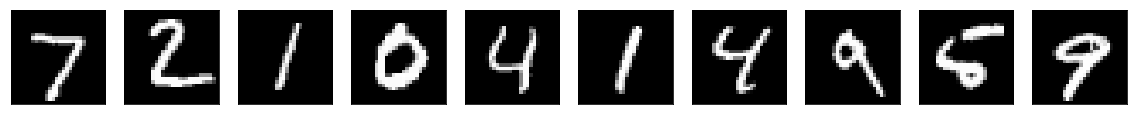

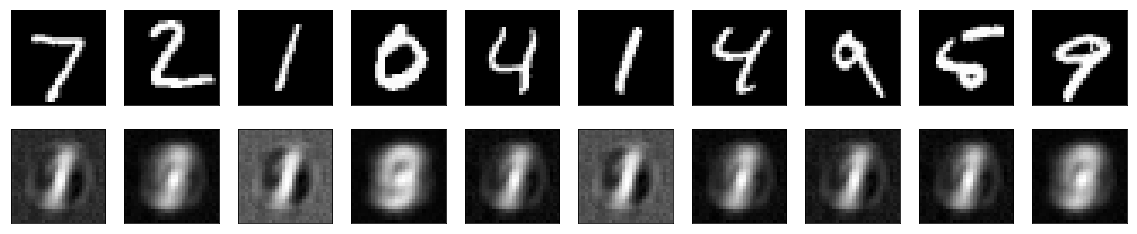

In [10]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

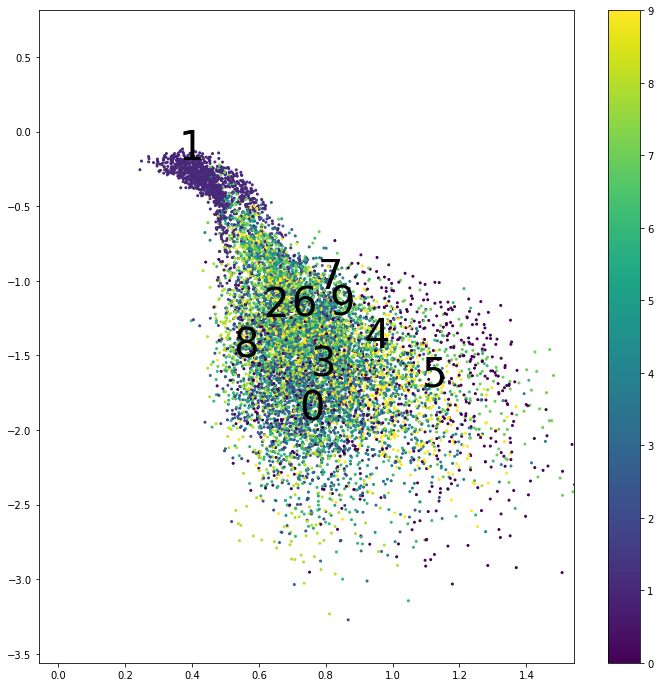

-0.021173215


In [11]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=40000, markersize=4)
scoreSilh = silhouette_score(encodeTest, yTest)
print(scoreSilh)

## Plot the decoding results from the encoding scatter 

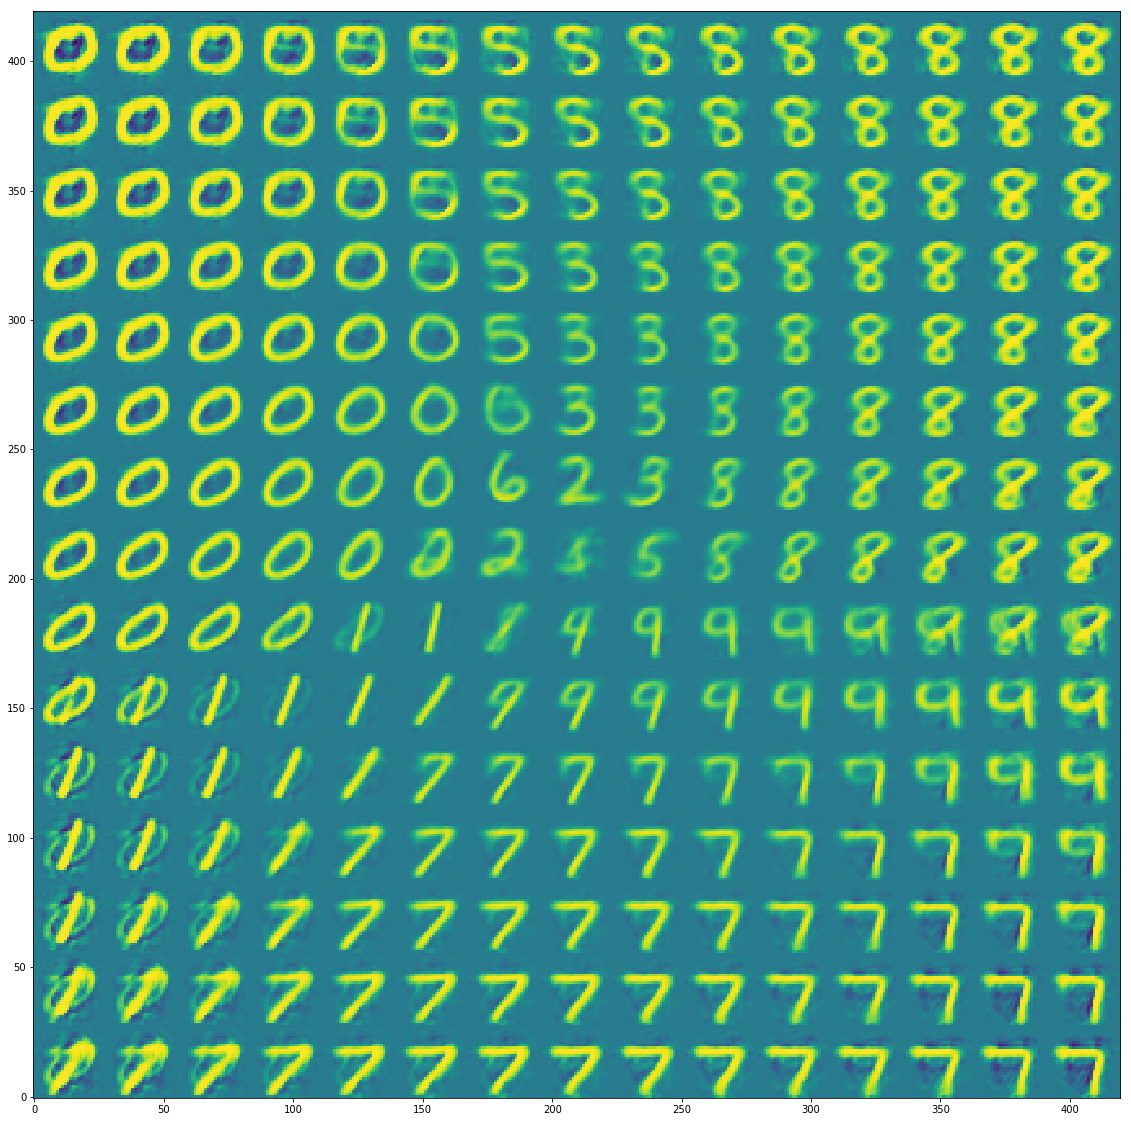

In [12]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

In [13]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

NameError: name 'history' is not defined

In [ ]:
plt.imshow(decoder.predict(np.ones([1,10])).reshape(28,28))